In [1]:
import time
import torch
import json
import random
import math
import warnings
import torchvision
import os
import copy
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from datetime import datetime
from tqdm import tqdm
from PIL import Image
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances_argmin_min, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.model_selection import train_test_split, StratifiedKFold
from torch.utils.data import Subset, Dataset, DataLoader
from torchvision.models import EfficientNet

from torchvision.datasets import ImageFolder
from utils.loss_functions import tkd_kdloss
# from models_package.models import Teacher, Student

# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
# Hyperparameters
learning_rate = 0.0005 # 0.096779
epochs = 100
epochs_pretrain = 3 #3
epochs_optimal_lr = 3 #5
patience_teacher = 2
patience_student = 10
temperature = 4.0
alpha = 0.9
momentum = 0.9
step_size = 30
gamma = 0.1
lmda = 3
batch_size = 76
num_workers = 4

# set to true to use stratified sampling
stratified_sampling_flag = False

# list of lambda values to loop through for grid search
lmda_list_student = [5,3,10,0.5,0]
lmda_list_teacher = [0]

# labels used including for plotting
class_labels = [0, 1, 3, 4, 6, 7, 11, 15, 17, 18, 19, 20, 22, 25, 27, 28, 30, 31, 33, 35, 36, 37, 39, 43, 44, 50, 51, 54, 57, 58]
class_labels_new = torch.tensor([i for i in range(len(class_labels))])
num_classes = 16 #len(class_labels)
class_names_new = [f"Class {label}" for label in range(num_classes)]

# Create directory and file path to save all outputs
output_dir = f'./runs_{datetime.now().strftime("%Y_%m_%d_%H_%M")}'
os.makedirs(output_dir, exist_ok=True)

In [3]:
# set device to cuda if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# Assuming your JSON file is named 'your_file.json'
file_path = './WIDER/Annotations/wider_attribute_trainval.json'

with open(file_path, 'r') as file:
    # Load the JSON data from the file
    data = json.load(file)

class_idx = data['scene_id_map']

In [5]:
new_label_mapping = {
    0: "Team_Sports",
    1: "Celebration",
    2: "Parade",
    3: "Waiter_Or_Waitress",
    4: "Individual_Sports",
    5: "Surgeons",
    6: "Spa",
    7: "Law_Enforcement",
    8: "Business",
    9: "Dresses",
    10: "Water Activities",
    11: "Picnic",
    12: "Rescue",
    13: "Cheering",
    14: "Performance_And_Entertainment",
    15: "Family"
}

# Ensure that all 16 new classes are covered
# If some classes are not explicitly mentioned in new_label_mapping, add them
for i in range(16):
    if i not in new_label_mapping:
        new_label_mapping[i] = "Additional Category {}".format(i)

class_idx = new_label_mapping

In [6]:
class StratifiedBatchSampler:
    """Stratified batch sampling
    Provides equal representation of target classes in each batch
    """
    def __init__(self, y, batch_size, shuffle=True):
        if torch.is_tensor(y):
            y = y.numpy()
        assert len(y.shape) == 1, 'label array must be 1D'
        n_batches = int(len(y) / batch_size)
        self.skf = StratifiedKFold(n_splits=n_batches, shuffle=shuffle)
        self.X = torch.randn(len(y),1).numpy()
        self.y = y
        self.shuffle = shuffle
        self.batch_size = batch_size

    def __iter__(self):
        if self.shuffle:
            self.skf.random_state = torch.randint(0,int(1e8),size=()).item()
        for train_idx, test_idx in self.skf.split(self.X, self.y):
            yield test_idx

    def __len__(self):
        return len(self.y)//self.batch_size

In [7]:
class DataSet(Dataset):
    def __init__(self, ann_files, augs, img_size, dataset):

        # Create a mapping from old labels to new labels
        self.label_mapping = {old_label: new_label for new_label, old_label in enumerate(sorted(class_labels))}

        self.new_label_mapping = {
            0: 2,  # Parade
            1: 8,  # Business
            2: 7,  # Law Enforcement
            3: 14,  # Performance and Entertainment
            4: 1,  # Celebration
            5: 13,  # Cheering
            6: 8,  # Business
            7: 8,  # Business
            8: 1,  # Celebration
            9: 14,  # Performance and Entertainment
            10: 15, # Family
            11: 15, # Family
            12: 11, # Picnic
            13: 7, # Law Enforcement
            14: 6, # Spa
            15: 13, # Cheering
            16: 5, # Surgeons
            17: 3, # Waiter or Waitress
            18: 4, # Individual Sports
            19: 0, # Team Sports
            20: 0, # Team Sports
            21: 0, # Team Sports
            22: 4, # Individual Sports
            23: 10, # Water Activities
            24: 4, # Individual Sports
            25: 1, # Celebration
            26: 9, # Dresses
            27: 12, # Rescue
            28: 10,# Water Activities
            29: 0  # Team Sports
        }

        
        self.dataset = dataset
        self.ann_files = ann_files
        self.augment = self.augs_function(augs, img_size)
        # Initialize transformations directly
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1])
            ] 
        )
        if self.dataset == "wider":
            self.transform = transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])                ] 
            )        

        self.anns = []
        self.load_anns()
        print(self.augment)

    def augs_function(self, augs, img_size):            
        t = []
        if 'randomflip' in augs:
            t.append(transforms.RandomHorizontalFlip())
        if 'ColorJitter' in augs:
            t.append(transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0))
        if 'resizedcrop' in augs:
            t.append(transforms.RandomResizedCrop(img_size, scale=(0.7, 1.0)))
        if 'RandAugment' in augs:
            t.append(transforms.RandAugment())

        t.append(transforms.Resize((img_size, img_size)))

        return transforms.Compose(t)
    
    def load_anns(self):
        self.anns = []
        for ann_file in self.ann_files:
            json_data = json.load(open(ann_file, "r"))
            self.anns += json_data

    def __len__(self):
        return len(self.anns)

    def __getitem__(self, idx):
        # Make sure the index is within bounds
        idx = idx % len(self)
        ann = self.anns[idx]
        
        try:
            # Attempt to open the image file
            img = Image.open(f'WIDER/Image/{ann["file_name"]}').convert("RGB")

            # If this is the wider dataset, proceed with specific processing
            # x, y, w, h = ann['bbox']
            # img_area = img.crop([x, y, x+w, y+h])
            img_area = self.augment(img)
            img_area = self.transform(img_area)
            attributes_list = [target['attribute'] for target in ann['targets']]
            num_people = len(attributes_list)
            attributes_distribution = [max(sum(attribute), 0)/num_people for attribute in zip(*attributes_list)]
            # Extract label from image path
            img_path = f'WIDER/Image/{ann["file_name"]}'
            label = self.extract_label(img_path)  # You might need to implement this method
            
            return {
                "label": label,
                "target": torch.tensor([attributes_distribution[0]], dtype=torch.float32),
                "img": img_area
            }
            
        except Exception as e:
            # If any error occurs during the processing of an image, log the error and the index
            print(f"Error processing image at index {idx}: {e}")
            # Instead of returning None, raise the exception
            raise

    def extract_label(self, img_path):
        original_label = None
    
        if "WIDER/Image/train" in img_path:
            label_str = img_path.split("WIDER/Image/train/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
        elif "WIDER/Image/test" in img_path:
            label_str = img_path.split("WIDER/Image/test/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
        elif "WIDER/Image/val" in img_path:  # Handle validation images
            label_str = img_path.split("WIDER/Image/val/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
    
        if original_label is not None:
            remapped_label = self.label_mapping[original_label]
            new_label_mapping = self.new_label_mapping[remapped_label]
            return new_label_mapping
        else:
            raise ValueError(f"Label could not be extracted from path: {img_path}")


In [8]:
train_file = ['data/wider/trainval_wider.json']
test_file = ['data/wider/test_wider.json']


In [9]:
def custom_collate(batch):
    # Filter out any None items in the batch
    batch = [item for item in batch if item is not None]
    # If after filtering the batch is empty, handle this case by either returning an empty tensor or raising an exception
    if len(batch) == 0:
        raise ValueError("Batch is empty after filtering out None items.")
    return torch.utils.data.dataloader.default_collate(batch)


In [10]:
train_dataset = DataSet(train_file, augs = [], img_size = 226, dataset = 'wider')
test_dataset = DataSet(test_file, augs = [], img_size = 226, dataset = 'wider')


if stratified_sampling_flag:
    trainloader = DataLoader(train_dataset, 
                             batch_sampler=StratifiedBatchSampler(torch.tensor([train_dataset[i]['label'] for i in range(len(train_dataset))]), 
                             batch_size=batch_size), num_workers=num_workers, collate_fn=custom_collate)
    testloader = DataLoader(test_dataset, batch_sampler=StratifiedBatchSampler(torch.tensor([test_dataset[i]['label'] for i in range(len(test_dataset))]), 
                             batch_size=batch_size), num_workers=num_workers, collate_fn=custom_collate)
else:
    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                             num_workers=num_workers, collate_fn=custom_collate)
    testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=custom_collate)

Compose(
    Resize(size=(226, 226), interpolation=bilinear, max_size=None, antialias=warn)
)
Compose(
    Resize(size=(226, 226), interpolation=bilinear, max_size=None, antialias=warn)
)


In [11]:
len(train_dataset)

10324

# Start Training Process

In [12]:
def one_hot_encode(labels, num_classes):
    return np.eye(num_classes)[labels]

def calculate_recall_multiclass(conf_matrix):
    recalls = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
    recalls[np.isnan(recalls)] = 0  # Replace NaN with 0
    return recalls

def evaluate_model_with_gender_multiclass(pred, label, gender, num_classes):
    predictions = pred.cpu()
    true_labels = label.cpu()
    gender = gender.cpu()

    # Identify male and female indices based on the gender threshold
    male_indices = np.where(gender >= 0.5)[0]
    female_indices = np.where(gender < 0.5)[0]

    # Convert labels to one-hot encoding
    one_hot_labels = one_hot_encode(true_labels, num_classes=num_classes)
    one_hot_preds = one_hot_encode(predictions, num_classes=num_classes)
    # Initialize recall arrays
    male_recall = np.zeros(num_classes)
    female_recall = np.zeros(num_classes)

    # Extract predictions and labels for male and female indices
    male_predictions = np.argmax(one_hot_preds[male_indices], axis=1)
    female_predictions = np.argmax(one_hot_preds[female_indices], axis=1)
    male_labels = np.argmax(one_hot_labels[male_indices], axis=1)
    female_labels = np.argmax(one_hot_labels[female_indices], axis=1)

    # Check if the class labels are within the expected range
    assert (0 <= male_predictions.min() < num_classes) and (0 <= male_predictions.max() < num_classes), "Invalid class indices in male predictions"
    assert (0 <= female_predictions.min() < num_classes) and (0 <= female_predictions.max() < num_classes), "Invalid class indices in female predictions"
    assert (0 <= male_labels.min() < num_classes) and (0 <= male_labels.max() < num_classes), "Invalid class indices in male labels"
    assert (0 <= female_labels.min() < num_classes) and (0 <= female_labels.max() < num_classes), "Invalid class indices in female labels"

    # Calculate confusion matrices for each gender
    male_conf_matrix = confusion_matrix(male_labels, male_predictions, labels=np.arange(num_classes))
    female_conf_matrix = confusion_matrix(female_labels, female_predictions, labels=np.arange(num_classes))

    # Calculate recall for each class and gender
    male_recall[:len(male_conf_matrix)] = calculate_recall_multiclass(male_conf_matrix)
    female_recall[:len(female_conf_matrix)] = calculate_recall_multiclass(female_conf_matrix)

    return male_recall - female_recall, male_conf_matrix, female_conf_matrix


In [13]:
# Instantiate the models
###################### Testing 1 ######################
# Create instances of your models
teacher_model = torchvision.models.efficientnet_b3(weights='DEFAULT')
teacher_model.classifier = nn.Linear(1536, num_classes)
student_model = torchvision.models.efficientnet_b0(weights='DEFAULT')
student_model.classifier = nn.Linear(1280, num_classes)

# Load teacher
# teacher_model = torch.load('teacher_model_ckd_wider.pth')
# teacher_model.load_state_dict(torch.load('teacher_model_weights_ckd_wider.pth'))
# torch.save(teacher_model.state_dict(), 'teacher_model_weights_ckd_wider.pth')
# # Load the studnet
# student_model = torch.load('student_model_ckd_prof.pth')
# student_model.load_state_dict(torch.load('student_model_weights_ckd_prof_checkpoint.pth'))
# student_model = student_model.to(device)


This is the initialization of the 2-layer Adversary Perceptron. It is initialized with the number of classes*2, which represents the predicted labels (y_hat) and the true labels (y). The output of the final layer is a regression output, which is intended to predict the strength of gender (continuous number where anything past 0.5 is more male).


In [14]:
class Adversary(nn.Module):
    def __init__(self, input_size=num_classes):
        super(Adversary, self).__init__()

        self.a1 = nn.Linear(input_size, 16)
        self.a2 = nn.Linear(16, 1)  # Output size 1 for regression
        nn.init.xavier_normal_(self.a1.weight)
        nn.init.kaiming_normal_(self.a2.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, input_ids):
        adversary = F.relu(self.a1(input_ids))
        adversary_output = F.sigmoid(self.a2(adversary))  # Linear activation for regression
        return adversary_output

# Instantiate the Adversary
adv = Adversary()

In [15]:
def pretrain_student(student, teacher, trainloader, criterion, optimizer, device, alpha, temperature, epochs_pretrain, patience=patience_student):
    teacher.eval()
    teacher.to(device)
    best_val_loss = float('inf')  
    patience_counter = 0 
    student_epoch_losses = []
    val_losses = []
    
    for epoch in range(epochs_pretrain):
        student.train()
        student.to(device)
        running_loss = 0.0 
        epoch_loss = 0.0  
        num_batches = 0  
        
        for index, data in enumerate(tqdm(trainloader)):

            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            optimizer.zero_grad()
            student_outputs = student(inputs)

            with torch.no_grad():
                teacher_outputs = teacher(inputs)

            ce_loss = criterion(student_outputs, labels)
            kd_loss = tkd_kdloss(student_outputs, teacher_outputs, temperature=temperature)  # Make sure this returns a scalar
            
            # If not scalar, sum up to make sure the loss is scalar
            if kd_loss.ndim != 0:
                kd_loss = kd_loss.sum()
                
            # Now combine the losses
            loss = alpha * kd_loss + (1 - alpha) * ce_loss
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1
        
        epoch_loss /= num_batches
        print(f'*******Epoch {epoch}: loss - {epoch_loss}')
        student_epoch_losses.append(epoch_loss)


In [16]:
def pretrain_teacher(teacher, trainloader, criterion, optimizer, device, epochs_pretrain, patience=patience_student):
    teacher.to(device)
    teacher.train()  # Set the model to training mode
    best_val_loss = float('inf')  
    patience_counter = 0 
    teacher_epoch_losses = []
    val_losses = []
    
    for epoch in range(epochs_pretrain):
        running_loss = 0.0 
        epoch_loss = 0.0  
        num_batches = 0  
        
        for index, data in enumerate(tqdm(trainloader)):
            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            optimizer.zero_grad()
            teacher_outputs = teacher(inputs)

            ce_loss = criterion(teacher_outputs, labels)
                
            loss = ce_loss
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1
        
        epoch_loss /= num_batches
        print(f'*******Epoch {epoch}: loss - {epoch_loss}')
        teacher_epoch_losses.append(epoch_loss)


In [17]:
def pretrain_adversary(adv, student, adversary_optimizer, trainloader, adv_criterion, device, epochs_pretrain):

  for epoch in range(epochs_pretrain):
    epoch_loss = 0
    epoch_batches = 0
    for i, data in enumerate(tqdm(trainloader)): # starting from the 0th batch
        # get the inputs and labels
        adv.train()
        adv.to(device)
        inputs = data['img'].to(device)
        labels = data['label'].to(device)
        targets = data['target'].to(device)
        student = student.to(device)
        adversary_optimizer.zero_grad()
        student_output = student(inputs)
        adversary_output = adv(student_output)
        adversary_loss = adv_criterion(adversary_output, targets) # compute loss
        adversary_loss.backward() # back prop
        adversary_optimizer.step()
        epoch_loss += adversary_loss.item()
        epoch_batches += 1

    print("Average Pretrain Adversary epoch loss: ", epoch_loss/epoch_batches)


In [18]:
# Optimizer and scheduler for the student model
student_optimizer = optim.Adam(student_model.parameters(), lr=learning_rate)

# Optimizer and scheduler for the teacher model
teacher_optimizer = optim.SGD(teacher_model.parameters(), lr=learning_rate, momentum=momentum)
teacher_scheduler = torch.optim.lr_scheduler.StepLR(teacher_optimizer, step_size=step_size, gamma=gamma)

optimizer_adv = optim.Adam(adv.parameters(), lr=learning_rate)

# Instantiate the model and the loss function
criterion_clf = nn.CrossEntropyLoss()
adv_criterion = nn.MSELoss()


In [19]:
def plot_loss_curve(losses):
    epochs = range(1, len(losses) + 1)
    plt.plot(epochs, losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Val Loss Curve')
    plt.show()

In [20]:
# This is the adversary training function, where we input the student outputs, 
# with the true labels into the adversary model created previously.
def train_adversary(adv, model, optimizer, trainloader, criterion, epochs):
    best_val_loss = float('inf')
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_batches = 0
        for i, data in enumerate(tqdm(trainloader)):
            # get the inputs and labels
            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            targets = data['target'].to(device)
            model.eval()
            model.to(device)
            adv.train()
            adv.to(device)
            optimizer.zero_grad()
            # output the student model, join with ohe labels. 
            model_output = model(inputs)
            adversary_output = adv(model_output)

            adversary_loss = criterion(adversary_output, targets)
            adversary_loss.backward()
            epoch_loss += adversary_loss.item()
            epoch_batches += 1
            optimizer.step()
        epoch_loss/=epoch_batches
        print("Average Adversary epoch loss:", epoch_loss)

In [21]:
# Function to train the teacher model


def train_teacher(model, adv, trainloader, criterion, adv_criterion, optimizer, optimizer_adv, device, 
                  epochs, lmda, patience=patience_teacher):

    best_val_loss = float('inf')
    patience_counter = 0
    epoch_losses = [] 
    val_losses = []
    val_disparities = []
    val_accuracies = []
    best_total_val_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        adv.train()
        model.to(device)
        adv.to(device)
        running_loss = 0.0
        epoch_loss = 0.0  
        num_batches = 0  
        
        for index, data in enumerate(tqdm(trainloader)):
            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            targets = data['target'].to(device)
        
            # Forward pass for teacher model
            optimizer.zero_grad()
            outputs = model(inputs)
            classification_loss = criterion(outputs, labels)
        
            # Forward pass for adversary model
            optimizer_adv.zero_grad()
            with torch.no_grad():
                teacher_outputs_detached = outputs.detach()
            adversary_output = adv(teacher_outputs_detached)
            adversary_loss = adv_criterion(adversary_output, targets)
        
            # Calculate the total loss by combining classification and adversary loss
            if lmda != 0:
                total_loss = classification_loss + classification_loss/adversary_loss - lmda * adversary_loss
            else:
                total_loss = classification_loss
                
            total_loss.backward()
        
            optimizer.step()
            optimizer_adv.step()
        
            running_loss += total_loss.item()
            epoch_loss += total_loss.item()
            num_batches += 1

        epoch_loss /= num_batches  
        epoch_losses.append(epoch_loss)

        model.eval()
        total_correct = 0
        total_samples = 0
        total_val_loss = 0.0
        num_batches = 0
        confusion_male = np.zeros((num_classes, num_classes))
        confusion_female = np.zeros((num_classes, num_classes))
        
        with torch.no_grad():
            for val_data in tqdm(testloader):
                val_inputs = val_data['img'].to(device)
                val_labels = val_data['label'].to(device)
                val_targets = val_data['target'].to(device)
                
                val_outputs = model(val_inputs)
                with torch.no_grad():
                    teacher_outputs_detached_val = val_outputs.detach()                
                adversary_output_val = adv(teacher_outputs_detached_val)
                adversary_loss_val = adv_criterion(adversary_output_val, val_targets)
                
                # Compute validation loss
                val_ce_loss = criterion(val_outputs, val_labels)

                if lmda !=0:
                    val_loss = val_ce_loss + val_ce_loss/adversary_loss_val - lmda * adversary_loss_val
                else:
                    val_loss = val_ce_loss
                    
                total_val_loss += val_loss.item()

                # Compute the validation accuracy
                _, predicted = torch.max(val_outputs, 1)
                total_samples += val_labels.size(0)
                total_correct += (predicted == val_labels).sum().item()
                num_batches += 1

                # Compute recall differences for gender
                recall_diff = evaluate_model_with_gender_multiclass(predicted, val_labels, val_targets, num_classes=num_classes)
                confusion_male += recall_diff[1]
                confusion_female += recall_diff[2]

            total_val_loss /= num_batches
            confusion_male /= num_batches
            confusion_female /= num_batches
            
            epoch_disparity = calculate_recall_multiclass(confusion_male) - calculate_recall_multiclass(confusion_female)
            val_losses.append(total_val_loss)
            non_zero_abs_values = np.abs(epoch_disparity[epoch_disparity != 0])
            mean_non_zero_abs_disparity = np.mean(non_zero_abs_values)
            val_disparities.append(mean_non_zero_abs_disparity)
            accuracy = total_correct / total_samples
            val_accuracies.append(accuracy)
            print(f'*****Epoch {epoch + 1}/{epochs}*****\n' 
            f'*****Train Loss: {epoch_loss: .6f} Val Loss: {total_val_loss: .6f}*****\n'
            f'*****Validation Accuracy: {accuracy * 100:.2f}%*****\n'
            f'*****Total Avg Disparity: {mean_non_zero_abs_disparity}*****\n')
            class_recall_mapping = {class_name: epoch_disparity[int(class_label)] for class_label, class_name in class_idx.items()}
            
            # Print disparities by class label
            for class_label, recall_diff in class_recall_mapping.items():
                print(f"Class {class_label}: Recall Difference = {recall_diff}")
        
        # Check for early stopping
        if abs(total_val_loss) < abs(best_total_val_loss):
            best_total_val_loss = total_val_loss
            patience_counter = 0 
            best_epoch_mean_abs_disparity = mean_non_zero_abs_disparity
            torch.save(model.state_dict(), f'teacher_model_weights_ckd_prof_checkpoint{lmda}.pth')
            torch.save(model, f'teacher_model_ckd_prof_checkpoint{lmda}.pth')
        else:
            patience_counter += 1 

        if patience_counter >= patience:
            print('Early stopping')
            break  
        
    plot_loss_curve(val_losses)
    print("Finished Training Teacher")
    return val_disparities


# Function to train the student model with knowledge distillation
def train_student_with_distillation_disparity(student, teacher, adv, trainloader, testloader, criterion, adv_criterion, optimizer, 
                                              device, alpha, temperature, epochs, lmda, patience=patience_student, optimizer_adv=None):
    teacher.eval()
    teacher.to(device)
    best_val_accuracy = 0
    best_total_val_loss = float('inf')
    best_epoch_accuracy = 0.0
    best_epoch_disparity = 0.0
    patience_counter = 0 
    student_epoch_losses = []
    val_losses = []
    val_disparities = []
    val_accuracies = []

    for epoch in range(epochs):
        if lmda != 0:
        # Train the adversary at the start of each epoch
            train_adversary(adv, student, optimizer_adv, trainloader, adv_criterion, 1)

        student.train()
        student.to(device)
        adv.eval()
        adv.to(device)
        running_loss = 0.0 
        epoch_loss = 0.0  
        num_batches = 0 
        confusion_male = np.zeros((num_classes, num_classes))
        confusion_female = np.zeros((num_classes, num_classes))

        for index, data in enumerate(tqdm(trainloader)):
            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            targets = data['target'].to(device)
            optimizer.zero_grad()
            student_outputs = student(inputs)
            with torch.no_grad():
                teacher_outputs = teacher(inputs)

            # detach student_outputs to avoid exploding gradients by passing same inputs (with gradience) into two different models. 
            studentached = student_outputs.detach()
            # One-hot encode labels and concatenate with student's predictions

            # Run the adversarial model on concatenated true labels, and predicted labels
            with torch.no_grad():
                adversary_output = adv(studentached)

            # Calc adversary loss, which is an MSE loss, because this is a regression output. 
            adversary_loss = adv_criterion(adversary_output, targets)
            ce_loss = criterion(student_outputs, labels)
            kd_loss = tkd_kdloss(student_outputs, teacher_outputs, temperature=temperature)  # Make sure this returns a scalar
            
            if kd_loss.ndim != 0:
                kd_loss = kd_loss.sum()

            # Now combine the losses, subtract weighted adversary loss because we need to maximize that loss 
            # goal of the model is to have the adversary not predict gender. 
            if lmda != 0:
                loss = (alpha * kd_loss + (1 - alpha) * ce_loss) - lmda * adversary_loss
            else:
                loss = alpha * kd_loss + (1 - alpha) * ce_loss
                
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1

        epoch_loss /= num_batches
        # print(f'*******Epoch {epoch}: running_recall_with - {running_recall_with/num_batches}  |  running_recall_without - {running_recall_without/num_batches}  |  disparity - {epoch_disparity/num_batches}******')
        student_epoch_losses.append(epoch_loss)

        student.eval()
        total_correct = 0
        total_samples = 0
        total_val_loss = 0.0
        num_batches = 0
        # Validation after each epoch
        with torch.no_grad():
            for val_data in tqdm(testloader):
                val_inputs = val_data['img'].to(device)
                val_labels = val_data['label'].to(device)
                val_targets = val_data['target'].to(device)
                
                # Forward pass for validation
                val_student_outputs = student(val_inputs)
                val_teacher_outputs = teacher(val_inputs)

                val_studentached = val_student_outputs.detach()   

                val_adversary_output = adv(val_studentached)
                val_adversary_loss = adv_criterion(val_adversary_output, val_targets)
                val_ce_loss = criterion(val_student_outputs, val_labels)
                val_kd_loss = tkd_kdloss(val_student_outputs, val_teacher_outputs, temperature=temperature)  # Make sure this returns a scalar
                
                if val_kd_loss.ndim != 0:
                    val_kd_loss = val_kd_loss.sum()
                if lmda != 0:
                    val_loss = (alpha * val_kd_loss + (1 - alpha) * val_ce_loss) - lmda * val_adversary_loss
                else:
                    val_loss = alpha * val_kd_loss + (1 - alpha) * val_ce_loss
                total_val_loss += val_loss.item()
    
                # Compute the validation accuracy
                _, predicted = torch.max(val_student_outputs, 1)
                total_samples += val_labels.size(0)
                total_correct += (predicted == val_labels).sum().item()
                num_batches += 1
                recall_diff = evaluate_model_with_gender_multiclass(predicted, val_labels, val_targets, num_classes=num_classes)
                confusion_male += recall_diff[1]
                confusion_female += recall_diff[2]
    
            total_val_loss /= num_batches
            confusion_male /= num_batches
            confusion_female /= num_batches

            epoch_disparity = calculate_recall_multiclass(confusion_male) - calculate_recall_multiclass(confusion_female)
            val_losses.append(total_val_loss)
            non_zero_abs_values = np.abs(epoch_disparity[epoch_disparity != 0])
            mean_non_zero_abs_disparity = np.mean(non_zero_abs_values)
            val_disparities.append(mean_non_zero_abs_disparity)
            accuracy = total_correct / total_samples
            val_accuracies.append(accuracy)
            print(f'*****Epoch {epoch + 1}/{epochs}*****\n' 
            f'*****Train Loss: {epoch_loss: .6f} Val Loss: {total_val_loss: .6f}*****\n'
            f'*****Validation Accuracy: {accuracy * 100:.2f}%*****\n'
            f'*****Total Avg Disparity: {mean_non_zero_abs_disparity}*****\n')
            class_recall_mapping = {class_name: epoch_disparity[int(class_label)] for class_label, class_name in class_idx.items()}
            
            # Print disparities by class label
            for class_label, recall_diff in class_recall_mapping.items():
                print(f"Class {class_label}: Recall Difference = {recall_diff}")

        # Check for early stopping
        if abs(total_val_loss) < abs(best_total_val_loss):
            best_total_val_loss = total_val_loss
            patience_counter = 0
            best_epoch_mean_abs_disparity = mean_non_zero_abs_disparity
            torch.save(student.state_dict(), f'student_model_weights_ckd_wider_checkpoint_lambda{lmda}.pth')
            torch.save(student, f'student_model_ckd_wider_checkpoint_lambda{lmda}.pth')
        else:
            patience_counter += 1 

        if patience_counter >= patience:
            print('Early stopping')
            break  
    
        file_path = os.path.join(output_dir, f'validation_{lmda}.txt')
        
        # Append data to the text file
        with open(file_path, 'a') as file:
            file.write(f'********Epoch: {epoch}***********')
            
            file.write("Val Accuracies:\n")
            for accuracy in val_accuracies:
                file.write(f"{accuracy}\n")
        
            file.write("\nVal Disparities:\n")
            for disparity in val_disparities:
                file.write(f"{disparity}\n")

            for class_label, recall_diff in class_recall_mapping.items():
                file.write(f"Class {class_label}: Recall Difference = {recall_diff}\n")
        
        
        print(f"Data has been appended to {file_path}")
    plot_loss_curve(val_losses)
                
    return best_epoch_mean_abs_disparity

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:17<00:00,  2.57it/s]


*****Epoch 1/100*****
*****Train Loss:  1.579322 Val Loss:  1.205407*****
*****Validation Accuracy: 63.69%*****
*****Total Avg Disparity: 0.15749503262485726*****

Class Team_Sports: Recall Difference = 0.08553745547965186
Class Celebration: Recall Difference = -0.14392561148170602
Class Parade: Recall Difference = 0.141881240147136
Class Waiter_Or_Waitress: Recall Difference = -0.27786499215070626
Class Individual_Sports: Recall Difference = -0.08613122668422202
Class Surgeons: Recall Difference = -0.25277161862527714
Class Spa: Recall Difference = -0.099290780141844
Class Law_Enforcement: Recall Difference = 0.19660504592489236
Class Business: Recall Difference = 0.08802216538789426
Class Dresses: Recall Difference = -0.6730061349693252
Class Water Activities: Recall Difference = 0.04183627317955685
Class Picnic: Recall Difference = 0.20915032679738577
Class Rescue: Recall Difference = 0.043797468354430436
Class Cheering: Recall Difference = -0.009410801963993465
Class Performance_An

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:18<00:00,  2.46it/s]


*****Epoch 2/100*****
*****Train Loss:  0.822937 Val Loss:  1.202243*****
*****Validation Accuracy: 64.39%*****
*****Total Avg Disparity: 0.13883926313701403*****

Class Team_Sports: Recall Difference = 0.06095638465580666
Class Celebration: Recall Difference = -0.04927228623408125
Class Parade: Recall Difference = 0.028142698662929844
Class Waiter_Or_Waitress: Recall Difference = -0.2982731554160126
Class Individual_Sports: Recall Difference = -0.08170580059980981
Class Surgeons: Recall Difference = -0.15447154471544722
Class Spa: Recall Difference = -0.28368794326241137
Class Law_Enforcement: Recall Difference = 0.05080804557609575
Class Business: Recall Difference = -0.00959079283887454
Class Dresses: Recall Difference = -0.6098159509202454
Class Water Activities: Recall Difference = 0.05608322026232482
Class Picnic: Recall Difference = -0.16339869281045744
Class Rescue: Recall Difference = 0.09088607594936715
Class Cheering: Recall Difference = -0.05155482815057277
Class Performanc

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:18<00:00,  2.49it/s]


*****Epoch 3/100*****
*****Train Loss:  0.428037 Val Loss:  1.350385*****
*****Validation Accuracy: 64.10%*****
*****Total Avg Disparity: 0.1621907926165373*****

Class Team_Sports: Recall Difference = 0.036433701173585686
Class Celebration: Recall Difference = -0.04639175257731959
Class Parade: Recall Difference = 0.08133356688269977
Class Waiter_Or_Waitress: Recall Difference = -0.25981161695447397
Class Individual_Sports: Recall Difference = -0.060749030795113956
Class Surgeons: Recall Difference = -0.13673318551367336
Class Spa: Recall Difference = -0.41134751773049666
Class Law_Enforcement: Recall Difference = 0.10754563422857821
Class Business: Recall Difference = 0.07843137254901955
Class Dresses: Recall Difference = -0.754601226993865
Class Water Activities: Recall Difference = 0.06411126187245597
Class Picnic: Recall Difference = -0.16339869281045744
Class Rescue: Recall Difference = 0.06911392405063288
Class Cheering: Recall Difference = -0.12090834697217678
Class Performance

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:18<00:00,  2.42it/s]


*****Epoch 4/100*****
*****Train Loss:  0.226744 Val Loss:  1.519820*****
*****Validation Accuracy: 63.67%*****
*****Total Avg Disparity: 0.14680016509580826*****

Class Team_Sports: Recall Difference = 0.0936182635604601
Class Celebration: Recall Difference = -0.15928845765110167
Class Parade: Recall Difference = 0.032171425235009155
Class Waiter_Or_Waitress: Recall Difference = -0.32417582417582425
Class Individual_Sports: Recall Difference = -0.07921878428790885
Class Surgeons: Recall Difference = -0.27050997782705094
Class Spa: Recall Difference = -0.41134751773049644
Class Law_Enforcement: Recall Difference = 0.13103127543308912
Class Business: Recall Difference = 0.04475703324808189
Class Dresses: Recall Difference = -0.4098159509202454
Class Water Activities: Recall Difference = 0.048733604703753985
Class Picnic: Recall Difference = -0.07189542483660127
Class Rescue: Recall Difference = -0.1341772151898734
Class Cheering: Recall Difference = 0.00020458265139111642
Class Performa

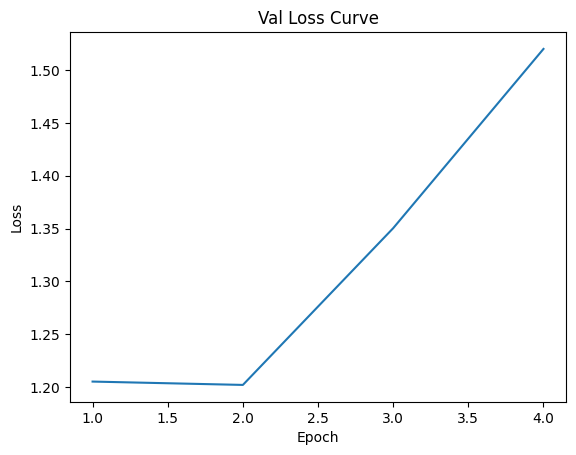

Finished Training Teacher
Teacher weights and architecture saved and exported for lambda: 0


In [22]:
# Initialize the dictionary for results
lambda_results = {}

# Loop for training the teacher model with different lambda values
for i in lmda_list_teacher:
    # Reset the teacher model for each lambda
    teacher_model = torchvision.models.efficientnet_b3(weights='DEFAULT')    
    # Replace the last fully connected layer with a new one
    teacher_model.classifier = nn.Linear(1536, num_classes)
#     teacher_model = torch.load('teacher_model_ckd_wider_lambda02.pth')
#     teacher_model.load_state_dict(torch.load('teacher_model_weights_ckd_wider_lambda02.pth'))
    
    teacher_optimizer = optim.Adam(teacher_model.parameters(), lr=learning_rate)
    
    # Initialize the adversary for the teacher
    adv = Adversary()
    teacher_optimizer_adv = optim.Adam(adv.parameters(), lr=learning_rate)

    # pretrain_teacher(teacher_model, trainloader, criterion_clf, teacher_optimizer, device, epochs_pretrain)
    # pretrain_adversary(adv, student_model, optimizer_adv, trainloader, adv_criterion, device, epochs_pretrain)
    
    # Train the teacher model with adversarial training
    teacher_mean_abs_val_disparity = train_teacher(teacher_model, adv, trainloader, criterion_clf, adv_criterion, teacher_optimizer, teacher_optimizer_adv, device, epochs, i, patience=patience_teacher)

    # Save the teacher model and its state
    torch.save(teacher_model.state_dict(), f'teacher_model_weights_ckd_wider_lambda{i}2.pth')
    torch.save(teacher_model, f'teacher_model_ckd_wider_lambda{i}2.pth')
    print('Teacher weights and architecture saved and exported for lambda:', i)

    # Store the teacher results in the dictionary
    lambda_results[i] = {
        'teacher_mean_abs_val_disparity': teacher_mean_abs_val_disparity
    }


100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:23<00:00,  1.64it/s]


*******Epoch 0: loss - 0.5460653752088547


100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:23<00:00,  1.64it/s]


*******Epoch 1: loss - 0.3220263905823231


100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:23<00:00,  1.64it/s]


*******Epoch 2: loss - 0.20873231407912338


100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:42<00:00,  1.32it/s]


Average Pretrain Adversary epoch loss:  0.43791737473186326


100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:42<00:00,  1.32it/s]


Average Pretrain Adversary epoch loss:  0.4379812638987513


100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:42<00:00,  1.32it/s]


Average Pretrain Adversary epoch loss:  0.4379888084881446


100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:59<00:00,  2.29it/s]


Average Adversary epoch loss: 0.4112679840010755


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.32it/s]


*****Epoch 1/100*****
*****Train Loss: -1.831072 Val Loss: -1.748742*****
*****Validation Accuracy: 64.44%*****
*****Total Avg Disparity: 0.14319992444624535*****

Class Team_Sports: Recall Difference = 0.059496701115198336
Class Celebration: Recall Difference = -0.0085405296139075
Class Parade: Recall Difference = 0.10719915922228052
Class Waiter_Or_Waitress: Recall Difference = -0.33673469387755095
Class Individual_Sports: Recall Difference = -0.08225440713919985
Class Surgeons: Recall Difference = -0.08203991130820404
Class Spa: Recall Difference = -0.30496453900709225
Class Law_Enforcement: Recall Difference = 0.1638181606789909
Class Business: Recall Difference = 0.016410912190963356
Class Dresses: Recall Difference = -0.6871165644171778
Class Water Activities: Recall Difference = 0.011307100859339614
Class Picnic: Recall Difference = -0.0326797385620915
Class Rescue: Recall Difference = 0.15974683544303797
Class Cheering: Recall Difference = -0.04337152209492634
Class Performance

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:59<00:00,  2.28it/s]


Average Adversary epoch loss: 0.39387791669544053


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.32it/s]


*****Epoch 2/100*****
*****Train Loss: -1.857283 Val Loss: -1.743548*****
*****Validation Accuracy: 64.82%*****
*****Total Avg Disparity: 0.15800256774692897*****

Class Team_Sports: Recall Difference = 0.07363811525661235
Class Celebration: Recall Difference = -0.09000404285425512
Class Parade: Recall Difference = 0.08127517954107533
Class Waiter_Or_Waitress: Recall Difference = -0.3163265306122448
Class Individual_Sports: Recall Difference = -0.0364640479847852
Class Surgeons: Recall Difference = -0.03917220990391701
Class Spa: Recall Difference = -0.39007092198581567
Class Law_Enforcement: Recall Difference = 0.15893500755726075
Class Business: Recall Difference = -0.01619778346121048
Class Dresses: Recall Difference = -0.7423312883435583
Class Water Activities: Recall Difference = -0.01899592944369044
Class Picnic: Recall Difference = -0.03267973856209161
Class Rescue: Recall Difference = 0.1217721518987342
Class Cheering: Recall Difference = -0.029255319148936143
Class Performance

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:59<00:00,  2.29it/s]


Average Adversary epoch loss: 0.34797597468337593


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.34it/s]


*****Epoch 3/100*****
*****Train Loss: -1.467442 Val Loss: -1.350525*****
*****Validation Accuracy: 65.25%*****
*****Total Avg Disparity: 0.157249131036779*****

Class Team_Sports: Recall Difference = 0.04075436445378644
Class Celebration: Recall Difference = -0.07767333737618765
Class Parade: Recall Difference = 0.14491738191160153
Class Waiter_Or_Waitress: Recall Difference = -0.4058084772370487
Class Individual_Sports: Recall Difference = -0.06762489942213445
Class Surgeons: Recall Difference = -0.0813008130081303
Class Spa: Recall Difference = -0.12056737588652477
Class Law_Enforcement: Recall Difference = 0.09998837344494826
Class Business: Recall Difference = -0.015132139812446765
Class Dresses: Recall Difference = -0.7116564417177914
Class Water Activities: Recall Difference = 0.011533242876526462
Class Picnic: Recall Difference = -0.130718954248366
Class Rescue: Recall Difference = 0.20101265822784808
Class Cheering: Recall Difference = -0.11783960720130926
Class Performance_An

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:58<00:00,  2.31it/s]


Average Adversary epoch loss: 0.3036510200404069


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:20<00:00,  2.29it/s]


*****Epoch 4/100*****
*****Train Loss: -1.460529 Val Loss: -1.310125*****
*****Validation Accuracy: 65.74%*****
*****Total Avg Disparity: 0.11735894138799176*****

Class Team_Sports: Recall Difference = 0.07621883575640809
Class Celebration: Recall Difference = -0.09556296745502324
Class Parade: Recall Difference = 0.04939569101418817
Class Waiter_Or_Waitress: Recall Difference = -0.25745682888540034
Class Individual_Sports: Recall Difference = -0.130239192451174
Class Surgeons: Recall Difference = -0.014781966001478297
Class Spa: Recall Difference = -0.014184397163120477
Class Law_Enforcement: Recall Difference = 0.07382862457853734
Class Business: Recall Difference = -0.037936913895993185
Class Dresses: Recall Difference = -0.754601226993865
Class Water Activities: Recall Difference = 0.018656716417910335
Class Picnic: Recall Difference = 0.019607843137255054
Class Rescue: Recall Difference = 0.14632911392405062
Class Cheering: Recall Difference = -0.004909983633387849
Class Performa

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:58<00:00,  2.31it/s]


Average Adversary epoch loss: 0.2945038227035719


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:20<00:00,  2.29it/s]


*****Epoch 5/100*****
*****Train Loss: -1.375666 Val Loss: -1.230400*****
*****Validation Accuracy: 65.31%*****
*****Total Avg Disparity: 0.1547882444764485*****

Class Team_Sports: Recall Difference = 0.07273895019559784
Class Celebration: Recall Difference = 0.023751768748736524
Class Parade: Recall Difference = 0.1275179541075494
Class Waiter_Or_Waitress: Recall Difference = -0.25745682888540034
Class Individual_Sports: Recall Difference = -0.0894228659205617
Class Surgeons: Recall Difference = -0.06356245380635617
Class Spa: Recall Difference = -0.07801418439716312
Class Law_Enforcement: Recall Difference = 0.161144053017091
Class Business: Recall Difference = 0.04923273657288996
Class Dresses: Recall Difference = -0.7423312883435582
Class Water Activities: Recall Difference = 0.06320669380370858
Class Picnic: Recall Difference = -0.31372549019607837
Class Rescue: Recall Difference = 0.05974683544303799
Class Cheering: Recall Difference = -0.12397708674304414
Class Performance_And_

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:59<00:00,  2.30it/s]


Average Adversary epoch loss: 0.275880737011047


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:20<00:00,  2.29it/s]


*****Epoch 6/100*****
*****Train Loss: -1.319456 Val Loss: -1.162974*****
*****Validation Accuracy: 65.83%*****
*****Total Avg Disparity: 0.13083817758013425*****

Class Team_Sports: Recall Difference = 0.062077421614993855
Class Celebration: Recall Difference = -0.061602991712148725
Class Parade: Recall Difference = 0.07695451626087446
Class Waiter_Or_Waitress: Recall Difference = -0.23469387755102045
Class Individual_Sports: Recall Difference = -0.018542901031380343
Class Surgeons: Recall Difference = 0.039911308203991136
Class Spa: Recall Difference = 0.028368794326241176
Class Law_Enforcement: Recall Difference = 0.10266248110684806
Class Business: Recall Difference = 0.002344416027280416
Class Dresses: Recall Difference = -0.7730061349693251
Class Water Activities: Recall Difference = -0.018543645409316967
Class Picnic: Recall Difference = -0.11111111111111105
Class Rescue: Recall Difference = 0.12708860759493676
Class Cheering: Recall Difference = -0.06321603927986907
Class Perfo

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:59<00:00,  2.27it/s]


Average Adversary epoch loss: 0.26960762305294766


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.32it/s]


*****Epoch 7/100*****
*****Train Loss: -1.283515 Val Loss: -1.041575*****
*****Validation Accuracy: 65.57%*****
*****Total Avg Disparity: 0.13543024591196767*****

Class Team_Sports: Recall Difference = 0.07969872131721845
Class Celebration: Recall Difference = -0.08459672528805351
Class Parade: Recall Difference = 0.08413615928066798
Class Waiter_Or_Waitress: Recall Difference = -0.24489795918367352
Class Individual_Sports: Recall Difference = -0.07782898105478753
Class Surgeons: Recall Difference = 0.02734663710273466
Class Spa: Recall Difference = -0.03546099290780147
Class Law_Enforcement: Recall Difference = 0.1261481223113592
Class Business: Recall Difference = -0.031329923273657245
Class Dresses: Recall Difference = -0.7791411042944786
Class Water Activities: Recall Difference = -0.026797829036634857
Class Picnic: Recall Difference = -0.1307189542483661
Class Rescue: Recall Difference = 0.09037974683544314
Class Cheering: Recall Difference = -0.1284779050736497
Class Performance

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:00<00:00,  2.25it/s]


Average Adversary epoch loss: 0.22848384454846382


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:20<00:00,  2.28it/s]


*****Epoch 8/100*****
*****Train Loss: -1.044764 Val Loss: -0.856623*****
*****Validation Accuracy: 65.97%*****
*****Total Avg Disparity: 0.12888908474489566*****

Class Team_Sports: Recall Difference = 0.07133765399661363
Class Celebration: Recall Difference = -0.08409136850616528
Class Parade: Recall Difference = 0.13178023004612582
Class Waiter_Or_Waitress: Recall Difference = -0.2574568288854002
Class Individual_Sports: Recall Difference = -0.0709531124277668
Class Surgeons: Recall Difference = 0.02143385070214343
Class Spa: Recall Difference = -0.07801418439716334
Class Law_Enforcement: Recall Difference = 0.19927915358679227
Class Business: Recall Difference = -0.019394714407502178
Class Dresses: Recall Difference = -0.6932515337423312
Class Water Activities: Recall Difference = 0.0030529172320216125
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.07240506329113927
Class Cheering: Recall Difference = -0.0409165302782325
Class Performance_And_Entertainmen

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:59<00:00,  2.28it/s]


Average Adversary epoch loss: 0.2097908519756268


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.32it/s]


*****Epoch 9/100*****
*****Train Loss: -1.004477 Val Loss: -0.807290*****
*****Validation Accuracy: 66.09%*****
*****Total Avg Disparity: 0.1486699935406928*****

Class Team_Sports: Recall Difference = 0.064097623635196
Class Celebration: Recall Difference = -0.10521528198908431
Class Parade: Recall Difference = 0.07409353652128214
Class Waiter_Or_Waitress: Recall Difference = -0.2778649921507065
Class Individual_Sports: Recall Difference = -0.04308390022675723
Class Surgeons: Recall Difference = 0.02143385070214343
Class Spa: Recall Difference = -0.39007092198581567
Class Law_Enforcement: Recall Difference = 0.22497384025113354
Class Business: Recall Difference = -0.0029838022165388223
Class Dresses: Recall Difference = -0.6871165644171779
Class Water Activities: Recall Difference = 0.0032790592492083492
Class Picnic: Recall Difference = 0.006535947712418277
Class Rescue: Recall Difference = 0.14506329113924055
Class Cheering: Recall Difference = -0.09410801963993465
Class Performance

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:59<00:00,  2.28it/s]


Average Adversary epoch loss: 0.20343735058079748


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:20<00:00,  2.29it/s]


*****Epoch 10/100*****
*****Train Loss: -0.984643 Val Loss: -0.805926*****
*****Validation Accuracy: 65.95%*****
*****Total Avg Disparity: 0.15776957591228224*****

Class Team_Sports: Recall Difference = 0.08199918257721728
Class Celebration: Recall Difference = -0.09101475641803103
Class Parade: Recall Difference = 0.07987388334209133
Class Waiter_Or_Waitress: Recall Difference = -0.27786499215070637
Class Individual_Sports: Recall Difference = -0.06901470265525567
Class Surgeons: Recall Difference = 0.039911308203991136
Class Spa: Recall Difference = -0.3687943262411348
Class Law_Enforcement: Recall Difference = 0.1709103592605511
Class Business: Recall Difference = -0.005328218243819238
Class Dresses: Recall Difference = -0.7852760736196318
Class Water Activities: Recall Difference = 0.026006331976481056
Class Picnic: Recall Difference = -0.05228758169934633
Class Rescue: Recall Difference = 0.05772151898734179
Class Cheering: Recall Difference = -0.11129296235679226
Class Performan

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:00<00:00,  2.26it/s]


Average Adversary epoch loss: 0.19853561727658792


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:20<00:00,  2.24it/s]


*****Epoch 11/100*****
*****Train Loss: -0.958069 Val Loss: -0.827094*****
*****Validation Accuracy: 66.41%*****
*****Total Avg Disparity: 0.17109724746550314*****

Class Team_Sports: Recall Difference = 0.0583172768143867
Class Celebration: Recall Difference = -0.14342025469981812
Class Parade: Recall Difference = 0.0582121795994629
Class Waiter_Or_Waitress: Recall Difference = -0.30612244897959207
Class Individual_Sports: Recall Difference = -0.07673176797600756
Class Surgeons: Recall Difference = 0.02143385070214343
Class Spa: Recall Difference = -0.39007092198581567
Class Law_Enforcement: Recall Difference = 0.11463783281013828
Class Business: Recall Difference = -0.07267689684569478
Class Dresses: Recall Difference = -0.7668711656441719
Class Water Activities: Recall Difference = 0.003731343283582045
Class Picnic: Recall Difference = -0.15032679738562094
Class Rescue: Recall Difference = 0.11037974683544305
Class Cheering: Recall Difference = -0.12847790507364976
Class Performance

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:59<00:00,  2.30it/s]


Average Adversary epoch loss: 0.19701204613289414


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.32it/s]


*****Epoch 12/100*****
*****Train Loss: -0.949307 Val Loss: -0.772923*****
*****Validation Accuracy: 66.29%*****
*****Total Avg Disparity: 0.1615590660900605*****

Class Team_Sports: Recall Difference = 0.052536929993577286
Class Celebration: Recall Difference = -0.018344451182534804
Class Parade: Recall Difference = 0.05243183277865349
Class Waiter_Or_Waitress: Recall Difference = -0.2551020408163265
Class Individual_Sports: Recall Difference = -0.0665276863433546
Class Surgeons: Recall Difference = 0.02734663710273466
Class Spa: Recall Difference = -0.3687943262411348
Class Law_Enforcement: Recall Difference = 0.18997790954540184
Class Business: Recall Difference = 0.013213981244671769
Class Dresses: Recall Difference = -0.7098159509202453
Class Water Activities: Recall Difference = 0.011080958842152988
Class Picnic: Recall Difference = -0.2549019607843137
Class Rescue: Recall Difference = 0.10303797468354436
Class Cheering: Recall Difference = -0.10515548281505721
Class Performance_

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:59<00:00,  2.29it/s]


Average Adversary epoch loss: 0.1928366431966424


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:20<00:00,  2.26it/s]


*****Epoch 13/100*****
*****Train Loss: -0.944656 Val Loss: -0.766260*****
*****Validation Accuracy: 66.58%*****
*****Total Avg Disparity: 0.16839023790988883*****

Class Team_Sports: Recall Difference = 0.047036842412564894
Class Celebration: Recall Difference = -0.0619567414594705
Class Parade: Recall Difference = 0.08127517954107544
Class Waiter_Or_Waitress: Recall Difference = -0.2574568288854002
Class Individual_Sports: Recall Difference = -0.0863872430692707
Class Surgeons: Recall Difference = 0.039911308203991025
Class Spa: Recall Difference = -0.39007092198581567
Class Law_Enforcement: Recall Difference = 0.07650273224043702
Class Business: Recall Difference = 0.008951406649616356
Class Dresses: Recall Difference = -0.754601226993865
Class Water Activities: Recall Difference = -0.018543645409316967
Class Picnic: Recall Difference = -0.33333333333333337
Class Rescue: Recall Difference = 0.1410126582278482
Class Cheering: Recall Difference = -0.12090834697217678
Class Performance

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:00<00:00,  2.25it/s]


Average Adversary epoch loss: 0.192389295765144


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:20<00:00,  2.25it/s]


*****Epoch 14/100*****
*****Train Loss: -0.922175 Val Loss: -0.752868*****
*****Validation Accuracy: 66.44%*****
*****Total Avg Disparity: 0.14828544099679475*****

Class Team_Sports: Recall Difference = 0.05573655631459107
Class Celebration: Recall Difference = -0.06397816858702249
Class Parade: Recall Difference = 0.014888772114205584
Class Waiter_Or_Waitress: Recall Difference = -0.24725274725274715
Class Individual_Sports: Recall Difference = -0.08086460390607841
Class Surgeons: Recall Difference = -0.008869179600886956
Class Spa: Recall Difference = -0.3475177304964538
Class Law_Enforcement: Recall Difference = 0.11731194047203808
Class Business: Recall Difference = -0.004049445865302648
Class Dresses: Recall Difference = -0.7239263803680982
Class Water Activities: Recall Difference = -0.0036182722749886764
Class Picnic: Recall Difference = -0.2418300653594771
Class Rescue: Recall Difference = -0.0329113924050633
Class Cheering: Recall Difference = -0.10576923076923084
Class Perfo

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:00<00:00,  2.25it/s]


Average Adversary epoch loss: 0.18743407014099991


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:20<00:00,  2.29it/s]


*****Epoch 15/100*****
*****Train Loss: -0.905183 Val Loss: -0.746531*****
*****Validation Accuracy: 66.52%*****
*****Total Avg Disparity: 0.12235769573209526*****

Class Team_Sports: Recall Difference = 0.06263794009458756
Class Celebration: Recall Difference = -0.006519102486355455
Class Parade: Recall Difference = 0.03655047585683424
Class Waiter_Or_Waitress: Recall Difference = -0.27786499215070626
Class Individual_Sports: Recall Difference = -0.07453734181844796
Class Surgeons: Recall Difference = 0.02734663710273466
Class Spa: Recall Difference = -0.05673758865248235
Class Law_Enforcement: Recall Difference = 0.1261481223113592
Class Business: Recall Difference = 0.0012787723785165905
Class Dresses: Recall Difference = -0.6852760736196318
Class Water Activities: Recall Difference = -0.03414744459520569
Class Picnic: Recall Difference = -0.05228758169934644
Class Rescue: Recall Difference = 0.20101265822784803
Class Cheering: Recall Difference = -0.0996317512274959
Class Performan

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:00<00:00,  2.24it/s]


Average Adversary epoch loss: 0.1835801887928563


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:20<00:00,  2.28it/s]


*****Epoch 16/100*****
*****Train Loss: -0.819899 Val Loss: -0.623129*****
*****Validation Accuracy: 65.95%*****
*****Total Avg Disparity: 0.15403169967462002*****

Class Team_Sports: Recall Difference = 0.05483739125357623
Class Celebration: Recall Difference = -0.061602991712148725
Class Parade: Recall Difference = 0.05097214923804516
Class Waiter_Or_Waitress: Recall Difference = -0.30612244897959195
Class Individual_Sports: Recall Difference = -0.03536683490600556
Class Surgeons: Recall Difference = 0.02143385070214332
Class Spa: Recall Difference = -0.3687943262411348
Class Law_Enforcement: Recall Difference = 0.13324032089291926
Class Business: Recall Difference = -0.01619778346121048
Class Dresses: Recall Difference = -0.6730061349693252
Class Water Activities: Recall Difference = 0.0032790592492084603
Class Picnic: Recall Difference = -0.2222222222222222
Class Rescue: Recall Difference = 0.09037974683544303
Class Cheering: Recall Difference = -0.10270049099836326
Class Performan

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:59<00:00,  2.28it/s]


Average Adversary epoch loss: 0.16519896439550555


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.37it/s]


*****Epoch 17/100*****
*****Train Loss: -0.802538 Val Loss: -0.619474*****
*****Validation Accuracy: 66.03%*****
*****Total Avg Disparity: 0.13123578799972324*****

Class Team_Sports: Recall Difference = 0.12134057336369497
Class Celebration: Recall Difference = -0.03744693753790185
Class Parade: Recall Difference = 0.013429088573597259
Class Waiter_Or_Waitress: Recall Difference = -0.29591836734693877
Class Individual_Sports: Recall Difference = -0.0364640479847852
Class Surgeons: Recall Difference = 0.015521064301552201
Class Spa: Recall Difference = -0.3687943262411348
Class Law_Enforcement: Recall Difference = 0.09824439018718734
Class Business: Recall Difference = -0.04560954816709295
Class Dresses: Recall Difference = -0.654601226993865
Class Water Activities: Recall Difference = 0.026232473993667904
Class Picnic: Recall Difference = -0.07189542483660138
Class Rescue: Recall Difference = -0.03493670886075956
Class Cheering: Recall Difference = -0.02373158756137478
Class Performan

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:57<00:00,  2.35it/s]


Average Adversary epoch loss: 0.16296572424471378


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:20<00:00,  2.27it/s]


*****Epoch 18/100*****
*****Train Loss: -0.785645 Val Loss: -0.600117*****
*****Validation Accuracy: 65.95%*****
*****Total Avg Disparity: 0.15311221538789*****

Class Team_Sports: Recall Difference = 0.03979681205114738
Class Celebration: Recall Difference = -0.035071760663028084
Class Parade: Recall Difference = 0.012027792374613155
Class Waiter_Or_Waitress: Recall Difference = -0.29591836734693877
Class Individual_Sports: Recall Difference = -0.08693584960866063
Class Surgeons: Recall Difference = 0.02143385070214332
Class Spa: Recall Difference = -0.30496453900709225
Class Law_Enforcement: Recall Difference = 0.1199860481339381
Class Business: Recall Difference = -0.008525149190110937
Class Dresses: Recall Difference = -0.8036809815950919
Class Water Activities: Recall Difference = 0.01820443238353686
Class Picnic: Recall Difference = -0.18300653594771243
Class Rescue: Recall Difference = 0.0797468354430379
Class Cheering: Recall Difference = -0.1284779050736497
Class Performance_A

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:58<00:00,  2.34it/s]


Average Adversary epoch loss: 0.16191222140675082


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:20<00:00,  2.24it/s]


*****Epoch 19/100*****
*****Train Loss: -0.789876 Val Loss: -0.599386*****
*****Validation Accuracy: 65.28%*****
*****Total Avg Disparity: 0.1582304095701883*****

Class Team_Sports: Recall Difference = 0.017854849068722034
Class Celebration: Recall Difference = -0.08121083484940367
Class Parade: Recall Difference = 0.035090792316225805
Class Waiter_Or_Waitress: Recall Difference = -0.27786499215070626
Class Individual_Sports: Recall Difference = -0.10983102918586773
Class Surgeons: Recall Difference = 0.002956393200295615
Class Spa: Recall Difference = -0.41134751773049666
Class Law_Enforcement: Recall Difference = 0.15009882571793975
Class Business: Recall Difference = -0.019607843137254888
Class Dresses: Recall Difference = -0.7791411042944786
Class Water Activities: Recall Difference = 0.04070556309362261
Class Picnic: Recall Difference = -0.0915032679738561
Class Rescue: Recall Difference = 0.1017721518987342
Class Cheering: Recall Difference = -0.06771685761047463
Class Performan

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:00<00:00,  2.25it/s]


Average Adversary epoch loss: 0.16123243799323544


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:20<00:00,  2.30it/s]


*****Epoch 20/100*****
*****Train Loss: -0.783135 Val Loss: -0.593987*****
*****Validation Accuracy: 65.97%*****
*****Total Avg Disparity: 0.13764693135309258*****

Class Team_Sports: Recall Difference = 0.038675775091960185
Class Celebration: Recall Difference = -0.08020012128562759
Class Parade: Recall Difference = 0.0668535061598644
Class Waiter_Or_Waitress: Recall Difference = -0.30612244897959184
Class Individual_Sports: Recall Difference = -0.06901470265525567
Class Surgeons: Recall Difference = 0.033998521803399906
Class Spa: Recall Difference = -0.39007092198581567
Class Law_Enforcement: Recall Difference = 0.07254970352284607
Class Business: Recall Difference = 0.0012787723785165905
Class Dresses: Recall Difference = -0.7484662576687117
Class Water Activities: Recall Difference = 0.03403437358661243
Class Picnic: Recall Difference = 0.019607843137254943
Class Rescue: Recall Difference = 0.08303797468354429
Class Cheering: Recall Difference = -0.038870703764320724
Class Perform

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:59<00:00,  2.28it/s]


Average Adversary epoch loss: 0.16022395715117455


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.36it/s]


*****Epoch 21/100*****
*****Train Loss: -0.788811 Val Loss: -0.572856*****
*****Validation Accuracy: 65.48%*****
*****Total Avg Disparity: 0.15509278582306707*****

Class Team_Sports: Recall Difference = 0.08227944181701419
Class Celebration: Recall Difference = -0.07630887406508996
Class Parade: Recall Difference = 0.08711391370350907
Class Waiter_Or_Waitress: Recall Difference = -0.2778649921507066
Class Individual_Sports: Recall Difference = -0.06433326018579477
Class Surgeons: Recall Difference = 0.033998521803399906
Class Spa: Recall Difference = -0.30496453900709214
Class Law_Enforcement: Recall Difference = 0.16160911521916066
Class Business: Recall Difference = -0.005328218243819238
Class Dresses: Recall Difference = -0.7852760736196319
Class Water Activities: Recall Difference = -0.011420171867933093
Class Picnic: Recall Difference = -0.12418300653594766
Class Rescue: Recall Difference = 0.07037974683544307
Class Cheering: Recall Difference = -0.07630932896890341
Class Perform

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:57<00:00,  2.35it/s]


Average Adversary epoch loss: 0.157849829260479


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.31it/s]


*****Epoch 22/100*****
*****Train Loss: -0.778463 Val Loss: -0.628236*****
*****Validation Accuracy: 65.05%*****
*****Total Avg Disparity: 0.1361781008050603*****

Class Team_Sports: Recall Difference = 0.038395515852163276
Class Celebration: Recall Difference = -0.048261572670305286
Class Parade: Recall Difference = 0.010568108834004719
Class Waiter_Or_Waitress: Recall Difference = -0.25196232339089497
Class Individual_Sports: Recall Difference = -0.10156535732572602
Class Surgeons: Recall Difference = 0.015521064301552201
Class Spa: Recall Difference = -0.28368794326241137
Class Law_Enforcement: Recall Difference = 0.18951284734333218
Class Business: Recall Difference = -0.023870417732310356
Class Dresses: Recall Difference = -0.7668711656441718
Class Water Activities: Recall Difference = 0.033808231569425584
Class Picnic: Recall Difference = -0.215686274509804
Class Rescue: Recall Difference = 0.04708860759493677
Class Cheering: Recall Difference = -0.0045008183306055605
Class Perfo

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:59<00:00,  2.30it/s]


Average Adversary epoch loss: 0.16059516315512798


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.31it/s]


*****Epoch 23/100*****
*****Train Loss: -0.761491 Val Loss: -0.585151*****
*****Validation Accuracy: 65.97%*****
*****Total Avg Disparity: 0.16518837973018796*****

Class Team_Sports: Recall Difference = 0.055397909733169715
Class Celebration: Recall Difference = -0.10470992520719624
Class Parade: Recall Difference = 0.07549483272026625
Class Waiter_Or_Waitress: Recall Difference = -0.20879120879120883
Class Individual_Sports: Recall Difference = -0.12087630751225231
Class Surgeons: Recall Difference = -0.027346637102734717
Class Spa: Recall Difference = -0.39007092198581567
Class Law_Enforcement: Recall Difference = 0.13812347401464942
Class Business: Recall Difference = -0.04560954816709295
Class Dresses: Recall Difference = -0.752760736196319
Class Water Activities: Recall Difference = 0.04115784712799653
Class Picnic: Recall Difference = -0.27450980392156854
Class Rescue: Recall Difference = 0.08101265822784814
Class Cheering: Recall Difference = -0.07835515548281502
Class Performa

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:58<00:00,  2.32it/s]


Average Adversary epoch loss: 0.15731942259213505


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:20<00:00,  2.28it/s]


*****Epoch 24/100*****
*****Train Loss: -0.764021 Val Loss: -0.574017*****
*****Validation Accuracy: 66.15%*****
*****Total Avg Disparity: 0.14414060479378754*****

Class Team_Sports: Recall Difference = 0.050516727973375475
Class Celebration: Recall Difference = -0.08358601172427732
Class Parade: Recall Difference = 0.023588486016231536
Class Waiter_Or_Waitress: Recall Difference = -0.346938775510204
Class Individual_Sports: Recall Difference = -0.09962694755321488
Class Surgeons: Recall Difference = -0.014781966001478186
Class Spa: Recall Difference = -0.24113475177304983
Class Law_Enforcement: Recall Difference = 0.15451691663760014
Class Business: Recall Difference = 0.013213981244671658
Class Dresses: Recall Difference = -0.7484662576687117
Class Water Activities: Recall Difference = 0.011080958842152766
Class Picnic: Recall Difference = -0.1307189542483661
Class Rescue: Recall Difference = 0.07037974683544301
Class Cheering: Recall Difference = -0.07385433715220951
Class Performa

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:58<00:00,  2.31it/s]


Average Adversary epoch loss: 0.15440605471239371


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.33it/s]


*****Epoch 25/100*****
*****Train Loss: -0.762010 Val Loss: -0.555131*****
*****Validation Accuracy: 66.41%*****
*****Total Avg Disparity: 0.1237825946616972*****

Class Team_Sports: Recall Difference = 0.03951655281135058
Class Celebration: Recall Difference = 0.0130887406508996
Class Parade: Recall Difference = 0.026449465755824075
Class Waiter_Or_Waitress: Recall Difference = -0.13971742543171106
Class Individual_Sports: Recall Difference = -0.03730524467851659
Class Surgeons: Recall Difference = 0.02143385070214343
Class Spa: Recall Difference = -0.3687943262411347
Class Law_Enforcement: Recall Difference = 0.10975467968840835
Class Business: Recall Difference = -0.04646206308610401
Class Dresses: Recall Difference = -0.6423312883435583
Class Water Activities: Recall Difference = 0.018882858435097183
Class Picnic: Recall Difference = -0.18300653594771238
Class Rescue: Recall Difference = 0.06708860759493668
Class Cheering: Recall Difference = -0.06219312602291316
Class Performance_

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:59<00:00,  2.28it/s]


Average Adversary epoch loss: 0.15512559097260237


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.31it/s]


*****Epoch 26/100*****
*****Train Loss: -0.766452 Val Loss: -0.590980*****
*****Validation Accuracy: 66.49%*****
*****Total Avg Disparity: 0.14075486893239122*****

Class Team_Sports: Recall Difference = 0.03401646523033808
Class Celebration: Recall Difference = -0.00955124317768341
Class Parade: Recall Difference = 0.02639107841419963
Class Waiter_Or_Waitress: Recall Difference = -0.30612244897959184
Class Individual_Sports: Recall Difference = -0.05025235900811942
Class Surgeons: Recall Difference = -0.014781966001478075
Class Spa: Recall Difference = -0.347517730496454
Class Law_Enforcement: Recall Difference = 0.14254156493431003
Class Business: Recall Difference = -0.07054560954816702
Class Dresses: Recall Difference = -0.6423312883435583
Class Water Activities: Recall Difference = 0.01085481682496603
Class Picnic: Recall Difference = -0.2418300653594771
Class Rescue: Recall Difference = 0.05645569620253166
Class Cheering: Recall Difference = -0.060147299509001606
Class Performanc

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:58<00:00,  2.31it/s]


Average Adversary epoch loss: 0.1541094561381375


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.32it/s]


*****Epoch 27/100*****
*****Train Loss: -0.755378 Val Loss: -0.556078*****
*****Validation Accuracy: 66.15%*****
*****Total Avg Disparity: 0.17659233789776135*****

Class Team_Sports: Recall Difference = 0.06291819933438436
Class Celebration: Recall Difference = -0.1021831412977563
Class Parade: Recall Difference = 0.09721492380451913
Class Waiter_Or_Waitress: Recall Difference = -0.23704866562009408
Class Individual_Sports: Recall Difference = -0.09659132470192389
Class Surgeons: Recall Difference = 0.07612712490761275
Class Spa: Recall Difference = -0.4326241134751773
Class Law_Enforcement: Recall Difference = 0.12835716777118944
Class Business: Recall Difference = -0.019607843137254888
Class Dresses: Recall Difference = -0.7668711656441718
Class Water Activities: Recall Difference = 0.026006331976481167
Class Picnic: Recall Difference = -0.2941176470588235
Class Rescue: Recall Difference = 0.11367088607594938
Class Cheering: Recall Difference = -0.043985270049099856
Class Performanc

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:59<00:00,  2.30it/s]


Average Adversary epoch loss: 0.1556402011500562


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.31it/s]


*****Epoch 28/100*****
*****Train Loss: -0.752133 Val Loss: -0.580190*****
*****Validation Accuracy: 65.54%*****
*****Total Avg Disparity: 0.1493949543451371*****

Class Team_Sports: Recall Difference = 0.068756933496818
Class Celebration: Recall Difference = -0.08020012128562759
Class Parade: Recall Difference = 0.09283587318269382
Class Waiter_Or_Waitress: Recall Difference = -0.35478806907378324
Class Individual_Sports: Recall Difference = -0.03840245775729645
Class Surgeons: Recall Difference = 0.05838876570583895
Class Spa: Recall Difference = -0.347517730496454
Class Law_Enforcement: Recall Difference = 0.12835716777118944
Class Business: Recall Difference = -0.06734867860187554
Class Dresses: Recall Difference = -0.754601226993865
Class Water Activities: Recall Difference = 0.003731343283582267
Class Picnic: Recall Difference = -0.0915032679738561
Class Rescue: Recall Difference = 0.07772151898734181
Class Cheering: Recall Difference = -0.04091653027823239
Class Performance_And_

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:59<00:00,  2.29it/s]


Average Adversary epoch loss: 0.1555036743007162


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.35it/s]


*****Epoch 29/100*****
*****Train Loss: -0.749598 Val Loss: -0.554021*****
*****Validation Accuracy: 66.35%*****
*****Total Avg Disparity: 0.16432915209934784*****

Class Team_Sports: Recall Difference = 0.045075027733987305
Class Celebration: Recall Difference = -0.03492015362846157
Class Parade: Recall Difference = 0.07701290360249902
Class Waiter_Or_Waitress: Recall Difference = -0.20879120879120872
Class Individual_Sports: Recall Difference = -0.09465291492941275
Class Surgeons: Recall Difference = -0.002956393200295615
Class Spa: Recall Difference = -0.41134751773049666
Class Law_Enforcement: Recall Difference = 0.18997790954540172
Class Business: Recall Difference = -0.06287297527706748
Class Dresses: Recall Difference = -0.7914110429447853
Class Water Activities: Recall Difference = 0.06365897783808228
Class Picnic: Recall Difference = -0.22222222222222215
Class Rescue: Recall Difference = 0.061772151898734196
Class Cheering: Recall Difference = -0.062193126022913214
Class Perfo

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:58<00:00,  2.31it/s]


Average Adversary epoch loss: 0.15302021883647232


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:20<00:00,  2.28it/s]


*****Epoch 30/100*****
*****Train Loss: -0.755210 Val Loss: -0.549506*****
*****Validation Accuracy: 65.86%*****
*****Total Avg Disparity: 0.15346185776411136*****

Class Team_Sports: Recall Difference = 0.0401354586325684
Class Celebration: Recall Difference = -0.07226601980998593
Class Parade: Recall Difference = 0.09861622000350323
Class Waiter_Or_Waitress: Recall Difference = -0.2189952904238619
Class Individual_Sports: Recall Difference = -0.10460098017701691
Class Surgeons: Recall Difference = 0.033998521803399906
Class Spa: Recall Difference = -0.32624113475177313
Class Law_Enforcement: Recall Difference = 0.16160911521916055
Class Business: Recall Difference = -0.031329923273657245
Class Dresses: Recall Difference = -0.803680981595092
Class Water Activities: Recall Difference = 0.04895974672094072
Class Picnic: Recall Difference = -0.03267973856209161
Class Rescue: Recall Difference = 0.07443037974683542
Class Cheering: Recall Difference = -0.10372340425531923
Class Performance

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:59<00:00,  2.30it/s]


Average Adversary epoch loss: 0.15311202258967302


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.33it/s]


*****Epoch 31/100*****
*****Train Loss: -0.749244 Val Loss: -0.562403*****
*****Validation Accuracy: 65.89%*****
*****Total Avg Disparity: 0.1300763266493272*****

Class Team_Sports: Recall Difference = 0.08143866409762379
Class Celebration: Recall Difference = -0.059581564584596736
Class Parade: Recall Difference = 0.06545220996088053
Class Waiter_Or_Waitress: Recall Difference = -0.2598116169544741
Class Individual_Sports: Recall Difference = 0.005998098163996768
Class Surgeons: Recall Difference = -0.002956393200295726
Class Spa: Recall Difference = -0.07801418439716334
Class Law_Enforcement: Recall Difference = 0.15230787117777
Class Business: Recall Difference = -0.07395566922421143
Class Dresses: Recall Difference = -0.6914110429447855
Class Water Activities: Recall Difference = 0.033808231569425584
Class Picnic: Recall Difference = -0.29411764705882354
Class Rescue: Recall Difference = -0.030886075949367153
Class Cheering: Recall Difference = -0.04500818330605566
Class Performan

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:59<00:00,  2.27it/s]


Average Adversary epoch loss: 0.152054100023473


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.31it/s]


*****Epoch 32/100*****
*****Train Loss: -0.750070 Val Loss: -0.548558*****
*****Validation Accuracy: 66.41%*****
*****Total Avg Disparity: 0.13124894116576796*****

Class Team_Sports: Recall Difference = 0.044175862672972466
Class Celebration: Recall Difference = -0.09728118051344259
Class Parade: Recall Difference = 0.07269224032229804
Class Waiter_Or_Waitress: Recall Difference = -0.21114599686028246
Class Individual_Sports: Recall Difference = -0.05603101455636017
Class Surgeons: Recall Difference = -0.03917220990391712
Class Spa: Recall Difference = -0.05673758865248235
Class Law_Enforcement: Recall Difference = 0.14254156493430992
Class Business: Recall Difference = -0.08141517476555837
Class Dresses: Recall Difference = -0.6423312883435583
Class Water Activities: Recall Difference = -0.03437358661239254
Class Picnic: Recall Difference = -0.21568627450980393
Class Rescue: Recall Difference = 0.025063291139240496
Class Cheering: Recall Difference = -0.08653846153846151
Class Perfor

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:58<00:00,  2.31it/s]


Average Adversary epoch loss: 0.15311454806257696


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.32it/s]


*****Epoch 33/100*****
*****Train Loss: -0.747240 Val Loss: -0.558727*****
*****Validation Accuracy: 66.35%*****
*****Total Avg Disparity: 0.11832657617687337*****

Class Team_Sports: Recall Difference = 0.05287557657499853
Class Celebration: Recall Difference = -0.02764301596927432
Class Parade: Recall Difference = 0.05535119985987036
Class Waiter_Or_Waitress: Recall Difference = -0.23940345368916793
Class Individual_Sports: Recall Difference = -0.08390022675736974
Class Surgeons: Recall Difference = 0.015521064301552201
Class Spa: Recall Difference = -0.05673758865248235
Class Law_Enforcement: Recall Difference = 0.12835716777118933
Class Business: Recall Difference = -0.020460358056266004
Class Dresses: Recall Difference = -0.6975460122699386
Class Water Activities: Recall Difference = -0.018543645409317078
Class Picnic: Recall Difference = -0.18300653594771238
Class Rescue: Recall Difference = 0.09772151898734172
Class Cheering: Recall Difference = -0.04807692307692307
Class Perfor

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:59<00:00,  2.28it/s]


Average Adversary epoch loss: 0.15237618736265338


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:20<00:00,  2.29it/s]


*****Epoch 34/100*****
*****Train Loss: -0.745019 Val Loss: -0.551180*****
*****Validation Accuracy: 65.77%*****
*****Total Avg Disparity: 0.14882544577945714*****

Class Team_Sports: Recall Difference = 0.07711800081742282
Class Celebration: Recall Difference = 0.017485344653325186
Class Parade: Recall Difference = -0.022595901208617875
Class Waiter_Or_Waitress: Recall Difference = -0.3265306122448979
Class Individual_Sports: Recall Difference = -0.04392509692048863
Class Surgeons: Recall Difference = 0.1796008869179601
Class Spa: Recall Difference = -0.39007092198581567
Class Law_Enforcement: Recall Difference = 0.12173003139169869
Class Business: Recall Difference = -0.08461210571184996
Class Dresses: Recall Difference = -0.6914110429447853
Class Water Activities: Recall Difference = 0.04115784712799653
Class Picnic: Recall Difference = -0.013071895424836555
Class Rescue: Recall Difference = 0.08708860759493675
Class Cheering: Recall Difference = -0.08142389525368254
Class Performan

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:59<00:00,  2.29it/s]


Average Adversary epoch loss: 0.15421249481904156


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.37it/s]


*****Epoch 35/100*****
*****Train Loss: -0.749280 Val Loss: -0.531939*****
*****Validation Accuracy: 65.34%*****
*****Total Avg Disparity: 0.15517049717964712*****

Class Team_Sports: Recall Difference = 0.08862030711741697
Class Celebration: Recall Difference = -0.003992318576915177
Class Parade: Recall Difference = 0.02212880247562321
Class Waiter_Or_Waitress: Recall Difference = -0.3265306122448979
Class Individual_Sports: Recall Difference = -0.033721015287835665
Class Surgeons: Recall Difference = -0.02143385070214343
Class Spa: Recall Difference = -0.326241134751773
Class Law_Enforcement: Recall Difference = 0.12835716777118944
Class Business: Recall Difference = -0.0858908780903666
Class Dresses: Recall Difference = -0.7484662576687116
Class Water Activities: Recall Difference = -0.0045228403437358455
Class Picnic: Recall Difference = -0.23529411764705876
Class Rescue: Recall Difference = 0.15037974683544303
Class Cheering: Recall Difference = -0.05810147299509
Class Performance

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:56<00:00,  2.39it/s]


Average Adversary epoch loss: 0.15296548610443578


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:18<00:00,  2.46it/s]


*****Epoch 36/100*****
*****Train Loss: -0.740887 Val Loss: -0.561349*****
*****Validation Accuracy: 66.18%*****
*****Total Avg Disparity: 0.16228498234945665*****

Class Team_Sports: Recall Difference = 0.06903719273661457
Class Celebration: Recall Difference = -0.022741055184960612
Class Parade: Recall Difference = 0.05540958720149469
Class Waiter_Or_Waitress: Recall Difference = -0.33673469387755106
Class Individual_Sports: Recall Difference = -0.06872211250091431
Class Surgeons: Recall Difference = -0.027346637102734772
Class Spa: Recall Difference = -0.05673758865248235
Class Law_Enforcement: Recall Difference = 0.15009882571793998
Class Business: Recall Difference = -0.058610400682011954
Class Dresses: Recall Difference = -0.7730061349693251
Class Water Activities: Recall Difference = 0.0184305744007236
Class Picnic: Recall Difference = -0.46405228758169936
Class Rescue: Recall Difference = 0.12101265822784812
Class Cheering: Recall Difference = -0.12704582651391172
Class Perform

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:56<00:00,  2.43it/s]


Average Adversary epoch loss: 0.15262081857551546


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.41it/s]


*****Epoch 37/100*****
*****Train Loss: -0.746353 Val Loss: -0.518076*****
*****Validation Accuracy: 64.91%*****
*****Total Avg Disparity: 0.14738610647703426*****

Class Team_Sports: Recall Difference = 0.04125649559175559
Class Celebration: Recall Difference = 0.003133212047705669
Class Parade: Recall Difference = 0.05827056694108712
Class Waiter_Or_Waitress: Recall Difference = -0.2009419152276294
Class Individual_Sports: Recall Difference = -0.08777704630239203
Class Surgeons: Recall Difference = -0.002956393200295837
Class Spa: Recall Difference = -0.3687943262411347
Class Law_Enforcement: Recall Difference = 0.11196372514823849
Class Business: Recall Difference = -0.0564791133844843
Class Dresses: Recall Difference = -0.7791411042944786
Class Water Activities: Recall Difference = 0.01108095884215321
Class Picnic: Recall Difference = -0.16339869281045744
Class Rescue: Recall Difference = 0.17569620253164553
Class Cheering: Recall Difference = -0.13563829787234039
Class Performance

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:56<00:00,  2.41it/s]


Average Adversary epoch loss: 0.15245285630226135


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.41it/s]


*****Epoch 38/100*****
*****Train Loss: -0.735151 Val Loss: -0.545173*****
*****Validation Accuracy: 66.32%*****
*****Total Avg Disparity: 0.1474824056187777*****

Class Team_Sports: Recall Difference = 0.06527704793600742
Class Celebration: Recall Difference = 0.01713159490600369
Class Parade: Recall Difference = 0.10013429088573589
Class Waiter_Or_Waitress: Recall Difference = -0.2551020408163265
Class Individual_Sports: Recall Difference = -0.045570916538658635
Class Surgeons: Recall Difference = -0.033259423503326
Class Spa: Recall Difference = -0.39007092198581567
Class Law_Enforcement: Recall Difference = 0.1288222299732591
Class Business: Recall Difference = -0.01619778346121048
Class Dresses: Recall Difference = -0.8220858895705521
Class Water Activities: Recall Difference = 0.05608322026232471
Class Picnic: Recall Difference = -0.18300653594771238
Class Rescue: Recall Difference = 0.019746835443037958
Class Cheering: Recall Difference = -0.07385433715220946
Class Performance_A

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:56<00:00,  2.39it/s]


Average Adversary epoch loss: 0.15090433261631167


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:18<00:00,  2.47it/s]


*****Epoch 39/100*****
*****Train Loss: -0.741405 Val Loss: -0.518394*****
*****Validation Accuracy: 66.58%*****
*****Total Avg Disparity: 0.14465233983947717*****

Class Team_Sports: Recall Difference = 0.052817189233374084
Class Celebration: Recall Difference = -0.0007580351728320167
Class Parade: Recall Difference = 0.03363110877561726
Class Waiter_Or_Waitress: Recall Difference = -0.2189952904238618
Class Individual_Sports: Recall Difference = -0.05990783410138267
Class Surgeons: Recall Difference = 0.039911308203991136
Class Spa: Recall Difference = -0.39007092198581567
Class Law_Enforcement: Recall Difference = 0.1638181606789907
Class Business: Recall Difference = -0.008525149190110937
Class Dresses: Recall Difference = -0.6791411042944785
Class Water Activities: Recall Difference = -0.026345545002261606
Class Picnic: Recall Difference = -0.2026143790849672
Class Rescue: Recall Difference = 0.1356962025316456
Class Cheering: Recall Difference = -0.1250000000000001
Class Performa

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:56<00:00,  2.42it/s]


Average Adversary epoch loss: 0.15054418042521267


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.41it/s]


*****Epoch 40/100*****
*****Train Loss: -0.729023 Val Loss: -0.524841*****
*****Validation Accuracy: 66.52%*****
*****Total Avg Disparity: 0.13238570837707317*****

Class Team_Sports: Recall Difference = 0.06033747883458873
Class Celebration: Recall Difference = 0.01359409743278761
Class Parade: Recall Difference = 0.03655047585683424
Class Waiter_Or_Waitress: Recall Difference = -0.3343799058084772
Class Individual_Sports: Recall Difference = -0.03481822836661552
Class Surgeons: Recall Difference = -0.06356245380635628
Class Spa: Recall Difference = -0.3475177304964538
Class Law_Enforcement: Recall Difference = 0.1895128473433323
Class Business: Recall Difference = -0.006393861892583064
Class Dresses: Recall Difference = -0.5607361963190183
Class Water Activities: Recall Difference = 0.033808231569425584
Class Picnic: Recall Difference = -0.18300653594771243
Class Rescue: Recall Difference = 0.012405063291139273
Class Cheering: Recall Difference = -0.05257774140752863
Class Performanc

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:57<00:00,  2.37it/s]


Average Adversary epoch loss: 0.15023594475625193


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:20<00:00,  2.22it/s]


*****Epoch 41/100*****
*****Train Loss: -0.737214 Val Loss: -0.516059*****
*****Validation Accuracy: 66.55%*****
*****Total Avg Disparity: 0.1325544138819604*****

Class Team_Sports: Recall Difference = 0.0632568459158056
Class Celebration: Recall Difference = -0.010056599959571477
Class Parade: Recall Difference = 0.046651485957844296
Class Waiter_Or_Waitress: Recall Difference = -0.2904238618524332
Class Individual_Sports: Recall Difference = -0.016604491258869203
Class Surgeons: Recall Difference = -0.014781966001478075
Class Spa: Recall Difference = -0.347517730496454
Class Law_Enforcement: Recall Difference = 0.10975467968840835
Class Business: Recall Difference = -0.05328218243819266
Class Dresses: Recall Difference = -0.6852760736196318
Class Water Activities: Recall Difference = -0.004070556309362261
Class Picnic: Recall Difference = -0.11111111111111105
Class Rescue: Recall Difference = 0.1124050632911392
Class Cheering: Recall Difference = -0.10065466448445176
Class Performan

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:55<00:00,  2.43it/s]


Average Adversary epoch loss: 0.14998849930570407


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.42it/s]


*****Epoch 42/100*****
*****Train Loss: -0.739118 Val Loss: -0.522503*****
*****Validation Accuracy: 66.78%*****
*****Total Avg Disparity: 0.15806537777979418*****

Class Team_Sports: Recall Difference = 0.05225667075378071
Class Celebration: Recall Difference = -0.03254497675358803
Class Parade: Recall Difference = 0.035090792316225694
Class Waiter_Or_Waitress: Recall Difference = -0.2676609105180533
Class Individual_Sports: Recall Difference = -0.08803306268744049
Class Surgeons: Recall Difference = -0.08721359940872142
Class Spa: Recall Difference = -0.39007092198581567
Class Law_Enforcement: Recall Difference = 0.16870131380072084
Class Business: Recall Difference = -0.07267689684569478
Class Dresses: Recall Difference = -0.7300613496932516
Class Water Activities: Recall Difference = -0.0033921302578017176
Class Picnic: Recall Difference = -0.1437908496732026
Class Rescue: Recall Difference = 0.10708860759493671
Class Cheering: Recall Difference = -0.07078559738134205
Class Perform

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:56<00:00,  2.40it/s]


Average Adversary epoch loss: 0.15084703918546438


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:18<00:00,  2.44it/s]


*****Epoch 43/100*****
*****Train Loss: -0.732839 Val Loss: -0.527046*****
*****Validation Accuracy: 66.67%*****
*****Total Avg Disparity: 0.1377196582229525*****

Class Team_Sports: Recall Difference = 0.07593857651661129
Class Celebration: Recall Difference = -0.028653729533050343
Class Parade: Recall Difference = 0.05967186314007111
Class Waiter_Or_Waitress: Recall Difference = -0.2755102040816326
Class Individual_Sports: Recall Difference = -0.06513788311023339
Class Surgeons: Recall Difference = -0.020694752402069527
Class Spa: Recall Difference = -0.3687943262411347
Class Law_Enforcement: Recall Difference = 0.1381234740146492
Class Business: Recall Difference = -0.011722080136402413
Class Dresses: Recall Difference = -0.6730061349693253
Class Water Activities: Recall Difference = 0.04850746268656725
Class Picnic: Recall Difference = -0.019607843137254832
Class Rescue: Recall Difference = 0.1556962025316455
Class Cheering: Recall Difference = -0.03989361702127653
Class Performanc

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:55<00:00,  2.45it/s]


Average Adversary epoch loss: 0.1503605573602459


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.40it/s]


*****Epoch 44/100*****
*****Train Loss: -0.736952 Val Loss: -0.527593*****
*****Validation Accuracy: 66.23%*****
*****Total Avg Disparity: 0.14663722991249722*****

Class Team_Sports: Recall Difference = 0.0704384889355989
Class Celebration: Recall Difference = -0.08020012128562759
Class Parade: Recall Difference = 0.0076487417527879575
Class Waiter_Or_Waitress: Recall Difference = -0.2574568288854002
Class Individual_Sports: Recall Difference = -0.1302391924511742
Class Surgeons: Recall Difference = -0.06356245380635639
Class Spa: Recall Difference = -0.3475177304964538
Class Law_Enforcement: Recall Difference = 0.1266131845134285
Class Business: Recall Difference = -0.06180733162830354
Class Dresses: Recall Difference = -0.6975460122699386
Class Water Activities: Recall Difference = 0.01085481682496614
Class Picnic: Recall Difference = -0.1437908496732026
Class Rescue: Recall Difference = 0.12101265822784812
Class Cheering: Recall Difference = -0.029255319148936143
Class Performance_

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:56<00:00,  2.40it/s]


Average Adversary epoch loss: 0.15080380746546915


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:18<00:00,  2.46it/s]


*****Epoch 45/100*****
*****Train Loss: -0.736051 Val Loss: -0.517596*****
*****Validation Accuracy: 66.55%*****
*****Total Avg Disparity: 0.14117601174402983*****

Class Team_Sports: Recall Difference = 0.0461960646931745
Class Celebration: Recall Difference = -0.008540529613907388
Class Parade: Recall Difference = 0.023530098674607203
Class Waiter_Or_Waitress: Recall Difference = -0.24725274725274715
Class Individual_Sports: Recall Difference = -0.13133640552995396
Class Surgeons: Recall Difference = 0.09460458240946046
Class Spa: Recall Difference = -0.2836879432624115
Class Law_Enforcement: Recall Difference = 0.12393907685152894
Class Business: Recall Difference = -0.037936913895993185
Class Dresses: Recall Difference = -0.7098159509202454
Class Water Activities: Recall Difference = 0.003505201266395308
Class Picnic: Recall Difference = -0.11111111111111105
Class Rescue: Recall Difference = 0.14835443037974683
Class Cheering: Recall Difference = -0.10372340425531912
Class Performa

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:56<00:00,  2.39it/s]


Average Adversary epoch loss: 0.1504664784297347


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:18<00:00,  2.45it/s]


*****Epoch 46/100*****
*****Train Loss: -0.733500 Val Loss: -0.521787*****
*****Validation Accuracy: 65.89%*****
*****Total Avg Disparity: 0.13733606702836615*****

Class Team_Sports: Recall Difference = 0.03087522625094885
Class Celebration: Recall Difference = -0.05756013745704458
Class Parade: Recall Difference = 0.022070415133998877
Class Waiter_Or_Waitress: Recall Difference = -0.20879120879120872
Class Individual_Sports: Recall Difference = -0.17105551898178628
Class Surgeons: Recall Difference = -0.008869179600887067
Class Spa: Recall Difference = -0.30496453900709214
Class Law_Enforcement: Recall Difference = 0.1102197418904779
Class Business: Recall Difference = -0.058610400682012065
Class Dresses: Recall Difference = -0.7484662576687118
Class Water Activities: Recall Difference = 0.026232473993668237
Class Picnic: Recall Difference = -0.1633986928104575
Class Rescue: Recall Difference = 0.09037974683544303
Class Cheering: Recall Difference = -0.024754500818330638
Class Perfor

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:56<00:00,  2.40it/s]


Average Adversary epoch loss: 0.1506031266249278


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.39it/s]


*****Epoch 47/100*****
*****Train Loss: -0.728636 Val Loss: -0.511876*****
*****Validation Accuracy: 66.06%*****
*****Total Avg Disparity: 0.14659025913173265*****

Class Team_Sports: Recall Difference = 0.06667834413499174
Class Celebration: Recall Difference = -0.05806549423893281
Class Parade: Recall Difference = 0.06253284287966365
Class Waiter_Or_Waitress: Recall Difference = -0.2496075353218209
Class Individual_Sports: Recall Difference = -0.10375978348328574
Class Surgeons: Recall Difference = 0.08203991130820398
Class Spa: Recall Difference = -0.347517730496454
Class Law_Enforcement: Recall Difference = 0.1496337635158702
Class Business: Recall Difference = -0.07821824381926679
Class Dresses: Recall Difference = -0.7484662576687118
Class Water Activities: Recall Difference = 0.010628674807779515
Class Picnic: Recall Difference = 0.02614379084967311
Class Rescue: Recall Difference = 0.11569620253164559
Class Cheering: Recall Difference = -0.06976268412438624
Class Performance_An

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:56<00:00,  2.40it/s]


Average Adversary epoch loss: 0.1505267410813009


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:18<00:00,  2.45it/s]


*****Epoch 48/100*****
*****Train Loss: -0.732414 Val Loss: -0.508118*****
*****Validation Accuracy: 66.41%*****
*****Total Avg Disparity: 0.12257344135000148*****

Class Team_Sports: Recall Difference = 0.053996613534185944
Class Celebration: Recall Difference = -0.012431776834445185
Class Parade: Recall Difference = 0.03941145559642667
Class Waiter_Or_Waitress: Recall Difference = -0.18053375196232335
Class Individual_Sports: Recall Difference = -0.07369614512471656
Class Surgeons: Recall Difference = 0.05838876570583884
Class Spa: Recall Difference = -0.2624113475177305
Class Law_Enforcement: Recall Difference = 0.06057435181955595
Class Business: Recall Difference = -0.017263427109974416
Class Dresses: Recall Difference = -0.6975460122699386
Class Water Activities: Recall Difference = -0.0038444142921755242
Class Picnic: Recall Difference = -0.18300653594771238
Class Rescue: Recall Difference = 0.06506329113924053
Class Cheering: Recall Difference = -0.09963175122749585
Class Perfo

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:56<00:00,  2.42it/s]


Average Adversary epoch loss: 0.15066124854938073


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.37it/s]


*****Epoch 49/100*****
*****Train Loss: -0.730362 Val Loss: -0.515221*****
*****Validation Accuracy: 67.50%*****
*****Total Avg Disparity: 0.14390296291362634*****

Class Team_Sports: Recall Difference = 0.06409762363519589
Class Celebration: Recall Difference = -0.049626035981402805
Class Parade: Recall Difference = 0.04805278215682829
Class Waiter_Or_Waitress: Recall Difference = -0.2189952904238619
Class Individual_Sports: Recall Difference = -0.04308390022675723
Class Surgeons: Recall Difference = -0.04508499630450835
Class Spa: Recall Difference = -0.39007092198581567
Class Law_Enforcement: Recall Difference = 0.12173003139169869
Class Business: Recall Difference = -0.029198635976129594
Class Dresses: Recall Difference = -0.673006134969325
Class Water Activities: Recall Difference = 0.003505201266395308
Class Picnic: Recall Difference = -0.09150326797385622
Class Rescue: Recall Difference = 0.11772151898734168
Class Cheering: Recall Difference = -0.10576923076923084
Class Performa

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:56<00:00,  2.39it/s]


Average Adversary epoch loss: 0.14953629716354258


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.36it/s]


*****Epoch 50/100*****
*****Train Loss: -0.738844 Val Loss: -0.560766*****
*****Validation Accuracy: 64.96%*****
*****Total Avg Disparity: 0.14138349524007524*****

Class Team_Sports: Recall Difference = 0.06477491679803826
Class Celebration: Recall Difference = 0.023903375783303038
Class Parade: Recall Difference = 0.01920943539440645
Class Waiter_Or_Waitress: Recall Difference = -0.2755102040816326
Class Individual_Sports: Recall Difference = -0.07066052227342556
Class Surgeons: Recall Difference = -0.03252032520325199
Class Spa: Recall Difference = -0.24113475177304972
Class Law_Enforcement: Recall Difference = 0.05883036856179513
Class Business: Recall Difference = 0.00873827791986359
Class Dresses: Recall Difference = -0.6975460122699386
Class Water Activities: Recall Difference = 0.011307100859339725
Class Picnic: Recall Difference = -0.3856209150326797
Class Rescue: Recall Difference = 0.03645569620253164
Class Cheering: Recall Difference = -0.09206219312602293
Class Performance

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:57<00:00,  2.35it/s]


Average Adversary epoch loss: 0.15072066128692208


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.40it/s]


*****Epoch 51/100*****
*****Train Loss: -0.737507 Val Loss: -0.509263*****
*****Validation Accuracy: 66.06%*****
*****Total Avg Disparity: 0.14797867696899922*****

Class Team_Sports: Recall Difference = 0.04215566065277043
Class Celebration: Recall Difference = -0.06498888215079845
Class Parade: Recall Difference = 0.02061073159339044
Class Waiter_Or_Waitress: Recall Difference = -0.2676609105180533
Class Individual_Sports: Recall Difference = -0.09355570185063278
Class Surgeons: Recall Difference = 0.033998521803399795
Class Spa: Recall Difference = -0.28368794326241137
Class Law_Enforcement: Recall Difference = 0.07475874898267654
Class Business: Recall Difference = -0.037936913895993185
Class Dresses: Recall Difference = -0.7852760736196319
Class Water Activities: Recall Difference = 0.02600633197648139
Class Picnic: Recall Difference = -0.2941176470588235
Class Rescue: Recall Difference = 0.16430379746835444
Class Cheering: Recall Difference = -0.050531914893617025
Class Performan

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:56<00:00,  2.42it/s]


Average Adversary epoch loss: 0.1498104378800182


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:18<00:00,  2.44it/s]


*****Epoch 52/100*****
*****Train Loss: -0.733222 Val Loss: -0.520409*****
*****Validation Accuracy: 65.97%*****
*****Total Avg Disparity: 0.14333890962777124*****

Class Team_Sports: Recall Difference = 0.07677935423600168
Class Celebration: Recall Difference = -0.024257125530624646
Class Parade: Recall Difference = 0.027850761954808068
Class Waiter_Or_Waitress: Recall Difference = -0.29591836734693877
Class Individual_Sports: Recall Difference = -0.07782898105478753
Class Surgeons: Recall Difference = 0.039911308203991136
Class Spa: Recall Difference = -0.326241134751773
Class Law_Enforcement: Recall Difference = 0.11417277060806885
Class Business: Recall Difference = -0.031543052003410066
Class Dresses: Recall Difference = -0.7791411042944786
Class Water Activities: Recall Difference = 0.02600633197648139
Class Picnic: Recall Difference = -0.2026143790849672
Class Rescue: Recall Difference = 0.10708860759493671
Class Cheering: Recall Difference = -0.020662847790507366
Class Performa

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:55<00:00,  2.43it/s]


Average Adversary epoch loss: 0.15042085310115533


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:18<00:00,  2.44it/s]


*****Epoch 53/100*****
*****Train Loss: -0.734215 Val Loss: -0.507783*****
*****Validation Accuracy: 65.95%*****
*****Total Avg Disparity: 0.14263790412314686*****

Class Team_Sports: Recall Difference = 0.04933730367256384
Class Celebration: Recall Difference = -0.07868405093996372
Class Parade: Recall Difference = 0.04811116949845273
Class Waiter_Or_Waitress: Recall Difference = -0.3445839874411303
Class Individual_Sports: Recall Difference = -0.0632360471070148
Class Surgeons: Recall Difference = 0.04656319290465638
Class Spa: Recall Difference = 0.07092198581560283
Class Law_Enforcement: Recall Difference = 0.1381234740146493
Class Business: Recall Difference = -0.0824808184143222
Class Dresses: Recall Difference = -0.7852760736196318
Class Water Activities: Recall Difference = -0.004748982360922693
Class Picnic: Recall Difference = -0.2418300653594771
Class Rescue: Recall Difference = 0.10835443037974679
Class Cheering: Recall Difference = -0.06423895253682482
Class Performance_An

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:56<00:00,  2.41it/s]


Average Adversary epoch loss: 0.14930097167106235


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:18<00:00,  2.49it/s]


*****Epoch 54/100*****
*****Train Loss: -0.731267 Val Loss: -0.530407*****
*****Validation Accuracy: 65.80%*****
*****Total Avg Disparity: 0.15828351156937615*****

Class Team_Sports: Recall Difference = 0.06611782565539792
Class Celebration: Recall Difference = -0.042348898322215445
Class Parade: Recall Difference = 0.07549483272026625
Class Waiter_Or_Waitress: Recall Difference = -0.3163265306122448
Class Individual_Sports: Recall Difference = -0.05990783410138267
Class Surgeons: Recall Difference = 0.0088691796008869
Class Spa: Recall Difference = -0.39007092198581567
Class Law_Enforcement: Recall Difference = 0.18730380188350182
Class Business: Recall Difference = -0.023870417732310245
Class Dresses: Recall Difference = -0.7730061349693251
Class Water Activities: Recall Difference = -0.019674355495250873
Class Picnic: Recall Difference = -0.2222222222222222
Class Rescue: Recall Difference = 0.10379746835443032
Class Cheering: Recall Difference = -0.07487725040916532
Class Performan

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:55<00:00,  2.44it/s]


Average Adversary epoch loss: 0.14924544764353948


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:18<00:00,  2.44it/s]


*****Epoch 55/100*****
*****Train Loss: -0.726759 Val Loss: -0.507702*****
*****Validation Accuracy: 65.83%*****
*****Total Avg Disparity: 0.13972902511675148*****

Class Team_Sports: Recall Difference = 0.026554562970747986
Class Celebration: Recall Difference = -0.07327673337376184
Class Parade: Recall Difference = 0.02207041513399899
Class Waiter_Or_Waitress: Recall Difference = -0.34693877551020413
Class Individual_Sports: Recall Difference = -0.047509326311169775
Class Surgeons: Recall Difference = 0.02143385070214343
Class Spa: Recall Difference = -0.014184397163120699
Class Law_Enforcement: Recall Difference = 0.15451691663760025
Class Business: Recall Difference = -0.023870417732310245
Class Dresses: Recall Difference = -0.7975460122699385
Class Water Activities: Recall Difference = 0.02600633197648139
Class Picnic: Recall Difference = -0.23529411764705882
Class Rescue: Recall Difference = 0.04506329113924046
Class Cheering: Recall Difference = -0.13461538461538464
Class Perfor

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:56<00:00,  2.41it/s]


Average Adversary epoch loss: 0.15003484668319716


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:18<00:00,  2.45it/s]


*****Epoch 56/100*****
*****Train Loss: -0.733492 Val Loss: -0.504947*****
*****Validation Accuracy: 65.17%*****
*****Total Avg Disparity: 0.1425595124160796*****

Class Team_Sports: Recall Difference = 0.06841828691539675
Class Celebration: Recall Difference = -0.010056599959571477
Class Parade: Recall Difference = 0.05675249605885435
Class Waiter_Or_Waitress: Recall Difference = -0.2755102040816326
Class Individual_Sports: Recall Difference = -0.060749030795113845
Class Surgeons: Recall Difference = 0.02734663710273466
Class Spa: Recall Difference = -0.2624113475177305
Class Law_Enforcement: Recall Difference = 0.14033251947447978
Class Business: Recall Difference = -0.0694799658994032
Class Dresses: Recall Difference = -0.8282208588957055
Class Water Activities: Recall Difference = 0.01843057440072382
Class Picnic: Recall Difference = -0.11111111111111105
Class Rescue: Recall Difference = 0.1524050632911392
Class Cheering: Recall Difference = -0.01657119476268415
Class Performance_A

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:55<00:00,  2.44it/s]


Average Adversary epoch loss: 0.14869269493090756


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:18<00:00,  2.43it/s]


*****Epoch 57/100*****
*****Train Loss: -0.726526 Val Loss: -0.473027*****
*****Validation Accuracy: 63.95%*****
*****Total Avg Disparity: 0.15108024258246958*****

Class Team_Sports: Recall Difference = 0.03665557307175782
Class Celebration: Recall Difference = -0.09657368101879926
Class Parade: Recall Difference = 0.05097214923804505
Class Waiter_Or_Waitress: Recall Difference = -0.2731554160125589
Class Individual_Sports: Recall Difference = -0.07618316143661774
Class Surgeons: Recall Difference = 0.00960827790096086
Class Spa: Recall Difference = -0.24113475177304972
Class Law_Enforcement: Recall Difference = 0.10091849784908735
Class Business: Recall Difference = -0.006393861892583064
Class Dresses: Recall Difference = -0.6809815950920245
Class Water Activities: Recall Difference = 0.018882858435097183
Class Picnic: Recall Difference = -0.3529411764705882
Class Rescue: Recall Difference = 0.15443037974683543
Class Cheering: Recall Difference = -0.1634615384615385
Class Performance

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:56<00:00,  2.42it/s]


Average Adversary epoch loss: 0.15040390648166924


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:18<00:00,  2.44it/s]


*****Epoch 58/100*****
*****Train Loss: -0.724723 Val Loss: -0.476651*****
*****Validation Accuracy: 63.81%*****
*****Total Avg Disparity: 0.1444882585337211*****

Class Team_Sports: Recall Difference = 0.0924972266012728
Class Celebration: Recall Difference = -0.04219729128764915
Class Parade: Recall Difference = 0.04670987329946863
Class Waiter_Or_Waitress: Recall Difference = -0.17032967032967028
Class Individual_Sports: Recall Difference = -0.028746982664033305
Class Surgeons: Recall Difference = 0.10643015521064303
Class Spa: Recall Difference = -0.3687943262411348
Class Law_Enforcement: Recall Difference = 0.10266248110684784
Class Business: Recall Difference = -0.02493606138107418
Class Dresses: Recall Difference = -0.6116564417177914
Class Water Activities: Recall Difference = 0.03335594753505211
Class Picnic: Recall Difference = -0.3137254901960783
Class Rescue: Recall Difference = 0.07443037974683542
Class Cheering: Recall Difference = -0.09001636661211121
Class Performance_A

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:56<00:00,  2.41it/s]


Average Adversary epoch loss: 0.152427549528725


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:18<00:00,  2.45it/s]


*****Epoch 59/100*****
*****Train Loss: -0.721324 Val Loss: -0.459923*****
*****Validation Accuracy: 64.59%*****
*****Total Avg Disparity: 0.16993443807802908*****

Class Team_Sports: Recall Difference = 0.06297658667600858
Class Celebration: Recall Difference = -0.08525368910450776
Class Parade: Recall Difference = 0.03217142523500893
Class Waiter_Or_Waitress: Recall Difference = -0.22919937205651486
Class Individual_Sports: Recall Difference = -0.06184624387389359
Class Surgeons: Recall Difference = 0.03917220990391718
Class Spa: Recall Difference = -0.2836879432624115
Class Law_Enforcement: Recall Difference = 0.1682362515986513
Class Business: Recall Difference = -0.09228473998294962
Class Dresses: Recall Difference = -0.8220858895705522
Class Water Activities: Recall Difference = -0.07157394843962006
Class Picnic: Recall Difference = -0.33333333333333337
Class Rescue: Recall Difference = 0.13898734177215188
Class Cheering: Recall Difference = -0.016571194762684094
Class Performanc

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:55<00:00,  2.44it/s]


Average Adversary epoch loss: 0.15030981983770342


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:18<00:00,  2.43it/s]


*****Epoch 60/100*****
*****Train Loss: -0.724269 Val Loss: -0.477364*****
*****Validation Accuracy: 64.99%*****
*****Total Avg Disparity: 0.12726252103643138*****

Class Team_Sports: Recall Difference = 0.038395515852163165
Class Celebration: Recall Difference = -0.013442490398221096
Class Parade: Recall Difference = 0.03228819991825771
Class Waiter_Or_Waitress: Recall Difference = -0.23940345368916793
Class Individual_Sports: Recall Difference = -0.08225440713919974
Class Surgeons: Recall Difference = 0.02143385070214343
Class Spa: Recall Difference = -0.32624113475177313
Class Law_Enforcement: Recall Difference = 0.0747587489826761
Class Business: Recall Difference = -0.0912190963341859
Class Dresses: Recall Difference = -0.5239263803680982
Class Water Activities: Recall Difference = 0.04093170511080946
Class Picnic: Recall Difference = -0.2026143790849672
Class Rescue: Recall Difference = 0.12506329113924053
Class Cheering: Recall Difference = -0.06321603927986907
Class Performance

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:56<00:00,  2.41it/s]


Average Adversary epoch loss: 0.14807978420353987


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.42it/s]


*****Epoch 61/100*****
*****Train Loss: -0.726332 Val Loss: -0.493220*****
*****Validation Accuracy: 64.82%*****
*****Total Avg Disparity: 0.1525180465838291*****

Class Team_Sports: Recall Difference = 0.05197641151398391
Class Celebration: Recall Difference = -0.06599959571457453
Class Parade: Recall Difference = -0.02119460500963377
Class Waiter_Or_Waitress: Recall Difference = -0.22919937205651497
Class Individual_Sports: Recall Difference = -0.03426962182722548
Class Surgeons: Recall Difference = 0.12490761271249079
Class Spa: Recall Difference = -0.30496453900709214
Class Law_Enforcement: Recall Difference = 0.060109289617486295
Class Business: Recall Difference = -0.08141517476555837
Class Dresses: Recall Difference = -0.654601226993865
Class Water Activities: Recall Difference = -0.019222071460877288
Class Picnic: Recall Difference = -0.35294117647058826
Class Rescue: Recall Difference = 0.1316455696202531
Class Cheering: Recall Difference = -0.12295417348608834
Class Performan

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:56<00:00,  2.39it/s]


Average Adversary epoch loss: 0.15001814823378534


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.40it/s]


*****Epoch 62/100*****
*****Train Loss: -0.724538 Val Loss: -0.506862*****
*****Validation Accuracy: 65.25%*****
*****Total Avg Disparity: 0.14648421739865883*****

Class Team_Sports: Recall Difference = 0.056297074794184665
Class Celebration: Recall Difference = -0.059581564584596736
Class Parade: Recall Difference = 0.02790914929643251
Class Waiter_Or_Waitress: Recall Difference = -0.2574568288854002
Class Individual_Sports: Recall Difference = -0.08529002999049073
Class Surgeons: Recall Difference = 0.10643015521064303
Class Spa: Recall Difference = -0.30496453900709225
Class Law_Enforcement: Recall Difference = 0.07696779444250657
Class Business: Recall Difference = -0.04006820119352095
Class Dresses: Recall Difference = -0.7730061349693251
Class Water Activities: Recall Difference = 0.01085481682496614
Class Picnic: Recall Difference = -0.09150326797385622
Class Rescue: Recall Difference = 0.1124050632911393
Class Cheering: Recall Difference = -0.04091653027823233
Class Performanc

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:56<00:00,  2.42it/s]


Average Adversary epoch loss: 0.14801043403499267


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:18<00:00,  2.44it/s]


*****Epoch 63/100*****
*****Train Loss: -0.734182 Val Loss: -0.503987*****
*****Validation Accuracy: 65.86%*****
*****Total Avg Disparity: 0.13842263834385685*****

Class Team_Sports: Recall Difference = 0.056297074794184665
Class Celebration: Recall Difference = -0.07969476450373958
Class Parade: Recall Difference = 0.0019267822736029894
Class Waiter_Or_Waitress: Recall Difference = -0.23940345368916782
Class Individual_Sports: Recall Difference = -0.10624679979518692
Class Surgeons: Recall Difference = 0.033998521803399795
Class Spa: Recall Difference = 0.07092198581560283
Class Law_Enforcement: Recall Difference = 0.12173003139169869
Class Business: Recall Difference = -0.029198635976129594
Class Dresses: Recall Difference = -0.7975460122699386
Class Water Activities: Recall Difference = 0.003731343283582045
Class Picnic: Recall Difference = -0.18300653594771243
Class Rescue: Recall Difference = 0.11772151898734168
Class Cheering: Recall Difference = -0.11027004909983623
Class Perfo

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:55<00:00,  2.44it/s]


Average Adversary epoch loss: 0.14819776020286715


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:18<00:00,  2.43it/s]


*****Epoch 64/100*****
*****Train Loss: -0.722192 Val Loss: -0.480901*****
*****Validation Accuracy: 66.15%*****
*****Total Avg Disparity: 0.1395494615712355*****

Class Team_Sports: Recall Difference = 0.06471652945641393
Class Celebration: Recall Difference = -0.0889933292904791
Class Parade: Recall Difference = 0.036608863198458685
Class Waiter_Or_Waitress: Recall Difference = -0.23704866562009408
Class Individual_Sports: Recall Difference = -0.07618316143661774
Class Surgeons: Recall Difference = -0.014781966001478075
Class Spa: Recall Difference = -0.07801418439716334
Class Law_Enforcement: Recall Difference = 0.12173003139169858
Class Business: Recall Difference = -0.05754475703324813
Class Dresses: Recall Difference = -0.6607361963190184
Class Water Activities: Recall Difference = -0.003844414292175413
Class Picnic: Recall Difference = -0.2941176470588235
Class Rescue: Recall Difference = 0.1630379746835443
Class Cheering: Recall Difference = -0.07794599018003273
Class Performan

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:56<00:00,  2.43it/s]


Average Adversary epoch loss: 0.14805154869442477


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.42it/s]


*****Epoch 65/100*****
*****Train Loss: -0.728575 Val Loss: -0.486777*****
*****Validation Accuracy: 66.32%*****
*****Total Avg Disparity: 0.14852361304109557*****

Class Team_Sports: Recall Difference = 0.07161791323641042
Class Celebration: Recall Difference = -0.08020012128562759
Class Parade: Recall Difference = 0.01634845565481402
Class Waiter_Or_Waitress: Recall Difference = -0.2982731554160124
Class Individual_Sports: Recall Difference = -0.07424475166410649
Class Surgeons: Recall Difference = 0.00960827790096086
Class Spa: Recall Difference = -0.32624113475177313
Class Law_Enforcement: Recall Difference = 0.07917683990233693
Class Business: Recall Difference = -0.04987212276214836
Class Dresses: Recall Difference = -0.7914110429447854
Class Water Activities: Recall Difference = -0.018769787426503814
Class Picnic: Recall Difference = -0.05228758169934644
Class Rescue: Recall Difference = 0.1956962025316456
Class Cheering: Recall Difference = -0.07692307692307687
Class Performanc

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:57<00:00,  2.38it/s]


Average Adversary epoch loss: 0.14800918737755103


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:18<00:00,  2.43it/s]


*****Epoch 66/100*****
*****Train Loss: -0.727436 Val Loss: -0.492531*****
*****Validation Accuracy: 66.32%*****
*****Total Avg Disparity: 0.15437766904991126*****

Class Team_Sports: Recall Difference = 0.0773982600572195
Class Celebration: Recall Difference = -0.12431776834445118
Class Parade: Recall Difference = 0.03801015939744268
Class Waiter_Or_Waitress: Recall Difference = -0.16797488226059643
Class Individual_Sports: Recall Difference = -0.08638724306927081
Class Surgeons: Recall Difference = 0.04582409460458248
Class Spa: Recall Difference = -0.3687943262411347
Class Law_Enforcement: Recall Difference = 0.09603534472735742
Class Business: Recall Difference = -0.006393861892583064
Class Dresses: Recall Difference = -0.803680981595092
Class Water Activities: Recall Difference = 0.003505201266395308
Class Picnic: Recall Difference = -0.18300653594771243
Class Rescue: Recall Difference = 0.09367088607594937
Class Cheering: Recall Difference = -0.09615384615384615
Class Performance

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:56<00:00,  2.41it/s]


Average Adversary epoch loss: 0.14829694600228002


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:18<00:00,  2.46it/s]


*****Epoch 67/100*****
*****Train Loss: -0.730487 Val Loss: -0.498082*****
*****Validation Accuracy: 66.20%*****
*****Total Avg Disparity: 0.15297213478441635*****

Class Team_Sports: Recall Difference = 0.06583756641560112
Class Celebration: Recall Difference = -0.07428744693753786
Class Parade: Recall Difference = 0.020669118935014774
Class Waiter_Or_Waitress: Recall Difference = -0.23940345368916782
Class Individual_Sports: Recall Difference = -0.08529002999049073
Class Surgeons: Recall Difference = 0.04582409460458248
Class Spa: Recall Difference = -0.347517730496454
Class Law_Enforcement: Recall Difference = 0.1075456342285781
Class Business: Recall Difference = -0.04880647911338443
Class Dresses: Recall Difference = -0.7730061349693251
Class Water Activities: Recall Difference = 0.003731343283582045
Class Picnic: Recall Difference = -0.07189542483660127
Class Rescue: Recall Difference = 0.1663291139240507
Class Cheering: Recall Difference = -0.12704582651391172
Class Performance_

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:56<00:00,  2.43it/s]


Average Adversary epoch loss: 0.147479977020446


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:18<00:00,  2.45it/s]


*****Epoch 68/100*****
*****Train Loss: -0.726781 Val Loss: -0.497463*****
*****Validation Accuracy: 66.64%*****
*****Total Avg Disparity: 0.15744653582083035*****

Class Team_Sports: Recall Difference = 0.08143866409762368
Class Celebration: Recall Difference = -0.09829189407721856
Class Parade: Recall Difference = 0.061073159339055105
Class Waiter_Or_Waitress: Recall Difference = -0.25745682888540034
Class Individual_Sports: Recall Difference = -0.1078926194133567
Class Surgeons: Recall Difference = -0.002956393200295615
Class Spa: Recall Difference = -0.3687943262411348
Class Law_Enforcement: Recall Difference = 0.15230787117777
Class Business: Recall Difference = -0.006393861892583064
Class Dresses: Recall Difference = -0.7343558282208589
Class Water Activities: Recall Difference = -0.003844414292175413
Class Picnic: Recall Difference = -0.2026143790849672
Class Rescue: Recall Difference = 0.1450632911392405
Class Cheering: Recall Difference = -0.0951309328968904
Class Performance_

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:57<00:00,  2.37it/s]


Average Adversary epoch loss: 0.14825780952678008


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.41it/s]


*****Epoch 69/100*****
*****Train Loss: -0.734996 Val Loss: -0.486441*****
*****Validation Accuracy: 66.38%*****
*****Total Avg Disparity: 0.1464958221394736*****

Class Team_Sports: Recall Difference = 0.052817189233374306
Class Celebration: Recall Difference = -0.07140691328077614
Class Parade: Recall Difference = 0.039469842938051
Class Waiter_Or_Waitress: Recall Difference = -0.26530612244897966
Class Individual_Sports: Recall Difference = -0.05273937532002049
Class Surgeons: Recall Difference = -0.008869179600886956
Class Spa: Recall Difference = -0.3687943262411347
Class Law_Enforcement: Recall Difference = 0.10754563422857799
Class Business: Recall Difference = -0.04987212276214836
Class Dresses: Recall Difference = -0.754601226993865
Class Water Activities: Recall Difference = 0.003731343283581934
Class Picnic: Recall Difference = -0.0915032679738561
Class Rescue: Recall Difference = 0.20835443037974682
Class Cheering: Recall Difference = -0.08551554828150565
Class Performance_

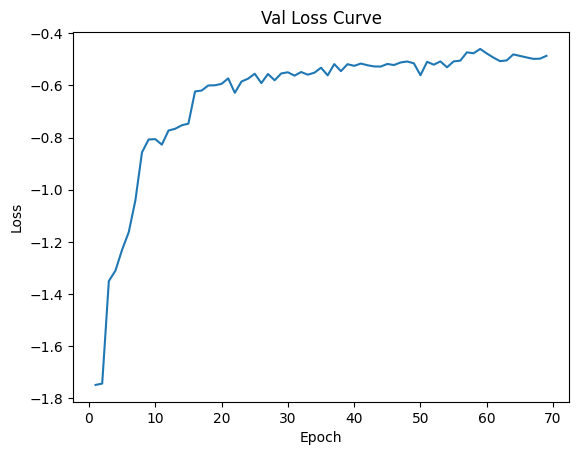

Student weights and architecture saved and exported for lambda: 5


100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:22<00:00,  1.65it/s]


*******Epoch 0: loss - 0.5517080042730359


100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:22<00:00,  1.65it/s]


*******Epoch 1: loss - 0.3168609517023844


100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:22<00:00,  1.65it/s]


*******Epoch 2: loss - 0.20787299818852367


100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:40<00:00,  1.35it/s]


Average Pretrain Adversary epoch loss:  0.5011127084931907


100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:40<00:00,  1.35it/s]


Average Pretrain Adversary epoch loss:  0.5010179311913603


100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:40<00:00,  1.35it/s]


Average Pretrain Adversary epoch loss:  0.5010989680886269


100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:55<00:00,  2.43it/s]


Average Adversary epoch loss: 0.4857686582733603


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.39it/s]


*****Epoch 1/100*****
*****Train Loss: -1.271644 Val Loss: -1.102871*****
*****Validation Accuracy: 64.42%*****
*****Total Avg Disparity: 0.14035449955427773*****

Class Team_Sports: Recall Difference = 0.05337770771296779
Class Celebration: Recall Difference = -0.054325854052961364
Class Parade: Recall Difference = 0.04513341507561164
Class Waiter_Or_Waitress: Recall Difference = -0.26530612244897966
Class Individual_Sports: Recall Difference = -0.11425645527028017
Class Surgeons: Recall Difference = -0.07612712490761275
Class Spa: Recall Difference = -0.21985815602836883
Class Law_Enforcement: Recall Difference = 0.06766655040111624
Class Business: Recall Difference = 0.011082693947144118
Class Dresses: Recall Difference = -0.705521472392638
Class Water Activities: Recall Difference = 0.04895974672094072
Class Picnic: Recall Difference = -0.09150326797385622
Class Rescue: Recall Difference = 0.09569620253164551
Class Cheering: Recall Difference = -0.12090834697217673
Class Performanc

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:56<00:00,  2.39it/s]


Average Adversary epoch loss: 0.441605292918051


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.41it/s]


*****Epoch 2/100*****
*****Train Loss: -1.140115 Val Loss: -0.936645*****
*****Validation Accuracy: 65.34%*****
*****Total Avg Disparity: 0.15085093833097263*****

Class Team_Sports: Recall Difference = 0.04737548899398625
Class Celebration: Recall Difference = -0.11112795633717404
Class Parade: Recall Difference = 0.11303789338471426
Class Waiter_Or_Waitress: Recall Difference = -0.26530612244897955
Class Individual_Sports: Recall Difference = -0.13546924146002481
Class Surgeons: Recall Difference = 0.05173688100517376
Class Spa: Recall Difference = -0.4326241134751773
Class Law_Enforcement: Recall Difference = 0.11242878735030826
Class Business: Recall Difference = -0.06969309462915607
Class Dresses: Recall Difference = -0.7177914110429449
Class Water Activities: Recall Difference = 0.07858435097241068
Class Picnic: Recall Difference = -0.10457516339869283
Class Rescue: Recall Difference = 0.03569620253164563
Class Cheering: Recall Difference = -0.10270049099836331
Class Performance_

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:57<00:00,  2.37it/s]


Average Adversary epoch loss: 0.3547776849830852


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.39it/s]


*****Epoch 3/100*****
*****Train Loss: -0.827633 Val Loss: -0.627413*****
*****Validation Accuracy: 65.31%*****
*****Total Avg Disparity: 0.13479668887820134*****

Class Team_Sports: Recall Difference = 0.07397676183803348
Class Celebration: Recall Difference = -0.09237921972912877
Class Parade: Recall Difference = 0.07555322006189069
Class Waiter_Or_Waitress: Recall Difference = -0.20879120879120872
Class Individual_Sports: Recall Difference = -0.10734401287396667
Class Surgeons: Recall Difference = -0.09460458240946046
Class Spa: Recall Difference = 0.049645390070921835
Class Law_Enforcement: Recall Difference = 0.10533658876874763
Class Business: Recall Difference = 0.02941176470588236
Class Dresses: Recall Difference = -0.7484662576687117
Class Water Activities: Recall Difference = 0.06365897783808228
Class Picnic: Recall Difference = 0.04575163398692805
Class Rescue: Recall Difference = 0.12632911392405066
Class Cheering: Recall Difference = -0.1397299509001637
Class Performance_A

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:57<00:00,  2.37it/s]


Average Adversary epoch loss: 0.2636214825598633


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.38it/s]


*****Epoch 4/100*****
*****Train Loss: -0.621446 Val Loss: -0.472771*****
*****Validation Accuracy: 65.92%*****
*****Total Avg Disparity: 0.12604861321664582*****

Class Team_Sports: Recall Difference = 0.03839551585216339
Class Celebration: Recall Difference = -0.08409136850616528
Class Parade: Recall Difference = 0.09721492380451913
Class Waiter_Or_Waitress: Recall Difference = -0.32417582417582413
Class Individual_Sports: Recall Difference = -0.06956330919464582
Class Surgeons: Recall Difference = -0.10569105691056901
Class Spa: Recall Difference = -0.14184397163120577
Class Law_Enforcement: Recall Difference = 0.11952098593186855
Class Business: Recall Difference = -0.020460358056266004
Class Dresses: Recall Difference = -0.6914110429447853
Class Water Activities: Recall Difference = 0.011080958842152877
Class Picnic: Recall Difference = -0.10457516339869288
Class Rescue: Recall Difference = 0.09037974683544314
Class Cheering: Recall Difference = -0.03477905073649756
Class Performa

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:57<00:00,  2.38it/s]


Average Adversary epoch loss: 0.21683270862216458


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.39it/s]


*****Epoch 5/100*****
*****Train Loss: -0.610984 Val Loss: -0.473810*****
*****Validation Accuracy: 64.91%*****
*****Total Avg Disparity: 0.13233877793129262*****

Class Team_Sports: Recall Difference = 0.06005721959479193
Class Celebration: Recall Difference = -0.10369921164342022
Class Parade: Recall Difference = 0.030653354352776274
Class Waiter_Or_Waitress: Recall Difference = -0.24489795918367352
Class Individual_Sports: Recall Difference = -0.0739887352790578
Class Surgeons: Recall Difference = -0.19142645971914257
Class Spa: Recall Difference = -0.07801418439716334
Class Law_Enforcement: Recall Difference = 0.10975467968840846
Class Business: Recall Difference = -0.06734867860187554
Class Dresses: Recall Difference = -0.6871165644171779
Class Water Activities: Recall Difference = 0.011533242876526462
Class Picnic: Recall Difference = -0.15032679738562094
Class Rescue: Recall Difference = -0.0035443037974683955
Class Cheering: Recall Difference = -0.10924713584288054
Class Perfor

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:56<00:00,  2.39it/s]


Average Adversary epoch loss: 0.21645440095487764


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.41it/s]


*****Epoch 6/100*****
*****Train Loss: -0.603118 Val Loss: -0.455148*****
*****Validation Accuracy: 65.37%*****
*****Total Avg Disparity: 0.13304023505750914*****

Class Team_Sports: Recall Difference = 0.0690371927366148
Class Celebration: Recall Difference = -0.09829189407721856
Class Parade: Recall Difference = 0.07123255678168983
Class Waiter_Or_Waitress: Recall Difference = -0.27786499215070626
Class Individual_Sports: Recall Difference = -0.05109355570185059
Class Surgeons: Recall Difference = -0.1123429416112342
Class Spa: Recall Difference = -0.05673758865248235
Class Law_Enforcement: Recall Difference = 0.1261481223113593
Class Business: Recall Difference = -0.060741687979539605
Class Dresses: Recall Difference = -0.6809815950920246
Class Water Activities: Recall Difference = 0.03403437358661243
Class Picnic: Recall Difference = -0.130718954248366
Class Rescue: Recall Difference = 0.09772151898734172
Class Cheering: Recall Difference = -0.056055646481178445
Class Performance_A

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:57<00:00,  2.38it/s]


Average Adversary epoch loss: 0.20807047659421668


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.39it/s]


*****Epoch 7/100*****
*****Train Loss: -0.567788 Val Loss: -0.417832*****
*****Validation Accuracy: 66.35%*****
*****Total Avg Disparity: 0.14946755004959272*****

Class Team_Sports: Recall Difference = 0.054615519355403874
Class Celebration: Recall Difference = -0.08409136850616528
Class Parade: Recall Difference = 0.06679511881824018
Class Waiter_Or_Waitress: Recall Difference = -0.3265306122448979
Class Individual_Sports: Recall Difference = -0.08748445614805067
Class Surgeons: Recall Difference = -0.11234294161123426
Class Spa: Recall Difference = -0.39007092198581567
Class Law_Enforcement: Recall Difference = 0.10091849784908724
Class Business: Recall Difference = 0.043691389599317954
Class Dresses: Recall Difference = -0.6607361963190185
Class Water Activities: Recall Difference = 0.018882858435097294
Class Picnic: Recall Difference = -0.0915032679738561
Class Rescue: Recall Difference = 0.05974683544303794
Class Cheering: Recall Difference = -0.07937806873977082
Class Performanc

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:56<00:00,  2.39it/s]


Average Adversary epoch loss: 0.1948400215957971


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.39it/s]


*****Epoch 8/100*****
*****Train Loss: -0.531535 Val Loss: -0.366513*****
*****Validation Accuracy: 66.78%*****
*****Total Avg Disparity: 0.14388549560641195*****

Class Team_Sports: Recall Difference = 0.07161791323641042
Class Celebration: Recall Difference = -0.10910652920962194
Class Parade: Recall Difference = 0.07695451626087468
Class Waiter_Or_Waitress: Recall Difference = -0.30612244897959184
Class Individual_Sports: Recall Difference = -0.07589057128227639
Class Surgeons: Recall Difference = -0.1426459719142646
Class Spa: Recall Difference = -0.326241134751773
Class Law_Enforcement: Recall Difference = 0.07964190210440647
Class Business: Recall Difference = 0.02941176470588236
Class Dresses: Recall Difference = -0.6484662576687117
Class Water Activities: Recall Difference = -0.0033921302578018286
Class Picnic: Recall Difference = -0.07189542483660127
Class Rescue: Recall Difference = 0.06835443037974687
Class Cheering: Recall Difference = -0.059124386252045746
Class Performanc

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:56<00:00,  2.39it/s]


Average Adversary epoch loss: 0.18805900736547568


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.40it/s]


*****Epoch 9/100*****
*****Train Loss: -0.526273 Val Loss: -0.355721*****
*****Validation Accuracy: 66.58%*****
*****Total Avg Disparity: 0.14299138691216742*****

Class Team_Sports: Recall Difference = 0.04355695685175476
Class Celebration: Recall Difference = -0.0688801293713362
Class Parade: Recall Difference = 0.07835581245985868
Class Waiter_Or_Waitress: Recall Difference = -0.26530612244897966
Class Individual_Sports: Recall Difference = -0.0863872430692707
Class Surgeons: Recall Difference = -0.11825572801182554
Class Spa: Recall Difference = -0.3687943262411347
Class Law_Enforcement: Recall Difference = 0.07696779444250679
Class Business: Recall Difference = 0.004475703324808178
Class Dresses: Recall Difference = -0.5607361963190183
Class Water Activities: Recall Difference = 0.04138398914518315
Class Picnic: Recall Difference = -0.019607843137254832
Class Rescue: Recall Difference = 0.15367088607594936
Class Cheering: Recall Difference = -0.12847790507364976
Class Performance_

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:57<00:00,  2.38it/s]


Average Adversary epoch loss: 0.1826299524811261


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.39it/s]


*****Epoch 10/100*****
*****Train Loss: -0.521926 Val Loss: -0.362803*****
*****Validation Accuracy: 66.55%*****
*****Total Avg Disparity: 0.15127346588242407*****

Class Team_Sports: Recall Difference = 0.04529689963215955
Class Celebration: Recall Difference = -0.09050939963614307
Class Parade: Recall Difference = 0.0422724353360191
Class Waiter_Or_Waitress: Recall Difference = -0.2755102040816326
Class Individual_Sports: Recall Difference = -0.041986687147977486
Class Surgeons: Recall Difference = -0.20990391722099033
Class Spa: Recall Difference = -0.3687943262411348
Class Law_Enforcement: Recall Difference = 0.16916637600279016
Class Business: Recall Difference = -0.01406649616368294
Class Dresses: Recall Difference = -0.6607361963190185
Class Water Activities: Recall Difference = 0.018656716417910446
Class Picnic: Recall Difference = -0.013071895424836666
Class Rescue: Recall Difference = 0.1377215189873417
Class Cheering: Recall Difference = -0.03232405891980361
Class Performanc

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:57<00:00,  2.37it/s]


Average Adversary epoch loss: 0.17814780930605004


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.39it/s]


*****Epoch 11/100*****
*****Train Loss: -0.499293 Val Loss: -0.347027*****
*****Validation Accuracy: 65.89%*****
*****Total Avg Disparity: 0.1652487814502967*****

Class Team_Sports: Recall Difference = 0.03727447889297597
Class Celebration: Recall Difference = -0.06008692136648475
Class Parade: Recall Difference = 0.016290068313189687
Class Waiter_Or_Waitress: Recall Difference = -0.19858712715855564
Class Individual_Sports: Recall Difference = -0.08609465291492946
Class Surgeons: Recall Difference = -0.14264597191426448
Class Spa: Recall Difference = -0.39007092198581567
Class Law_Enforcement: Recall Difference = 0.14742471805603985
Class Business: Recall Difference = 0.025149190110826947
Class Dresses: Recall Difference = -0.7730061349693251
Class Water Activities: Recall Difference = 0.07146087743102658
Class Picnic: Recall Difference = -0.2549019607843137
Class Rescue: Recall Difference = 0.05240506329113931
Class Cheering: Recall Difference = -0.06976268412438635
Class Performanc

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:57<00:00,  2.35it/s]


Average Adversary epoch loss: 0.17533210429417737


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.38it/s]


*****Epoch 12/100*****
*****Train Loss: -0.491278 Val Loss: -0.317524*****
*****Validation Accuracy: 66.09%*****
*****Total Avg Disparity: 0.1571693528404033*****

Class Team_Sports: Recall Difference = 0.05253692999357751
Class Celebration: Recall Difference = -0.06650495249646243
Class Parade: Recall Difference = 0.030711741694400607
Class Waiter_Or_Waitress: Recall Difference = -0.17032967032967028
Class Individual_Sports: Recall Difference = -0.12361934020920207
Class Surgeons: Recall Difference = -0.10643015521064292
Class Spa: Recall Difference = -0.3687943262411348
Class Law_Enforcement: Recall Difference = 0.1102197418904779
Class Business: Recall Difference = 0.029624893435635125
Class Dresses: Recall Difference = -0.7055214723926381
Class Water Activities: Recall Difference = 0.018656716417910446
Class Picnic: Recall Difference = -0.11111111111111105
Class Rescue: Recall Difference = 0.17898734177215192
Class Cheering: Recall Difference = -0.13461538461538464
Class Performanc

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:57<00:00,  2.38it/s]


Average Adversary epoch loss: 0.17288446897531257


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.31it/s]


*****Epoch 13/100*****
*****Train Loss: -0.491987 Val Loss: -0.330372*****
*****Validation Accuracy: 66.58%*****
*****Total Avg Disparity: 0.14811103442759574*****

Class Team_Sports: Recall Difference = 0.044456121912769375
Class Celebration: Recall Difference = -0.08863957954315749
Class Parade: Recall Difference = 0.07117416944006527
Class Waiter_Or_Waitress: Recall Difference = -0.21114599686028246
Class Individual_Sports: Recall Difference = -0.06707629288274441
Class Surgeons: Recall Difference = -0.10643015521064292
Class Spa: Recall Difference = -0.4539007092198583
Class Law_Enforcement: Recall Difference = 0.1381234740146493
Class Business: Recall Difference = 0.017689684569479835
Class Dresses: Recall Difference = -0.803680981595092
Class Water Activities: Recall Difference = 0.026232473993668126
Class Picnic: Recall Difference = -0.1307189542483661
Class Rescue: Recall Difference = 0.0870886075949367
Class Cheering: Recall Difference = -0.02720949263502459
Class Performance_

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:58<00:00,  2.31it/s]


Average Adversary epoch loss: 0.17037600634948297


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.35it/s]


*****Epoch 14/100*****
*****Train Loss: -0.480694 Val Loss: -0.310650*****
*****Validation Accuracy: 66.93%*****
*****Total Avg Disparity: 0.1520491362777584*****

Class Team_Sports: Recall Difference = 0.0539966135341855
Class Celebration: Recall Difference = -0.10961188599151006
Class Parade: Recall Difference = 0.07987388334209133
Class Waiter_Or_Waitress: Recall Difference = -0.23940345368916804
Class Individual_Sports: Recall Difference = -0.051349572086899165
Class Surgeons: Recall Difference = -0.12490761271249073
Class Spa: Recall Difference = -0.099290780141844
Class Law_Enforcement: Recall Difference = 0.14742471805603985
Class Business: Recall Difference = -0.02152600170502983
Class Dresses: Recall Difference = -0.7975460122699386
Class Water Activities: Recall Difference = 0.06343283582089565
Class Picnic: Recall Difference = -0.16339869281045744
Class Rescue: Recall Difference = 0.12835443037974686
Class Cheering: Recall Difference = -0.16550736497545016
Class Performance_

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:00<00:00,  2.26it/s]


Average Adversary epoch loss: 0.1686687054222121


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.31it/s]


*****Epoch 15/100*****
*****Train Loss: -0.478422 Val Loss: -0.299099*****
*****Validation Accuracy: 66.38%*****
*****Total Avg Disparity: 0.15177793231347705*****

Class Team_Sports: Recall Difference = 0.04967595025398486
Class Celebration: Recall Difference = -0.03845765110167776
Class Parade: Recall Difference = 0.058153792257838455
Class Waiter_Or_Waitress: Recall Difference = -0.23704866562009408
Class Individual_Sports: Recall Difference = -0.042535293687367526
Class Surgeons: Recall Difference = -0.08795269770879521
Class Spa: Recall Difference = -0.32624113475177313
Class Law_Enforcement: Recall Difference = 0.14300662713637957
Class Business: Recall Difference = -0.07374254049445872
Class Dresses: Recall Difference = -0.7730061349693251
Class Water Activities: Recall Difference = 0.04895974672094083
Class Picnic: Recall Difference = -0.15032679738562094
Class Rescue: Recall Difference = 0.11443037974683543
Class Cheering: Recall Difference = -0.031710310965630095
Class Perfor

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:00<00:00,  2.25it/s]


Average Adversary epoch loss: 0.16556348892695763


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.31it/s]


*****Epoch 16/100*****
*****Train Loss: -0.469408 Val Loss: -0.299036*****
*****Validation Accuracy: 66.81%*****
*****Total Avg Disparity: 0.12210618131462235*****

Class Team_Sports: Recall Difference = 0.03345594675074448
Class Celebration: Recall Difference = -0.059581564584596625
Class Parade: Recall Difference = 0.07409353652128214
Class Waiter_Or_Waitress: Recall Difference = -0.2778649921507065
Class Individual_Sports: Recall Difference = -0.06846609611586563
Class Surgeons: Recall Difference = -0.0694752402069474
Class Spa: Recall Difference = -0.09929078014184411
Class Law_Enforcement: Recall Difference = 0.13812347401464942
Class Business: Recall Difference = 0.00788576300085242
Class Dresses: Recall Difference = -0.5852760736196319
Class Water Activities: Recall Difference = 0.06388511985526912
Class Picnic: Recall Difference = -0.0915032679738561
Class Rescue: Recall Difference = 0.09037974683544309
Class Cheering: Recall Difference = -0.12500000000000006
Class Performance_

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:59<00:00,  2.28it/s]


Average Adversary epoch loss: 0.16466866537709446


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:20<00:00,  2.25it/s]


*****Epoch 17/100*****
*****Train Loss: -0.460417 Val Loss: -0.298122*****
*****Validation Accuracy: 66.61%*****
*****Total Avg Disparity: 0.11655436971616698*****

Class Team_Sports: Recall Difference = 0.044175862672972466
Class Celebration: Recall Difference = 0.005659995957145725
Class Parade: Recall Difference = 0.06685350615986463
Class Waiter_Or_Waitress: Recall Difference = -0.22919937205651486
Class Individual_Sports: Recall Difference = -0.07892619413356738
Class Surgeons: Recall Difference = -0.03325942350332589
Class Spa: Recall Difference = -0.120567375886525
Class Law_Enforcement: Recall Difference = 0.1075456342285781
Class Business: Recall Difference = -0.0347399829497016
Class Dresses: Recall Difference = -0.6668711656441719
Class Water Activities: Recall Difference = 0.06411126187245586
Class Picnic: Recall Difference = -0.11111111111111116
Class Rescue: Recall Difference = 0.07240506329113927
Class Cheering: Recall Difference = -0.11988543371522098
Class Performance_

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:59<00:00,  2.29it/s]


Average Adversary epoch loss: 0.16262442706262364


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:20<00:00,  2.29it/s]


*****Epoch 18/100*****
*****Train Loss: -0.455792 Val Loss: -0.286952*****
*****Validation Accuracy: 66.49%*****
*****Total Avg Disparity: 0.11848079449410942*****

Class Team_Sports: Recall Difference = 0.05517603783499736
Class Celebration: Recall Difference = -0.030675156660602387
Class Parade: Recall Difference = 0.05231505809540493
Class Waiter_Or_Waitress: Recall Difference = -0.2676609105180533
Class Individual_Sports: Recall Difference = -0.11451247165532885
Class Surgeons: Recall Difference = -0.1123429416112342
Class Spa: Recall Difference = -0.05673758865248235
Class Law_Enforcement: Recall Difference = 0.10801069643064753
Class Business: Recall Difference = 0.05136402387041783
Class Dresses: Recall Difference = -0.5546012269938649
Class Water Activities: Recall Difference = 0.06411126187245586
Class Picnic: Recall Difference = -0.07189542483660127
Class Rescue: Recall Difference = 0.028354430379746776
Class Cheering: Recall Difference = -0.06321603927986907
Class Performanc

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:00<00:00,  2.26it/s]


Average Adversary epoch loss: 0.1631298860644593


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:20<00:00,  2.26it/s]


*****Epoch 19/100*****
*****Train Loss: -0.456668 Val Loss: -0.251777*****
*****Validation Accuracy: 66.58%*****
*****Total Avg Disparity: 0.1445954793184136*****

Class Team_Sports: Recall Difference = 0.04041571787236553
Class Celebration: Recall Difference = -0.047756215888417275
Class Parade: Recall Difference = 0.046651485957844296
Class Waiter_Or_Waitress: Recall Difference = -0.33202511773940346
Class Individual_Sports: Recall Difference = -0.08858166922683042
Class Surgeons: Recall Difference = -0.1729490022172948
Class Spa: Recall Difference = -0.41134751773049666
Class Law_Enforcement: Recall Difference = 0.15986513196139973
Class Business: Recall Difference = -0.06287297527706726
Class Dresses: Recall Difference = -0.47300613496932514
Class Water Activities: Recall Difference = 0.011533242876526462
Class Picnic: Recall Difference = -0.1437908496732026
Class Rescue: Recall Difference = 0.03974683544303803
Class Cheering: Recall Difference = -0.12090834697217673
Class Performa

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:59<00:00,  2.30it/s]


Average Adversary epoch loss: 0.16019322394448168


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.34it/s]


*****Epoch 20/100*****
*****Train Loss: -0.461410 Val Loss: -0.280132*****
*****Validation Accuracy: 66.52%*****
*****Total Avg Disparity: 0.1298902854265673*****

Class Team_Sports: Recall Difference = 0.035476148770946514
Class Celebration: Recall Difference = -0.059581564584596625
Class Parade: Recall Difference = 0.07695451626087457
Class Waiter_Or_Waitress: Recall Difference = -0.2676609105180533
Class Individual_Sports: Recall Difference = -0.10928242264647803
Class Surgeons: Recall Difference = -0.08795269770879521
Class Spa: Recall Difference = -0.05673758865248235
Class Law_Enforcement: Recall Difference = 0.1664922683408906
Class Business: Recall Difference = 0.018755328218243772
Class Dresses: Recall Difference = -0.6668711656441718
Class Water Activities: Recall Difference = 0.04918588873812746
Class Picnic: Recall Difference = -0.07189542483660138
Class Rescue: Recall Difference = 0.09772151898734177
Class Cheering: Recall Difference = -0.06976268412438624
Class Performanc

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:58<00:00,  2.34it/s]


Average Adversary epoch loss: 0.16223581129794612


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.31it/s]


*****Epoch 21/100*****
*****Train Loss: -0.451924 Val Loss: -0.279237*****
*****Validation Accuracy: 67.16%*****
*****Total Avg Disparity: 0.14605834069964851*****

Class Team_Sports: Recall Difference = 0.049617562912360746
Class Celebration: Recall Difference = -0.030169799878714265
Class Parade: Recall Difference = 0.02785076195480829
Class Waiter_Or_Waitress: Recall Difference = -0.36499215070643654
Class Individual_Sports: Recall Difference = -0.06872211250091442
Class Surgeons: Recall Difference = -0.05099778270509969
Class Spa: Recall Difference = -0.41134751773049666
Class Law_Enforcement: Recall Difference = 0.07475874898267632
Class Business: Recall Difference = -0.008525149190110826
Class Dresses: Recall Difference = -0.7300613496932515
Class Water Activities: Recall Difference = 0.0565355042966984
Class Picnic: Recall Difference = -0.0326797385620915
Class Rescue: Recall Difference = 0.130379746835443
Class Cheering: Recall Difference = -0.0718085106382978
Class Performance

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:59<00:00,  2.27it/s]


Average Adversary epoch loss: 0.1596971190918018


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.31it/s]


*****Epoch 22/100*****
*****Train Loss: -0.460718 Val Loss: -0.277470*****
*****Validation Accuracy: 66.78%*****
*****Total Avg Disparity: 0.13582242392603*****

Class Team_Sports: Recall Difference = 0.025655397909733257
Class Celebration: Recall Difference = 0.015463917525773141
Class Parade: Recall Difference = 0.09143457698370983
Class Waiter_Or_Waitress: Recall Difference = -0.24725274725274715
Class Individual_Sports: Recall Difference = -0.09768853778070363
Class Surgeons: Recall Difference = -0.03325942350332589
Class Spa: Recall Difference = -0.347517730496454
Class Law_Enforcement: Recall Difference = 0.10580165097081728
Class Business: Recall Difference = 0.023017902813299296
Class Dresses: Recall Difference = -0.7098159509202454
Class Water Activities: Recall Difference = 0.011307100859339614
Class Picnic: Recall Difference = -0.10457516339869283
Class Rescue: Recall Difference = 0.11772151898734168
Class Cheering: Recall Difference = -0.10617839607201313
Class Performance_

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:57<00:00,  2.38it/s]


Average Adversary epoch loss: 0.1605410677216509


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.41it/s]


*****Epoch 23/100*****
*****Train Loss: -0.451259 Val Loss: -0.269276*****
*****Validation Accuracy: 66.58%*****
*****Total Avg Disparity: 0.12262762419122519*****

Class Team_Sports: Recall Difference = 0.05775675833479321
Class Celebration: Recall Difference = -0.028653729533050343
Class Parade: Recall Difference = 0.08133356688269999
Class Waiter_Or_Waitress: Recall Difference = -0.226844583987441
Class Individual_Sports: Recall Difference = -0.07728037451539749
Class Surgeons: Recall Difference = -0.05764966740576494
Class Spa: Recall Difference = -0.099290780141844
Class Law_Enforcement: Recall Difference = 0.025578421113824024
Class Business: Recall Difference = -0.058610400682011954
Class Dresses: Recall Difference = -0.7975460122699386
Class Water Activities: Recall Difference = -0.0036182722749886764
Class Picnic: Recall Difference = 0.09150326797385633
Class Rescue: Recall Difference = 0.06303797468354433
Class Cheering: Recall Difference = -0.06976268412438624
Class Performa

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:56<00:00,  2.39it/s]


Average Adversary epoch loss: 0.15935707519597866


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:18<00:00,  2.42it/s]


*****Epoch 24/100*****
*****Train Loss: -0.453591 Val Loss: -0.264078*****
*****Validation Accuracy: 66.20%*****
*****Total Avg Disparity: 0.11851056518499126*****

Class Team_Sports: Recall Difference = 0.07891633093945216
Class Celebration: Recall Difference = -0.06989084293511216
Class Parade: Recall Difference = 0.06393413907864776
Class Waiter_Or_Waitress: Recall Difference = -0.2574568288854002
Class Individual_Sports: Recall Difference = -0.05906663740765117
Class Surgeons: Recall Difference = -0.08795269770879521
Class Spa: Recall Difference = -0.09929078014184411
Class Law_Enforcement: Recall Difference = 0.08894314614579701
Class Business: Recall Difference = 0.010017050298380181
Class Dresses: Recall Difference = -0.7730061349693252
Class Water Activities: Recall Difference = 0.048733604703753874
Class Picnic: Recall Difference = -0.019607843137254832
Class Rescue: Recall Difference = 0.09037974683544309
Class Cheering: Recall Difference = -0.10270049099836331
Class Performa

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:56<00:00,  2.39it/s]


Average Adversary epoch loss: 0.15750572567476945


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.42it/s]


*****Epoch 25/100*****
*****Train Loss: -0.448901 Val Loss: -0.253846*****
*****Validation Accuracy: 66.38%*****
*****Total Avg Disparity: 0.1366175999336133*****

Class Team_Sports: Recall Difference = 0.05169615227418689
Class Celebration: Recall Difference = -0.0663533454618962
Class Parade: Recall Difference = 0.05091376189642094
Class Waiter_Or_Waitress: Recall Difference = -0.3343799058084772
Class Individual_Sports: Recall Difference = -0.1440275034745081
Class Surgeons: Recall Difference = -0.0694752402069474
Class Spa: Recall Difference = -0.07801418439716334
Class Law_Enforcement: Recall Difference = 0.11242878735030803
Class Business: Recall Difference = -0.05754475703324813
Class Dresses: Recall Difference = -0.554601226993865
Class Water Activities: Recall Difference = 0.018882858435097183
Class Picnic: Recall Difference = -0.3856209150326797
Class Rescue: Recall Difference = 0.09569620253164551
Class Cheering: Recall Difference = -0.11027004909983623
Class Performance_And

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:56<00:00,  2.40it/s]


Average Adversary epoch loss: 0.15738840603872256


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:18<00:00,  2.43it/s]


*****Epoch 26/100*****
*****Train Loss: -0.448875 Val Loss: -0.244369*****
*****Validation Accuracy: 66.81%*****
*****Total Avg Disparity: 0.14560126798813358*****

Class Team_Sports: Recall Difference = 0.05545629707479438
Class Celebration: Recall Difference = -0.04725085910652904
Class Parade: Recall Difference = 0.09861622000350334
Class Waiter_Or_Waitress: Recall Difference = -0.4136577708006278
Class Individual_Sports: Recall Difference = -0.08031599736668849
Class Surgeons: Recall Difference = -0.0761271249076127
Class Spa: Recall Difference = -0.12056737588652477
Class Law_Enforcement: Recall Difference = 0.09603534472735731
Class Business: Recall Difference = 0.018542199488491007
Class Dresses: Recall Difference = -0.7668711656441718
Class Water Activities: Recall Difference = 0.011307100859339725
Class Picnic: Recall Difference = -0.21568627450980393
Class Rescue: Recall Difference = 0.03443037974683549
Class Cheering: Recall Difference = -0.11538461538461536
Class Performanc

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:56<00:00,  2.39it/s]


Average Adversary epoch loss: 0.15600431677611434


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:18<00:00,  2.43it/s]


*****Epoch 27/100*****
*****Train Loss: -0.446365 Val Loss: -0.242009*****
*****Validation Accuracy: 66.72%*****
*****Total Avg Disparity: 0.13782480087394383*****

Class Team_Sports: Recall Difference = 0.03721609155135186
Class Celebration: Recall Difference = -0.014958560743885296
Class Parade: Recall Difference = 0.08845682256086862
Class Waiter_Or_Waitress: Recall Difference = -0.31397174254317106
Class Individual_Sports: Recall Difference = -0.04666812961743838
Class Surgeons: Recall Difference = -0.17960088691796
Class Spa: Recall Difference = -0.03546099290780136
Class Law_Enforcement: Recall Difference = 0.08673410068596699
Class Business: Recall Difference = -0.009590792838874651
Class Dresses: Recall Difference = -0.7036809815950921
Class Water Activities: Recall Difference = -0.01899592944369055
Class Picnic: Recall Difference = -0.14379084967320266
Class Rescue: Recall Difference = 0.10835443037974679
Class Cheering: Recall Difference = -0.10167757774140751
Class Performan

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:56<00:00,  2.39it/s]


Average Adversary epoch loss: 0.1569426338571836


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:18<00:00,  2.43it/s]


*****Epoch 28/100*****
*****Train Loss: -0.448839 Val Loss: -0.244836*****
*****Validation Accuracy: 66.46%*****
*****Total Avg Disparity: 0.12104418042860904*****

Class Team_Sports: Recall Difference = 0.08491854965843415
Class Celebration: Recall Difference = 0.005659995957145725
Class Parade: Recall Difference = 0.022012027792374655
Class Waiter_Or_Waitress: Recall Difference = -0.2496075353218209
Class Individual_Sports: Recall Difference = -0.10595420964084556
Class Surgeons: Recall Difference = -0.008869179600886845
Class Spa: Recall Difference = -0.05673758865248235
Class Law_Enforcement: Recall Difference = 0.11952098593186844
Class Business: Recall Difference = -0.05647911338448419
Class Dresses: Recall Difference = -0.6116564417177914
Class Water Activities: Recall Difference = 0.02600633197648128
Class Picnic: Recall Difference = -0.2549019607843137
Class Rescue: Recall Difference = 0.08506329113924055
Class Cheering: Recall Difference = -0.08551554828150565
Class Performan

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:55<00:00,  2.44it/s]


Average Adversary epoch loss: 0.15726779499912963


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.41it/s]


*****Epoch 29/100*****
*****Train Loss: -0.448737 Val Loss: -0.257128*****
*****Validation Accuracy: 66.78%*****
*****Total Avg Disparity: 0.11668307703000748*****

Class Team_Sports: Recall Difference = 0.03895603433175687
Class Celebration: Recall Difference = -0.002627855265817769
Class Parade: Recall Difference = 0.05961347579844678
Class Waiter_Or_Waitress: Recall Difference = -0.30612244897959184
Class Individual_Sports: Recall Difference = -0.10430839002267578
Class Surgeons: Recall Difference = -0.014781966001478075
Class Spa: Recall Difference = 0.049645390070921946
Class Law_Enforcement: Recall Difference = 0.12219509359376801
Class Business: Recall Difference = -0.09995737425404938
Class Dresses: Recall Difference = -0.685276073619632
Class Water Activities: Recall Difference = 0.05630936227951144
Class Picnic: Recall Difference = 1.1102230246251565e-16
Class Rescue: Recall Difference = 0.009113924050632882
Class Cheering: Recall Difference = -0.07835515548281502
Class Perfo

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:56<00:00,  2.40it/s]


Average Adversary epoch loss: 0.15628071288194725


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.41it/s]


*****Epoch 30/100*****
*****Train Loss: -0.446115 Val Loss: -0.239846*****
*****Validation Accuracy: 67.04%*****
*****Total Avg Disparity: 0.14783075659881614*****

Class Team_Sports: Recall Difference = 0.04759736089215849
Class Celebration: Recall Difference = -0.04927228623408125
Class Parade: Recall Difference = 0.013370701231972926
Class Waiter_Or_Waitress: Recall Difference = -0.2755102040816326
Class Individual_Sports: Recall Difference = -0.10485699656206571
Class Surgeons: Recall Difference = -0.14855875831485588
Class Spa: Recall Difference = -0.347517730496454
Class Law_Enforcement: Recall Difference = 0.11242878735030803
Class Business: Recall Difference = -0.04006820119352095
Class Dresses: Recall Difference = -0.7668711656441718
Class Water Activities: Recall Difference = 0.033582089552238736
Class Picnic: Recall Difference = -0.07189542483660127
Class Rescue: Recall Difference = 0.16101265822784805
Class Cheering: Recall Difference = 0.012274959083469705
Class Performanc

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:56<00:00,  2.39it/s]


Average Adversary epoch loss: 0.1556491967948044


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:18<00:00,  2.43it/s]


*****Epoch 31/100*****
*****Train Loss: -0.445863 Val Loss: -0.244851*****
*****Validation Accuracy: 65.92%*****
*****Total Avg Disparity: 0.12036135720514823*****

Class Team_Sports: Recall Difference = 0.059776960354995134
Class Celebration: Recall Difference = -0.10910652920962194
Class Parade: Recall Difference = 0.0784141998014829
Class Waiter_Or_Waitress: Recall Difference = -0.2189952904238618
Class Individual_Sports: Recall Difference = -0.07150171896715685
Class Surgeons: Recall Difference = 0.01552106430155209
Class Spa: Recall Difference = -0.07801418439716334
Class Law_Enforcement: Recall Difference = 0.10533658876874774
Class Business: Recall Difference = -0.03687127024722936
Class Dresses: Recall Difference = -0.736196319018405
Class Water Activities: Recall Difference = 0.026232473993668015
Class Picnic: Recall Difference = -0.05228758169934644
Class Rescue: Recall Difference = 0.09772151898734172
Class Cheering: Recall Difference = -0.03334697217675936
Class Performance

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:57<00:00,  2.38it/s]


Average Adversary epoch loss: 0.15479981433600187


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:18<00:00,  2.43it/s]


*****Epoch 32/100*****
*****Train Loss: -0.443796 Val Loss: -0.243381*****
*****Validation Accuracy: 66.09%*****
*****Total Avg Disparity: 0.147797688125608*****

Class Team_Sports: Recall Difference = 0.050236468733578565
Class Celebration: Recall Difference = 0.021881948655750882
Class Parade: Recall Difference = 0.048111169498452844
Class Waiter_Or_Waitress: Recall Difference = -0.2755102040816326
Class Individual_Sports: Recall Difference = -0.08225440713919985
Class Surgeons: Recall Difference = -0.008130081300813052
Class Spa: Recall Difference = -0.2836879432624115
Class Law_Enforcement: Recall Difference = 0.14788978025810962
Class Business: Recall Difference = -0.03900255754475701
Class Dresses: Recall Difference = -0.7791411042944785
Class Water Activities: Recall Difference = 0.018656716417910557
Class Picnic: Recall Difference = -0.20261437908496727
Class Rescue: Recall Difference = 0.1430379746835443
Class Cheering: Recall Difference = -0.07283142389525371
Class Performanc

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:56<00:00,  2.40it/s]


Average Adversary epoch loss: 0.15473441582392244


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.42it/s]


*****Epoch 33/100*****
*****Train Loss: -0.442683 Val Loss: -0.249283*****
*****Validation Accuracy: 66.15%*****
*****Total Avg Disparity: 0.11401741849802491*****

Class Team_Sports: Recall Difference = 0.042155660652770544
Class Celebration: Recall Difference = -0.0007580351728319057
Class Parade: Recall Difference = 0.05961347579844678
Class Waiter_Or_Waitress: Recall Difference = -0.2676609105180534
Class Individual_Sports: Recall Difference = -0.1732499451393461
Class Surgeons: Recall Difference = -0.0813008130081303
Class Spa: Recall Difference = -0.03546099290780147
Class Law_Enforcement: Recall Difference = 0.14742471805603996
Class Business: Recall Difference = -0.02365728900255759
Class Dresses: Recall Difference = -0.6668711656441718
Class Water Activities: Recall Difference = 0.018656716417910446
Class Picnic: Recall Difference = 1.1102230246251565e-16
Class Rescue: Recall Difference = -0.0329113924050633
Class Cheering: Recall Difference = -0.08142389525368254
Class Perfor

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:56<00:00,  2.39it/s]


Average Adversary epoch loss: 0.15325881212073214


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.40it/s]


*****Epoch 34/100*****
*****Train Loss: -0.441359 Val Loss: -0.239703*****
*****Validation Accuracy: 66.18%*****
*****Total Avg Disparity: 0.10809066895619919*****

Class Team_Sports: Recall Difference = 0.06123664389560324
Class Celebration: Recall Difference = -0.04725085910652915
Class Parade: Recall Difference = 0.03077012903602494
Class Waiter_Or_Waitress: Recall Difference = -0.2676609105180533
Class Individual_Sports: Recall Difference = -0.02267573696145131
Class Surgeons: Recall Difference = -0.0509977827050998
Class Spa: Recall Difference = -0.03546099290780147
Class Law_Enforcement: Recall Difference = 0.15451691663760025
Class Business: Recall Difference = -0.026001705029838007
Class Dresses: Recall Difference = -0.6730061349693252
Class Water Activities: Recall Difference = 0.003731343283581934
Class Picnic: Recall Difference = -0.16339869281045744
Class Rescue: Recall Difference = 0.10303797468354436
Class Cheering: Recall Difference = -0.01657119476268415
Class Performan

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:56<00:00,  2.40it/s]


Average Adversary epoch loss: 0.15507269968443058


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:18<00:00,  2.44it/s]


*****Epoch 35/100*****
*****Train Loss: -0.435817 Val Loss: -0.229456*****
*****Validation Accuracy: 65.71%*****
*****Total Avg Disparity: 0.15910335190375713*****

Class Team_Sports: Recall Difference = 0.07195655981783156
Class Celebration: Recall Difference = 0.01243177683444513
Class Parade: Recall Difference = 0.07835581245985879
Class Waiter_Or_Waitress: Recall Difference = -0.31632653061224514
Class Individual_Sports: Recall Difference = -0.10624679979518692
Class Surgeons: Recall Difference = -0.09977827050997767
Class Spa: Recall Difference = -0.4326241134751773
Class Law_Enforcement: Recall Difference = 0.12393907685152883
Class Business: Recall Difference = 0.011082693947144007
Class Dresses: Recall Difference = -0.654601226993865
Class Water Activities: Recall Difference = 0.04115784712799653
Class Picnic: Recall Difference = -0.0915032679738561
Class Rescue: Recall Difference = 0.13898734177215188
Class Cheering: Recall Difference = -0.06976268412438619
Class Performance_A

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:56<00:00,  2.39it/s]


Average Adversary epoch loss: 0.15402151945540132


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:18<00:00,  2.46it/s]


*****Epoch 36/100*****
*****Train Loss: -0.443060 Val Loss: -0.231376*****
*****Validation Accuracy: 67.13%*****
*****Total Avg Disparity: 0.12507686468149432*****

Class Team_Sports: Recall Difference = 0.07419863373620594
Class Celebration: Recall Difference = -0.05265817667273098
Class Parade: Recall Difference = 0.06685350615986463
Class Waiter_Or_Waitress: Recall Difference = -0.25745682888540034
Class Individual_Sports: Recall Difference = -0.06901470265525556
Class Surgeons: Recall Difference = -0.014781966001478075
Class Spa: Recall Difference = -0.28368794326241137
Class Law_Enforcement: Recall Difference = 0.10533658876874774
Class Business: Recall Difference = 0.05349531116794548
Class Dresses: Recall Difference = -0.5975460122699385
Class Water Activities: Recall Difference = 0.011307100859339614
Class Picnic: Recall Difference = 0.1307189542483661
Class Rescue: Recall Difference = 0.03569620253164563
Class Cheering: Recall Difference = -0.11129296235679209
Class Performanc

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:56<00:00,  2.42it/s]


Average Adversary epoch loss: 0.15310356700245073


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.36it/s]


*****Epoch 37/100*****
*****Train Loss: -0.436715 Val Loss: -0.223429*****
*****Validation Accuracy: 66.90%*****
*****Total Avg Disparity: 0.1312967230673085*****

Class Team_Sports: Recall Difference = 0.07969872131721845
Class Celebration: Recall Difference = -0.0668587022437841
Class Parade: Recall Difference = 0.02498978221521586
Class Waiter_Or_Waitress: Recall Difference = -0.2370486656200942
Class Individual_Sports: Recall Difference = -0.053836588398800234
Class Surgeons: Recall Difference = 0.033998521803399906
Class Spa: Recall Difference = -0.09929078014184411
Class Law_Enforcement: Recall Difference = 0.09382629926752695
Class Business: Recall Difference = 0.04816709292412613
Class Dresses: Recall Difference = -0.7914110429447854
Class Water Activities: Recall Difference = 0.018656716417910557
Class Picnic: Recall Difference = -0.1437908496732026
Class Rescue: Recall Difference = 0.09037974683544303
Class Cheering: Recall Difference = -0.12950081833060556
Class Performance_

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:56<00:00,  2.41it/s]


Average Adversary epoch loss: 0.15388822741806507


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.41it/s]


*****Epoch 38/100*****
*****Train Loss: -0.437074 Val Loss: -0.230309*****
*****Validation Accuracy: 66.87%*****
*****Total Avg Disparity: 0.11457904901583686*****

Class Team_Sports: Recall Difference = 0.05343609505459235
Class Celebration: Recall Difference = -0.028653729533050343
Class Parade: Recall Difference = 0.05529281251824625
Class Waiter_Or_Waitress: Recall Difference = -0.27551020408163274
Class Individual_Sports: Recall Difference = -0.12332675005486049
Class Surgeons: Recall Difference = 0.039911308203991136
Class Spa: Recall Difference = -0.03546099290780147
Class Law_Enforcement: Recall Difference = 0.16160911521916055
Class Business: Recall Difference = -0.008525149190110826
Class Dresses: Recall Difference = -0.6668711656441718
Class Water Activities: Recall Difference = 0.01933514246947088
Class Picnic: Recall Difference = -0.05228758169934633
Class Rescue: Recall Difference = 0.030379746835443033
Class Cheering: Recall Difference = -0.06526186579378068
Class Perfor

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:56<00:00,  2.41it/s]


Average Adversary epoch loss: 0.1523180240765214


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:18<00:00,  2.44it/s]


*****Epoch 39/100*****
*****Train Loss: -0.446757 Val Loss: -0.237549*****
*****Validation Accuracy: 65.60%*****
*****Total Avg Disparity: 0.12567921888748534*****

Class Team_Sports: Recall Difference = 0.05259531733520173
Class Celebration: Recall Difference = -0.007024459268243355
Class Parade: Recall Difference = 0.08127517954107533
Class Waiter_Or_Waitress: Recall Difference = -0.20879120879120872
Class Individual_Sports: Recall Difference = -0.07369614512471656
Class Surgeons: Recall Difference = 0.00960827790096086
Class Spa: Recall Difference = 0.028368794326241176
Class Law_Enforcement: Recall Difference = 0.10266248110684806
Class Business: Recall Difference = 0.024083546462063232
Class Dresses: Recall Difference = -0.7607361963190183
Class Water Activities: Recall Difference = 0.04161013116236989
Class Picnic: Recall Difference = -0.21568627450980393
Class Rescue: Recall Difference = 0.11240506329113925
Class Cheering: Recall Difference = -0.15180032733224225
Class Performan

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:56<00:00,  2.42it/s]


Average Adversary epoch loss: 0.1547843499437851


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.42it/s]


*****Epoch 40/100*****
*****Train Loss: -0.441518 Val Loss: -0.233066*****
*****Validation Accuracy: 66.41%*****
*****Total Avg Disparity: 0.10203914064396413*****

Class Team_Sports: Recall Difference = 0.05573655631459107
Class Celebration: Recall Difference = -0.004143925611481802
Class Parade: Recall Difference = 0.07263385298067371
Class Waiter_Or_Waitress: Recall Difference = -0.2676609105180533
Class Individual_Sports: Recall Difference = -0.05467778509253163
Class Surgeons: Recall Difference = -0.014781966001478186
Class Spa: Recall Difference = -0.014184397163120699
Class Law_Enforcement: Recall Difference = 0.1855598186257411
Class Business: Recall Difference = 0.002344416027280527
Class Dresses: Recall Difference = -0.5975460122699388
Class Water Activities: Recall Difference = 0.018882858435097183
Class Picnic: Recall Difference = -0.130718954248366
Class Rescue: Recall Difference = 0.04506329113924046
Class Cheering: Recall Difference = -0.08040098199672663
Class Performan

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:56<00:00,  2.40it/s]


Average Adversary epoch loss: 0.15337374395526507


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.41it/s]


*****Epoch 41/100*****
*****Train Loss: -0.436766 Val Loss: -0.218997*****
*****Validation Accuracy: 65.95%*****
*****Total Avg Disparity: 0.12474637429102053*****

Class Team_Sports: Recall Difference = 0.08609797395924568
Class Celebration: Recall Difference = 0.002274105518495939
Class Parade: Recall Difference = 0.04075436445378633
Class Waiter_Or_Waitress: Recall Difference = -0.2755102040816326
Class Individual_Sports: Recall Difference = -0.07314753858532663
Class Surgeons: Recall Difference = -0.11234294161123426
Class Spa: Recall Difference = 0.007092198581560183
Class Law_Enforcement: Recall Difference = 0.15009882571793975
Class Business: Recall Difference = -0.06521739130434778
Class Dresses: Recall Difference = -0.7852760736196319
Class Water Activities: Recall Difference = -0.011420171867933093
Class Picnic: Recall Difference = -0.12418300653594766
Class Rescue: Recall Difference = 0.05974683544303794
Class Cheering: Recall Difference = -0.07180851063829785
Class Performa

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:56<00:00,  2.39it/s]


Average Adversary epoch loss: 0.1519445857471403


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.36it/s]


*****Epoch 42/100*****
*****Train Loss: -0.445207 Val Loss: -0.235973*****
*****Validation Accuracy: 66.72%*****
*****Total Avg Disparity: 0.128363901770636*****

Class Team_Sports: Recall Difference = 0.04271617913236414
Class Celebration: Recall Difference = -0.023246411966848624
Class Parade: Recall Difference = 0.06971448589945706
Class Waiter_Or_Waitress: Recall Difference = -0.27786499215070626
Class Individual_Sports: Recall Difference = -0.08115719406041988
Class Surgeons: Recall Difference = -0.11825572801182549
Class Spa: Recall Difference = -0.099290780141844
Class Law_Enforcement: Recall Difference = 0.15719102429950016
Class Business: Recall Difference = -0.02706734867860172
Class Dresses: Recall Difference = -0.7914110429447854
Class Water Activities: Recall Difference = -0.011420171867933093
Class Picnic: Recall Difference = -0.0326797385620915
Class Rescue: Recall Difference = 0.11569620253164559
Class Cheering: Recall Difference = -0.061170212765957466
Class Performanc

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:57<00:00,  2.36it/s]


Average Adversary epoch loss: 0.15133491848759792


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.37it/s]


*****Epoch 43/100*****
*****Train Loss: -0.438220 Val Loss: -0.242338*****
*****Validation Accuracy: 65.80%*****
*****Total Avg Disparity: 0.13254039502258996*****

Class Team_Sports: Recall Difference = 0.04709522975418934
Class Celebration: Recall Difference = -0.00904588639579551
Class Parade: Recall Difference = 0.11023530098674605
Class Waiter_Or_Waitress: Recall Difference = -0.24725274725274726
Class Individual_Sports: Recall Difference = -0.01386145856191956
Class Surgeons: Recall Difference = -0.11825572801182571
Class Spa: Recall Difference = -0.12056737588652477
Class Law_Enforcement: Recall Difference = 0.15009882571793987
Class Business: Recall Difference = 0.025149190110826947
Class Dresses: Recall Difference = -0.7159509202453989
Class Water Activities: Recall Difference = 0.033808231569425584
Class Picnic: Recall Difference = -0.2941176470588235
Class Rescue: Recall Difference = 0.03443037974683549
Class Cheering: Recall Difference = -0.07937806873977082
Class Performan

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:56<00:00,  2.39it/s]


Average Adversary epoch loss: 0.15257013172787778


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.38it/s]


*****Epoch 44/100*****
*****Train Loss: -0.440535 Val Loss: -0.215462*****
*****Validation Accuracy: 65.28%*****
*****Total Avg Disparity: 0.1306781564512442*****

Class Team_Sports: Recall Difference = 0.031996263210136155
Class Celebration: Recall Difference = -0.07580351728320195
Class Parade: Recall Difference = 0.07555322006189058
Class Waiter_Or_Waitress: Recall Difference = -0.21664050235478793
Class Individual_Sports: Recall Difference = -0.045570916538658524
Class Surgeons: Recall Difference = -0.03917220990391712
Class Spa: Recall Difference = -0.09929078014184411
Class Law_Enforcement: Recall Difference = 0.10045343564701792
Class Business: Recall Difference = 0.045822676896845604
Class Dresses: Recall Difference = -0.6975460122699386
Class Water Activities: Recall Difference = 0.03245137946630483
Class Picnic: Recall Difference = -0.2941176470588236
Class Rescue: Recall Difference = 0.04506329113924051
Class Cheering: Recall Difference = -0.11886252045826523
Class Performan

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:56<00:00,  2.40it/s]


Average Adversary epoch loss: 0.15277561890509198


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.42it/s]


*****Epoch 45/100*****
*****Train Loss: -0.434567 Val Loss: -0.216887*****
*****Validation Accuracy: 65.95%*****
*****Total Avg Disparity: 0.1375374008567834*****

Class Team_Sports: Recall Difference = 0.05719623985519939
Class Celebration: Recall Difference = -0.05756013745704458
Class Parade: Recall Difference = 0.08273486308168387
Class Waiter_Or_Waitress: Recall Difference = -0.29591836734693877
Class Individual_Sports: Recall Difference = -0.040048277375466346
Class Surgeons: Recall Difference = -0.14264597191426448
Class Spa: Recall Difference = -0.07801418439716312
Class Law_Enforcement: Recall Difference = 0.09382629926752728
Class Business: Recall Difference = 0.002344416027280416
Class Dresses: Recall Difference = -0.7239263803680982
Class Water Activities: Recall Difference = 0.03267752148349157
Class Picnic: Recall Difference = -0.196078431372549
Class Rescue: Recall Difference = 0.12303797468354438
Class Cheering: Recall Difference = -0.1102700490998364
Class Performance_

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:56<00:00,  2.39it/s]


Average Adversary epoch loss: 0.1518962361904628


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.42it/s]


*****Epoch 46/100*****
*****Train Loss: -0.435568 Val Loss: -0.229571*****
*****Validation Accuracy: 65.71%*****
*****Total Avg Disparity: 0.13106980361480816*****

Class Team_Sports: Recall Difference = 0.09041863723944654
Class Celebration: Recall Difference = -0.028653729533050343
Class Parade: Recall Difference = 0.04519180241723597
Class Waiter_Or_Waitress: Recall Difference = -0.24725274725274715
Class Individual_Sports: Recall Difference = -0.08913027576622057
Class Surgeons: Recall Difference = -0.03917220990391723
Class Spa: Recall Difference = -0.12056737588652477
Class Law_Enforcement: Recall Difference = 0.16870131380072084
Class Business: Recall Difference = -0.009803921568627472
Class Dresses: Recall Difference = -0.7668711656441718
Class Water Activities: Recall Difference = 0.04070556309362283
Class Picnic: Recall Difference = -0.08496732026143788
Class Rescue: Recall Difference = 0.10303797468354436
Class Cheering: Recall Difference = -0.11988543371522092
Class Perform

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:56<00:00,  2.41it/s]


Average Adversary epoch loss: 0.15216835270471432


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.40it/s]


*****Epoch 47/100*****
*****Train Loss: -0.433649 Val Loss: -0.217155*****
*****Validation Accuracy: 65.31%*****
*****Total Avg Disparity: 0.13859963206821135*****

Class Team_Sports: Recall Difference = 0.04675658317276832
Class Celebration: Recall Difference = -0.005659995957145669
Class Parade: Recall Difference = 0.06971448589945695
Class Waiter_Or_Waitress: Recall Difference = -0.2982731554160125
Class Individual_Sports: Recall Difference = -0.0833516202179796
Class Surgeons: Recall Difference = -0.05764966740576494
Class Spa: Recall Difference = -0.32624113475177313
Class Law_Enforcement: Recall Difference = 0.15009882571793975
Class Business: Recall Difference = 0.012148337595907943
Class Dresses: Recall Difference = -0.5932515337423313
Class Water Activities: Recall Difference = 0.0632066938037088
Class Picnic: Recall Difference = -0.2026143790849672
Class Rescue: Recall Difference = 0.06708860759493668
Class Cheering: Recall Difference = -0.04644026186579381
Class Performance_

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:56<00:00,  2.39it/s]


Average Adversary epoch loss: 0.15260041236658306


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:18<00:00,  2.43it/s]


*****Epoch 48/100*****
*****Train Loss: -0.440746 Val Loss: -0.238101*****
*****Validation Accuracy: 65.71%*****
*****Total Avg Disparity: 0.15448151212196798*****

Class Team_Sports: Recall Difference = 0.07655748233782933
Class Celebration: Recall Difference = 0.01834445118253486
Class Parade: Recall Difference = 0.019151048052782227
Class Waiter_Or_Waitress: Recall Difference = -0.25745682888540034
Class Individual_Sports: Recall Difference = -0.0403408675298077
Class Surgeons: Recall Difference = -0.014781966001478075
Class Spa: Recall Difference = -0.4326241134751773
Class Law_Enforcement: Recall Difference = 0.13149633763515878
Class Business: Recall Difference = 0.013213981244671769
Class Dresses: Recall Difference = -0.773006134969325
Class Water Activities: Recall Difference = 0.05585707824513808
Class Picnic: Recall Difference = -0.2222222222222222
Class Rescue: Recall Difference = 0.09240506329113918
Class Cheering: Recall Difference = -0.07835515548281496
Class Performance_

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:56<00:00,  2.43it/s]


Average Adversary epoch loss: 0.15262924978399978


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:18<00:00,  2.44it/s]


*****Epoch 49/100*****
*****Train Loss: -0.437233 Val Loss: -0.213789*****
*****Validation Accuracy: 66.72%*****
*****Total Avg Disparity: 0.14357080178514248*****

Class Team_Sports: Recall Difference = 0.04877678519297024
Class Celebration: Recall Difference = 0.02087123509197497
Class Parade: Recall Difference = 0.08705552636188463
Class Waiter_Or_Waitress: Recall Difference = -0.3163265306122448
Class Individual_Sports: Recall Difference = -0.07728037451539749
Class Surgeons: Recall Difference = 0.009608277900960749
Class Spa: Recall Difference = -0.39007092198581567
Class Law_Enforcement: Recall Difference = 0.14568073479827914
Class Business: Recall Difference = -0.08908780903665814
Class Dresses: Recall Difference = -0.6852760736196318
Class Water Activities: Recall Difference = 0.04850746268656725
Class Picnic: Recall Difference = -0.09150326797385622
Class Rescue: Recall Difference = 0.04506329113924051
Class Cheering: Recall Difference = -0.04398527004909997
Class Performance

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:56<00:00,  2.42it/s]


Average Adversary epoch loss: 0.15206908872898886


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.40it/s]


*****Epoch 50/100*****
*****Train Loss: -0.438609 Val Loss: -0.217566*****
*****Validation Accuracy: 66.64%*****
*****Total Avg Disparity: 0.12125119382994859*****

Class Team_Sports: Recall Difference = 0.06869854615519355
Class Celebration: Recall Difference = -0.00955124317768341
Class Parade: Recall Difference = 0.03649208851520991
Class Waiter_Or_Waitress: Recall Difference = -0.2574568288854002
Class Individual_Sports: Recall Difference = -0.08031599736668871
Class Surgeons: Recall Difference = -0.06356245380635628
Class Spa: Recall Difference = -0.05673758865248235
Class Law_Enforcement: Recall Difference = 0.08138588536216718
Class Business: Recall Difference = -0.04241261722080142
Class Dresses: Recall Difference = -0.6791411042944785
Class Water Activities: Recall Difference = 0.026232473993668126
Class Picnic: Recall Difference = -0.31372549019607837
Class Rescue: Recall Difference = -0.009620253164557002
Class Cheering: Recall Difference = -0.03334697217675936
Class Perform

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:56<00:00,  2.41it/s]


Average Adversary epoch loss: 0.15125804690315442


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:18<00:00,  2.44it/s]


*****Epoch 51/100*****
*****Train Loss: -0.437494 Val Loss: -0.217312*****
*****Validation Accuracy: 66.81%*****
*****Total Avg Disparity: 0.12777240755657676*****

Class Team_Sports: Recall Difference = 0.041256495591755704
Class Celebration: Recall Difference = -0.01445320396199723
Class Parade: Recall Difference = 0.023530098674607425
Class Waiter_Or_Waitress: Recall Difference = -0.28335949764521184
Class Individual_Sports: Recall Difference = -0.0725989320459367
Class Surgeons: Recall Difference = 0.00960827790096086
Class Spa: Recall Difference = -0.099290780141844
Class Law_Enforcement: Recall Difference = 0.18776886408557147
Class Business: Recall Difference = -0.04880647911338443
Class Dresses: Recall Difference = -0.7423312883435583
Class Water Activities: Recall Difference = 0.05608322026232482
Class Picnic: Recall Difference = -0.1307189542483661
Class Rescue: Recall Difference = 0.07974683544303796
Class Cheering: Recall Difference = -0.08797054009819966
Class Performance_

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:56<00:00,  2.41it/s]


Average Adversary epoch loss: 0.15124674623503404


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:18<00:00,  2.43it/s]


*****Epoch 52/100*****
*****Train Loss: -0.449386 Val Loss: -0.214466*****
*****Validation Accuracy: 66.23%*****
*****Total Avg Disparity: 0.1366685558246717*****

Class Team_Sports: Recall Difference = 0.04619606469317439
Class Celebration: Recall Difference = -0.015312310491206849
Class Parade: Recall Difference = 0.06399252642027209
Class Waiter_Or_Waitress: Recall Difference = -0.2755102040816326
Class Individual_Sports: Recall Difference = -0.031233998975934374
Class Surgeons: Recall Difference = -0.014781966001478075
Class Spa: Recall Difference = -0.12056737588652477
Class Law_Enforcement: Recall Difference = 0.13858853621671896
Class Business: Recall Difference = -0.05647911338448419
Class Dresses: Recall Difference = -0.7791411042944786
Class Water Activities: Recall Difference = 0.02600633197648139
Class Picnic: Recall Difference = -0.2941176470588235
Class Rescue: Recall Difference = 0.09974683544303797
Class Cheering: Recall Difference = -0.020662847790507366
Class Performa

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:56<00:00,  2.41it/s]


Average Adversary epoch loss: 0.1516420229283326


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:18<00:00,  2.47it/s]


*****Epoch 53/100*****
*****Train Loss: -0.441363 Val Loss: -0.220147*****
*****Validation Accuracy: 65.74%*****
*****Total Avg Disparity: 0.12011125454080755*****

Class Team_Sports: Recall Difference = 0.041595142173176836
Class Celebration: Recall Difference = -0.06059227814837276
Class Parade: Recall Difference = 0.07701290360249902
Class Waiter_Or_Waitress: Recall Difference = -0.28806907378335933
Class Individual_Sports: Recall Difference = -0.05935922756199252
Class Surgeons: Recall Difference = 0.07021433850702141
Class Spa: Recall Difference = -0.120567375886525
Class Law_Enforcement: Recall Difference = 0.17404952912452054
Class Business: Recall Difference = 0.006606990622335829
Class Dresses: Recall Difference = -0.7484662576687118
Class Water Activities: Recall Difference = 0.04093170511080968
Class Picnic: Recall Difference = 0.039215686274509776
Class Rescue: Recall Difference = -0.012911392405063227
Class Cheering: Recall Difference = -0.05360065466448455
Class Performan

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:57<00:00,  2.38it/s]


Average Adversary epoch loss: 0.14979119746781447


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.41it/s]


*****Epoch 54/100*****
*****Train Loss: -0.440653 Val Loss: -0.221947*****
*****Validation Accuracy: 66.32%*****
*****Total Avg Disparity: 0.1191644009384224*****

Class Team_Sports: Recall Difference = 0.07997898055701536
Class Celebration: Recall Difference = -0.07868405093996372
Class Parade: Recall Difference = 0.03941145559642667
Class Waiter_Or_Waitress: Recall Difference = -0.19858712715855564
Class Individual_Sports: Recall Difference = -0.04915514592933956
Class Surgeons: Recall Difference = -0.03325942350332589
Class Spa: Recall Difference = -0.07801418439716334
Class Law_Enforcement: Recall Difference = 0.12440413905359837
Class Business: Recall Difference = -0.037936913895993185
Class Dresses: Recall Difference = -0.6423312883435583
Class Water Activities: Recall Difference = 0.02600633197648139
Class Picnic: Recall Difference = -0.2026143790849672
Class Rescue: Recall Difference = 0.06506329113924053
Class Cheering: Recall Difference = -0.048486088379705417
Class Performan

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:56<00:00,  2.42it/s]


Average Adversary epoch loss: 0.15162985114490285


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.41it/s]


*****Epoch 55/100*****
*****Train Loss: -0.438778 Val Loss: -0.224933*****
*****Validation Accuracy: 66.35%*****
*****Total Avg Disparity: 0.1197193788951464*****

Class Team_Sports: Recall Difference = 0.06089799731418244
Class Celebration: Recall Difference = -0.03845765110167776
Class Parade: Recall Difference = 0.04519180241723597
Class Waiter_Or_Waitress: Recall Difference = -0.3445839874411303
Class Individual_Sports: Recall Difference = -0.05080096554750946
Class Surgeons: Recall Difference = -0.020694752402069416
Class Spa: Recall Difference = -0.12056737588652477
Class Law_Enforcement: Recall Difference = 0.1594000697593303
Class Business: Recall Difference = -0.010869565217391353
Class Dresses: Recall Difference = -0.605521472392638
Class Water Activities: Recall Difference = 0.07078245137946626
Class Picnic: Recall Difference = -0.013071895424836555
Class Rescue: Recall Difference = 0.09240506329113923
Class Cheering: Recall Difference = -0.07937806873977082
Class Performanc

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:56<00:00,  2.40it/s]


Average Adversary epoch loss: 0.1502741262974108


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:18<00:00,  2.45it/s]


*****Epoch 56/100*****
*****Train Loss: -0.438135 Val Loss: -0.213841*****
*****Validation Accuracy: 66.52%*****
*****Total Avg Disparity: 0.13461197970028832*****

Class Team_Sports: Recall Difference = 0.0585975360541835
Class Celebration: Recall Difference = -0.002122498483929758
Class Parade: Recall Difference = 0.1275179541075495
Class Waiter_Or_Waitress: Recall Difference = -0.24960753532182112
Class Individual_Sports: Recall Difference = -0.0634920634920636
Class Surgeons: Recall Difference = -0.03917220990391723
Class Spa: Recall Difference = -0.3687943262411348
Class Law_Enforcement: Recall Difference = 0.1824206487617719
Class Business: Recall Difference = -0.026001705029838007
Class Dresses: Recall Difference = -0.6484662576687118
Class Water Activities: Recall Difference = 0.03312980551786526
Class Picnic: Recall Difference = -0.07189542483660138
Class Rescue: Recall Difference = -0.012911392405063227
Class Cheering: Recall Difference = -0.14423076923076922
Class Performanc

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:56<00:00,  2.39it/s]


Average Adversary epoch loss: 0.14936097273055246


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.41it/s]


*****Epoch 57/100*****
*****Train Loss: -0.432119 Val Loss: -0.215553*****
*****Validation Accuracy: 66.46%*****
*****Total Avg Disparity: 0.1682319899282245*****

Class Team_Sports: Recall Difference = 0.062077421614993855
Class Celebration: Recall Difference = -0.05705478067515668
Class Parade: Recall Difference = 0.11017691364512161
Class Waiter_Or_Waitress: Recall Difference = -0.2857142857142857
Class Individual_Sports: Recall Difference = -0.06129763733450366
Class Surgeons: Recall Difference = -0.1123429416112342
Class Spa: Recall Difference = -0.43262411347517743
Class Law_Enforcement: Recall Difference = 0.14742471805603996
Class Business: Recall Difference = -0.08482523444160278
Class Dresses: Recall Difference = -0.6098159509202454
Class Water Activities: Recall Difference = 0.04850746268656714
Class Picnic: Recall Difference = -0.2941176470588235
Class Rescue: Recall Difference = -0.00025316455696200446
Class Cheering: Recall Difference = -0.13461538461538464
Class Performa

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:57<00:00,  2.36it/s]


Average Adversary epoch loss: 0.15041803179637475


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:20<00:00,  2.28it/s]


*****Epoch 58/100*****
*****Train Loss: -0.433424 Val Loss: -0.221723*****
*****Validation Accuracy: 66.67%*****
*****Total Avg Disparity: 0.14148957176358848*****

Class Team_Sports: Recall Difference = 0.03379459333216561
Class Celebration: Recall Difference = -0.013947847180109219
Class Parade: Recall Difference = 0.027792374613183846
Class Waiter_Or_Waitress: Recall Difference = -0.2778649921507065
Class Individual_Sports: Recall Difference = -0.11919391412478963
Class Surgeons: Recall Difference = -0.04508499630450846
Class Spa: Recall Difference = -0.4326241134751773
Class Law_Enforcement: Recall Difference = 0.12882222997325898
Class Business: Recall Difference = -0.02813299232736577
Class Dresses: Recall Difference = -0.6361963190184049
Class Water Activities: Recall Difference = 0.056309362279511554
Class Picnic: Recall Difference = -0.08496732026143788
Class Rescue: Recall Difference = 0.00708860759493668
Class Cheering: Recall Difference = -0.09103927986906707
Class Performa

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:59<00:00,  2.30it/s]


Average Adversary epoch loss: 0.15167311042108955


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.35it/s]


*****Epoch 59/100*****
*****Train Loss: -0.436590 Val Loss: -0.225796*****
*****Validation Accuracy: 67.07%*****
*****Total Avg Disparity: 0.1529277263327935*****

Class Team_Sports: Recall Difference = 0.04041571787236531
Class Celebration: Recall Difference = -0.036941580756013837
Class Parade: Recall Difference = 0.06393413907864776
Class Waiter_Or_Waitress: Recall Difference = -0.2370486656200943
Class Individual_Sports: Recall Difference = -0.09933435739887353
Class Surgeons: Recall Difference = -0.0509977827050998
Class Spa: Recall Difference = -0.3687943262411348
Class Law_Enforcement: Recall Difference = 0.17579351238228125
Class Business: Recall Difference = 0.013213981244671769
Class Dresses: Recall Difference = -0.6668711656441719
Class Water Activities: Recall Difference = 0.04093170511080979
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.09240506329113918
Class Cheering: Recall Difference = -0.0707855973813421
Class Performance_And_Entertainment:

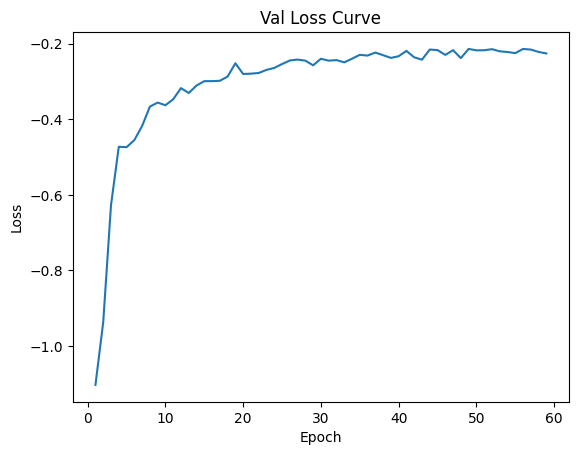

Student weights and architecture saved and exported for lambda: 3


100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:22<00:00,  1.64it/s]


*******Epoch 0: loss - 0.5485194568686625


100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:22<00:00,  1.64it/s]


*******Epoch 1: loss - 0.3228447858025046


100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:22<00:00,  1.64it/s]


*******Epoch 2: loss - 0.20795616891015978


100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:41<00:00,  1.34it/s]


Average Pretrain Adversary epoch loss:  0.4496706906048691


100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:41<00:00,  1.34it/s]


Average Pretrain Adversary epoch loss:  0.4496556397746591


100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:41<00:00,  1.34it/s]


Average Pretrain Adversary epoch loss:  0.44961399716489453


100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:58<00:00,  2.31it/s]


Average Adversary epoch loss: 0.37014737440382733


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:20<00:00,  2.25it/s]


*****Epoch 1/100*****
*****Train Loss: -2.990206 Val Loss: -2.869746*****
*****Validation Accuracy: 65.08%*****
*****Total Avg Disparity: 0.1428645210939518*****

Class Team_Sports: Recall Difference = 0.07829742511823434
Class Celebration: Recall Difference = -0.022892662219527016
Class Parade: Recall Difference = 0.08559584282127652
Class Waiter_Or_Waitress: Recall Difference = -0.28806907378335944
Class Individual_Sports: Recall Difference = -0.04472971984492735
Class Surgeons: Recall Difference = -0.026607538802660646
Class Spa: Recall Difference = -0.4539007092198583
Class Law_Enforcement: Recall Difference = 0.07917683990233693
Class Business: Recall Difference = -0.10123614663256608
Class Dresses: Recall Difference = -0.6668711656441718
Class Water Activities: Recall Difference = 0.0184305744007236
Class Picnic: Recall Difference = -0.05228758169934644
Class Rescue: Recall Difference = 0.06708860759493668
Class Cheering: Recall Difference = -0.05298690671031098
Class Performance

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:00<00:00,  2.26it/s]


Average Adversary epoch loss: 0.2975259527344914


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:20<00:00,  2.28it/s]


*****Epoch 2/100*****
*****Train Loss: -2.716379 Val Loss: -2.535777*****
*****Validation Accuracy: 65.31%*****
*****Total Avg Disparity: 0.13502517155783939*****

Class Team_Sports: Recall Difference = 0.11645939160390018
Class Celebration: Recall Difference = -0.01632302405498276
Class Parade: Recall Difference = 0.05955508845682245
Class Waiter_Or_Waitress: Recall Difference = -0.23704866562009408
Class Individual_Sports: Recall Difference = -0.04308390022675734
Class Surgeons: Recall Difference = 0.02734663710273466
Class Spa: Recall Difference = -0.3687943262411348
Class Law_Enforcement: Recall Difference = 0.10487152656667831
Class Business: Recall Difference = -0.002131287297527651
Class Dresses: Recall Difference = -0.6809815950920245
Class Water Activities: Recall Difference = -0.03392130257801884
Class Picnic: Recall Difference = -0.18300653594771243
Class Rescue: Recall Difference = 0.130379746835443
Class Cheering: Recall Difference = -0.013093289689034393
Class Performance

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:59<00:00,  2.30it/s]


Average Adversary epoch loss: 0.26881093761938457


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:20<00:00,  2.29it/s]


*****Epoch 3/100*****
*****Train Loss: -2.450763 Val Loss: -2.333636*****
*****Validation Accuracy: 65.14%*****
*****Total Avg Disparity: 0.13409383617503762*****

Class Team_Sports: Recall Difference = 0.09507794710106854
Class Celebration: Recall Difference = -0.0845967252880534
Class Parade: Recall Difference = 0.10007590354411156
Class Waiter_Or_Waitress: Recall Difference = -0.23704866562009408
Class Individual_Sports: Recall Difference = -0.09355570185063278
Class Surgeons: Recall Difference = -0.04508499630450835
Class Spa: Recall Difference = -0.14184397163120577
Class Law_Enforcement: Recall Difference = 0.08452505522613663
Class Business: Recall Difference = 0.01982097186700771
Class Dresses: Recall Difference = -0.7177914110429447
Class Water Activities: Recall Difference = 0.010176390773405597
Class Picnic: Recall Difference = -0.16339869281045744
Class Rescue: Recall Difference = 0.05974683544303794
Class Cheering: Recall Difference = -0.021685761047463115
Class Performanc

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:59<00:00,  2.30it/s]


Average Adversary epoch loss: 0.2454458769849118


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.33it/s]


*****Epoch 4/100*****
*****Train Loss: -2.383460 Val Loss: -2.177151*****
*****Validation Accuracy: 66.23%*****
*****Total Avg Disparity: 0.13226731048948948*****

Class Team_Sports: Recall Difference = 0.06729724995620956
Class Celebration: Recall Difference = -0.024762482312512712
Class Parade: Recall Difference = 0.03789338471419401
Class Waiter_Or_Waitress: Recall Difference = -0.21664050235478804
Class Individual_Sports: Recall Difference = -0.06239485041328352
Class Surgeons: Recall Difference = -0.020694752402069416
Class Spa: Recall Difference = -0.120567375886525
Class Law_Enforcement: Recall Difference = 0.08185094756423672
Class Business: Recall Difference = -0.026001705029838118
Class Dresses: Recall Difference = -0.7098159509202453
Class Water Activities: Recall Difference = 0.0030529172320217235
Class Picnic: Recall Difference = -0.392156862745098
Class Rescue: Recall Difference = 0.04506329113924046
Class Cheering: Recall Difference = -0.0045008183306056715
Class Perform

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:59<00:00,  2.30it/s]


Average Adversary epoch loss: 0.23768636967767687


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.36it/s]


*****Epoch 5/100*****
*****Train Loss: -2.309250 Val Loss: -2.140358*****
*****Validation Accuracy: 64.76%*****
*****Total Avg Disparity: 0.149806232505852*****

Class Team_Sports: Recall Difference = 0.14390144216733802
Class Celebration: Recall Difference = -0.05857085102082071
Class Parade: Recall Difference = 0.06685350615986463
Class Waiter_Or_Waitress: Recall Difference = -0.33202511773940335
Class Individual_Sports: Recall Difference = -0.0017189671567552356
Class Surgeons: Recall Difference = -0.10643015521064303
Class Spa: Recall Difference = -0.39007092198581567
Class Law_Enforcement: Recall Difference = 0.12393907685152872
Class Business: Recall Difference = 0.013213981244671769
Class Dresses: Recall Difference = -0.7116564417177914
Class Water Activities: Recall Difference = 0.03335594753505211
Class Picnic: Recall Difference = -0.10457516339869283
Class Rescue: Recall Difference = 0.05569620253164553
Class Cheering: Recall Difference = -0.007978723404255372
Class Performan

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:57<00:00,  2.36it/s]


Average Adversary epoch loss: 0.23199008777737617


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.37it/s]


*****Epoch 6/100*****
*****Train Loss: -2.232472 Val Loss: -2.066367*****
*****Validation Accuracy: 64.59%*****
*****Total Avg Disparity: 0.1616608733836965*****

Class Team_Sports: Recall Difference = 0.06477491679803826
Class Celebration: Recall Difference = -0.048766929452193186
Class Parade: Recall Difference = 0.061014771997430994
Class Waiter_Or_Waitress: Recall Difference = -0.22919937205651486
Class Individual_Sports: Recall Difference = -0.0756345548972277
Class Surgeons: Recall Difference = -0.10643015521064308
Class Spa: Recall Difference = -0.41134751773049666
Class Law_Enforcement: Recall Difference = 0.13812347401464942
Class Business: Recall Difference = -0.013000852514919004
Class Dresses: Recall Difference = -0.7484662576687117
Class Water Activities: Recall Difference = 0.04161013116237
Class Picnic: Recall Difference = -0.18300653594771238
Class Rescue: Recall Difference = 0.1124050632911392
Class Cheering: Recall Difference = -0.02823240589198034
Class Performance_A

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:58<00:00,  2.33it/s]


Average Adversary epoch loss: 0.22687235518413432


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.35it/s]


*****Epoch 7/100*****
*****Train Loss: -2.145037 Val Loss: -1.899835*****
*****Validation Accuracy: 66.12%*****
*****Total Avg Disparity: 0.15849595098824806*****

Class Team_Sports: Recall Difference = 0.07391837449640914
Class Celebration: Recall Difference = -0.02036587831008685
Class Parade: Recall Difference = 0.07555322006189058
Class Waiter_Or_Waitress: Recall Difference = -0.20643642072213497
Class Individual_Sports: Recall Difference = -0.04915514592933945
Class Surgeons: Recall Difference = 0.00960827790096086
Class Spa: Recall Difference = -0.4539007092198583
Class Law_Enforcement: Recall Difference = 0.10533658876874785
Class Business: Recall Difference = 0.004475703324808178
Class Dresses: Recall Difference = -0.8343558282208589
Class Water Activities: Recall Difference = 0.01085481682496603
Class Picnic: Recall Difference = -0.21568627450980393
Class Rescue: Recall Difference = 0.12835443037974686
Class Cheering: Recall Difference = -0.009001636661211121
Class Performance

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:58<00:00,  2.33it/s]


Average Adversary epoch loss: 0.20478012522353845


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.33it/s]


*****Epoch 8/100*****
*****Train Loss: -2.030248 Val Loss: -1.914026*****
*****Validation Accuracy: 65.74%*****
*****Total Avg Disparity: 0.12810421772683028*****

Class Team_Sports: Recall Difference = 0.05573655631459096
Class Celebration: Recall Difference = -0.05720638770972308
Class Parade: Recall Difference = 0.011969405032988933
Class Waiter_Or_Waitress: Recall Difference = -0.18602825745682883
Class Individual_Sports: Recall Difference = -0.05990783410138256
Class Surgeons: Recall Difference = 0.015521064301552201
Class Spa: Recall Difference = -0.28368794326241137
Class Law_Enforcement: Recall Difference = 0.11952098593186844
Class Business: Recall Difference = -0.0008525149190111714
Class Dresses: Recall Difference = -0.7484662576687117
Class Water Activities: Recall Difference = 0.025554047942107694
Class Picnic: Recall Difference = -0.18300653594771238
Class Rescue: Recall Difference = -0.013670886075949351
Class Cheering: Recall Difference = -0.005523731587561365
Class Per

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:58<00:00,  2.33it/s]


Average Adversary epoch loss: 0.20299280922421636


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.31it/s]


*****Epoch 9/100*****
*****Train Loss: -2.026231 Val Loss: -1.889999*****
*****Validation Accuracy: 65.57%*****
*****Total Avg Disparity: 0.147326514554901*****

Class Team_Sports: Recall Difference = 0.0580370175745899
Class Celebration: Recall Difference = 0.030169799878714376
Class Parade: Recall Difference = 0.10445495416593675
Class Waiter_Or_Waitress: Recall Difference = -0.1475667189952906
Class Individual_Sports: Recall Difference = -0.08390022675736963
Class Surgeons: Recall Difference = -0.03325942350332589
Class Spa: Recall Difference = -0.3687943262411348
Class Law_Enforcement: Recall Difference = 0.041506801534705096
Class Business: Recall Difference = -0.06180733162830354
Class Dresses: Recall Difference = -0.7914110429447853
Class Water Activities: Recall Difference = -0.019448213478064247
Class Picnic: Recall Difference = -0.18300653594771238
Class Rescue: Recall Difference = 0.07164556962025309
Class Cheering: Recall Difference = -0.10924713584288054
Class Performance_

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:59<00:00,  2.30it/s]


Average Adversary epoch loss: 0.20072261682328055


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.34it/s]


*****Epoch 10/100*****
*****Train Loss: -2.001235 Val Loss: -1.816709*****
*****Validation Accuracy: 65.89%*****
*****Total Avg Disparity: 0.14968814919535037*****

Class Team_Sports: Recall Difference = 0.04557715887195646
Class Celebration: Recall Difference = -0.0717606630280978
Class Parade: Recall Difference = 0.09289426052431837
Class Waiter_Or_Waitress: Recall Difference = -0.22135007849293564
Class Individual_Sports: Recall Difference = -0.07205032550654666
Class Surgeons: Recall Difference = -0.1855136733185514
Class Spa: Recall Difference = -0.39007092198581567
Class Law_Enforcement: Recall Difference = 0.07254970352284607
Class Business: Recall Difference = -0.026001705029838007
Class Dresses: Recall Difference = -0.7607361963190185
Class Water Activities: Recall Difference = 0.03312980551786526
Class Picnic: Recall Difference = -0.16339869281045744
Class Rescue: Recall Difference = 0.030379746835443033
Class Cheering: Recall Difference = -0.03989361702127653
Class Performan

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:59<00:00,  2.29it/s]


Average Adversary epoch loss: 0.19596509531359463


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:20<00:00,  2.29it/s]


*****Epoch 11/100*****
*****Train Loss: -1.957099 Val Loss: -1.828267*****
*****Validation Accuracy: 66.00%*****
*****Total Avg Disparity: 0.1426651530241072*****

Class Team_Sports: Recall Difference = 0.053097448473171105
Class Celebration: Recall Difference = -0.04386496866787959
Class Parade: Recall Difference = 0.06831318970047295
Class Waiter_Or_Waitress: Recall Difference = -0.1475667189952904
Class Individual_Sports: Recall Difference = -0.030685392436544334
Class Surgeons: Recall Difference = -0.06356245380635617
Class Spa: Recall Difference = -0.39007092198581567
Class Law_Enforcement: Recall Difference = 0.07743285664457633
Class Business: Recall Difference = -0.06180733162830354
Class Dresses: Recall Difference = -0.7730061349693251
Class Water Activities: Recall Difference = 0.04070556309362272
Class Picnic: Recall Difference = -0.18300653594771243
Class Rescue: Recall Difference = -0.022278481012658335
Class Cheering: Recall Difference = -0.04541734860883795
Class Perform

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:59<00:00,  2.29it/s]


Average Adversary epoch loss: 0.19155422537861502


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.36it/s]


*****Epoch 12/100*****
*****Train Loss: -1.939526 Val Loss: -1.865498*****
*****Validation Accuracy: 66.03%*****
*****Total Avg Disparity: 0.14998057974035087*****

Class Team_Sports: Recall Difference = 0.04417586267297258
Class Celebration: Recall Difference = -0.03845765110167776
Class Parade: Recall Difference = -0.003970339230454867
Class Waiter_Or_Waitress: Recall Difference = -0.19858712715855564
Class Individual_Sports: Recall Difference = -0.09465291492941275
Class Surgeons: Recall Difference = -0.03325942350332589
Class Spa: Recall Difference = -0.41134751773049644
Class Law_Enforcement: Recall Difference = 0.1102197418904779
Class Business: Recall Difference = -0.031543052003410066
Class Dresses: Recall Difference = -0.7914110429447853
Class Water Activities: Recall Difference = 0.06343283582089576
Class Picnic: Recall Difference = -0.16339869281045744
Class Rescue: Recall Difference = 0.05240506329113925
Class Cheering: Recall Difference = -0.03784779050736509
Class Perform

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:55<00:00,  2.43it/s]


Average Adversary epoch loss: 0.18880336446797147


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.39it/s]


*****Epoch 13/100*****
*****Train Loss: -1.890236 Val Loss: -1.756857*****
*****Validation Accuracy: 66.44%*****
*****Total Avg Disparity: 0.15958096063691346*****

Class Team_Sports: Recall Difference = 0.07133765399661363
Class Celebration: Recall Difference = -0.00904588639579551
Class Parade: Recall Difference = 0.0841945466222922
Class Waiter_Or_Waitress: Recall Difference = -0.20879120879120883
Class Individual_Sports: Recall Difference = -0.04363250676614716
Class Surgeons: Recall Difference = -0.16703621581670347
Class Spa: Recall Difference = -0.3687943262411348
Class Law_Enforcement: Recall Difference = 0.049064062318335155
Class Business: Recall Difference = 0.01982097186700771
Class Dresses: Recall Difference = -0.7423312883435583
Class Water Activities: Recall Difference = 0.0714608774310268
Class Picnic: Recall Difference = -0.18300653594771238
Class Rescue: Recall Difference = 0.1336708860759493
Class Cheering: Recall Difference = -0.02823240589198034
Class Performance_A

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:56<00:00,  2.39it/s]


Average Adversary epoch loss: 0.18815915029057684


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.34it/s]


*****Epoch 14/100*****
*****Train Loss: -1.886248 Val Loss: -1.789970*****
*****Validation Accuracy: 66.26%*****
*****Total Avg Disparity: 0.12783565952265785*****

Class Team_Sports: Recall Difference = 0.0525369299935774
Class Celebration: Recall Difference = -0.026632302405498187
Class Parade: Recall Difference = 0.061073159339055105
Class Waiter_Or_Waitress: Recall Difference = -0.22919937205651486
Class Individual_Sports: Recall Difference = -0.00201155731109659
Class Surgeons: Recall Difference = -0.033259423503326
Class Spa: Recall Difference = -0.39007092198581567
Class Law_Enforcement: Recall Difference = 0.08673410068596665
Class Business: Recall Difference = 0.014279624893435594
Class Dresses: Recall Difference = -0.7852760736196319
Class Water Activities: Recall Difference = 0.04093170511080968
Class Picnic: Recall Difference = -0.10457516339869288
Class Rescue: Recall Difference = 0.05569620253164553
Class Cheering: Recall Difference = -0.028232405891980283
Class Performan

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:56<00:00,  2.42it/s]


Average Adversary epoch loss: 0.18758776794899912


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.36it/s]


*****Epoch 15/100*****
*****Train Loss: -1.901674 Val Loss: -1.775345*****
*****Validation Accuracy: 66.09%*****
*****Total Avg Disparity: 0.1708156828571707*****

Class Team_Sports: Recall Difference = 0.07795877853681343
Class Celebration: Recall Difference = -0.027289266221952657
Class Parade: Recall Difference = 0.10007590354411156
Class Waiter_Or_Waitress: Recall Difference = -0.22135007849293564
Class Individual_Sports: Recall Difference = -0.05935922756199252
Class Surgeons: Recall Difference = -0.13673318551367336
Class Spa: Recall Difference = -0.4326241134751773
Class Law_Enforcement: Recall Difference = 0.13370538309498892
Class Business: Recall Difference = -0.0694799658994033
Class Dresses: Recall Difference = -0.7852760736196319
Class Water Activities: Recall Difference = 0.06343283582089543
Class Picnic: Recall Difference = -0.1633986928104575
Class Rescue: Recall Difference = 0.14430379746835442
Class Cheering: Recall Difference = -0.10515548281505721
Class Performance_

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:58<00:00,  2.32it/s]


Average Adversary epoch loss: 0.18407139565576525


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.31it/s]


*****Epoch 16/100*****
*****Train Loss: -1.859262 Val Loss: -1.700925*****
*****Validation Accuracy: 65.97%*****
*****Total Avg Disparity: 0.1872993174049744*****

Class Team_Sports: Recall Difference = 0.04557715887195657
Class Celebration: Recall Difference = -0.12532848190822715
Class Parade: Recall Difference = 0.040871139137034995
Class Waiter_Or_Waitress: Recall Difference = -0.23940345368916804
Class Individual_Sports: Recall Difference = -0.07618316143661763
Class Surgeons: Recall Difference = -0.17294900221729487
Class Spa: Recall Difference = -0.41134751773049644
Class Law_Enforcement: Recall Difference = 0.11731194047203808
Class Business: Recall Difference = -0.07054560954816702
Class Dresses: Recall Difference = -0.7361963190184049
Class Water Activities: Recall Difference = 0.04828132066938018
Class Picnic: Recall Difference = -0.35294117647058826
Class Rescue: Recall Difference = 0.1377215189873417
Class Cheering: Recall Difference = -0.07528641571194761
Class Performanc

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:59<00:00,  2.30it/s]


Average Adversary epoch loss: 0.18091218573424747


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:20<00:00,  2.26it/s]


*****Epoch 17/100*****
*****Train Loss: -1.817867 Val Loss: -1.699885*****
*****Validation Accuracy: 65.48%*****
*****Total Avg Disparity: 0.15677559096457958*****

Class Team_Sports: Recall Difference = 0.04501664039236297
Class Celebration: Recall Difference = -0.07039619971700029
Class Parade: Recall Difference = 0.043732118876627646
Class Waiter_Or_Waitress: Recall Difference = -0.23940345368916782
Class Individual_Sports: Recall Difference = -0.07757296466973884
Class Surgeons: Recall Difference = -0.16703621581670358
Class Spa: Recall Difference = -0.41134751773049644
Class Law_Enforcement: Recall Difference = 0.07254970352284618
Class Business: Recall Difference = -0.009590792838874762
Class Dresses: Recall Difference = -0.7607361963190183
Class Water Activities: Recall Difference = -0.0036182722749887875
Class Picnic: Recall Difference = -0.2026143790849672
Class Rescue: Recall Difference = 0.0850632911392405
Class Cheering: Recall Difference = -0.11886252045826518
Class Perfor

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:00<00:00,  2.26it/s]


Average Adversary epoch loss: 0.18044063531081467


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:20<00:00,  2.30it/s]


*****Epoch 18/100*****
*****Train Loss: -1.844455 Val Loss: -1.720951*****
*****Validation Accuracy: 66.29%*****
*****Total Avg Disparity: 0.17194520125062013*****

Class Team_Sports: Recall Difference = 0.03699421965317917
Class Celebration: Recall Difference = -0.018849807964422927
Class Parade: Recall Difference = 0.043732118876627424
Class Waiter_Or_Waitress: Recall Difference = -0.2189952904238618
Class Individual_Sports: Recall Difference = -0.07175773535220564
Class Surgeons: Recall Difference = -0.03325942350332589
Class Spa: Recall Difference = -0.4539007092198581
Class Law_Enforcement: Recall Difference = 0.10091849784908746
Class Business: Recall Difference = -0.03026427962489353
Class Dresses: Recall Difference = -0.7852760736196319
Class Water Activities: Recall Difference = 0.017978290366349903
Class Picnic: Recall Difference = -0.36601307189542487
Class Rescue: Recall Difference = 0.08101265822784803
Class Cheering: Recall Difference = -0.13154664484451717
Class Performa

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:59<00:00,  2.28it/s]


Average Adversary epoch loss: 0.18043647657203324


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:20<00:00,  2.27it/s]


*****Epoch 19/100*****
*****Train Loss: -1.794271 Val Loss: -1.667269*****
*****Validation Accuracy: 66.15%*****
*****Total Avg Disparity: 0.14292777009653634*****

Class Team_Sports: Recall Difference = 0.03345594675074448
Class Celebration: Recall Difference = -0.059581564584596625
Class Parade: Recall Difference = 0.024931394873591417
Class Waiter_Or_Waitress: Recall Difference = -0.22919937205651486
Class Individual_Sports: Recall Difference = -0.09190988223246288
Class Surgeons: Recall Difference = -0.16703621581670353
Class Spa: Recall Difference = -0.41134751773049644
Class Law_Enforcement: Recall Difference = 0.11952098593186844
Class Business: Recall Difference = 0.007672634271099765
Class Dresses: Recall Difference = -0.6098159509202453
Class Water Activities: Recall Difference = 0.003505201266395308
Class Picnic: Recall Difference = -0.16339869281045744
Class Rescue: Recall Difference = 0.09037974683544309
Class Cheering: Recall Difference = -0.037847790507364976
Class Perfo

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:58<00:00,  2.32it/s]


Average Adversary epoch loss: 0.17777401428012288


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.31it/s]


*****Epoch 20/100*****
*****Train Loss: -1.826465 Val Loss: -1.685686*****
*****Validation Accuracy: 65.31%*****
*****Total Avg Disparity: 0.15674396659145068*****

Class Team_Sports: Recall Difference = 0.041875401412973745
Class Celebration: Recall Difference = -0.06008692136648475
Class Parade: Recall Difference = 0.04799439481520418
Class Waiter_Or_Waitress: Recall Difference = -0.22135007849293564
Class Individual_Sports: Recall Difference = 0.0010240655401946297
Class Surgeons: Recall Difference = -0.10643015521064292
Class Spa: Recall Difference = -0.41134751773049666
Class Law_Enforcement: Recall Difference = 0.07696779444250657
Class Business: Recall Difference = -0.03687127024722936
Class Dresses: Recall Difference = -0.7361963190184049
Class Water Activities: Recall Difference = 0.003731343283582156
Class Picnic: Recall Difference = -0.33333333333333326
Class Rescue: Recall Difference = 0.014430379746835476
Class Cheering: Recall Difference = -0.11783960720130926
Class Perfo

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:58<00:00,  2.32it/s]


Average Adversary epoch loss: 0.17872529619318597


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:20<00:00,  2.25it/s]


*****Epoch 21/100*****
*****Train Loss: -1.788864 Val Loss: -1.730208*****
*****Validation Accuracy: 65.40%*****
*****Total Avg Disparity: 0.12096363357292582*****

Class Team_Sports: Recall Difference = 0.027115081450341583
Class Celebration: Recall Difference = -0.0007580351728320167
Class Parade: Recall Difference = 0.026391078414199964
Class Waiter_Or_Waitress: Recall Difference = -0.22684458398744112
Class Individual_Sports: Recall Difference = -0.09798112793504488
Class Surgeons: Recall Difference = 0.04582409460458248
Class Spa: Recall Difference = -0.120567375886525
Class Law_Enforcement: Recall Difference = 0.08626903848389733
Class Business: Recall Difference = -0.04028132992327371
Class Dresses: Recall Difference = -0.7484662576687116
Class Water Activities: Recall Difference = 0.0032790592492084603
Class Picnic: Recall Difference = -0.0915032679738561
Class Rescue: Recall Difference = 0.12506329113924047
Class Cheering: Recall Difference = -0.032733224222585844
Class Perfor

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:59<00:00,  2.29it/s]


Average Adversary epoch loss: 0.17714895379236517


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.32it/s]


*****Epoch 22/100*****
*****Train Loss: -1.767751 Val Loss: -1.678715*****
*****Validation Accuracy: 66.20%*****
*****Total Avg Disparity: 0.14227486759173666*****

Class Team_Sports: Recall Difference = 0.049337303672563726
Class Celebration: Recall Difference = -0.07817869415807555
Class Parade: Recall Difference = 0.06977287324108117
Class Waiter_Or_Waitress: Recall Difference = -0.24489795918367352
Class Individual_Sports: Recall Difference = -0.04143808060858756
Class Surgeons: Recall Difference = -0.04508499630450835
Class Spa: Recall Difference = -0.43262411347517743
Class Law_Enforcement: Recall Difference = 0.08940820834786645
Class Business: Recall Difference = 0.002344416027280305
Class Dresses: Recall Difference = -0.5791411042944785
Class Water Activities: Recall Difference = -0.012098597919493415
Class Picnic: Recall Difference = -0.18300653594771238
Class Rescue: Recall Difference = -0.018227848101265876
Class Cheering: Recall Difference = -0.11579378068739771
Class Perf

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:59<00:00,  2.29it/s]


Average Adversary epoch loss: 0.17755005037521615


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:20<00:00,  2.24it/s]


*****Epoch 23/100*****
*****Train Loss: -1.773323 Val Loss: -1.743145*****
*****Validation Accuracy: 65.54%*****
*****Total Avg Disparity: 0.1481316203304467*****

Class Team_Sports: Recall Difference = 0.087557657499854
Class Celebration: Recall Difference = -0.031028906407924106
Class Parade: Recall Difference = 0.05961347579844678
Class Waiter_Or_Waitress: Recall Difference = -0.19073783359497642
Class Individual_Sports: Recall Difference = -0.08419281691171088
Class Surgeons: Recall Difference = -0.033259423503326
Class Spa: Recall Difference = -0.39007092198581567
Class Law_Enforcement: Recall Difference = 0.13544936635274973
Class Business: Recall Difference = -0.07289002557544755
Class Dresses: Recall Difference = -0.7423312883435583
Class Water Activities: Recall Difference = -0.019448213478064247
Class Picnic: Recall Difference = -0.22222222222222215
Class Rescue: Recall Difference = 0.08101265822784803
Class Cheering: Recall Difference = -0.03334697217675947
Class Performance

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:00<00:00,  2.24it/s]


Average Adversary epoch loss: 0.17714134127120762


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:20<00:00,  2.24it/s]


*****Epoch 24/100*****
*****Train Loss: -1.770590 Val Loss: -1.617759*****
*****Validation Accuracy: 66.41%*****
*****Total Avg Disparity: 0.15656768863626208*****

Class Team_Sports: Recall Difference = 0.05483739125357645
Class Celebration: Recall Difference = -0.035577117444916095
Class Parade: Recall Difference = 0.07695451626087457
Class Waiter_Or_Waitress: Recall Difference = -0.2959183673469389
Class Individual_Sports: Recall Difference = -0.045022309999268595
Class Surgeons: Recall Difference = 0.045824094604582366
Class Spa: Recall Difference = -0.4539007092198583
Class Law_Enforcement: Recall Difference = 0.12707824671549817
Class Business: Recall Difference = -0.05434782608695654
Class Dresses: Recall Difference = -0.7668711656441718
Class Water Activities: Recall Difference = 0.05585707824513797
Class Picnic: Recall Difference = -0.2026143790849672
Class Rescue: Recall Difference = -0.020253164556962078
Class Cheering: Recall Difference = -0.037847790507364976
Class Perform

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:00<00:00,  2.27it/s]


Average Adversary epoch loss: 0.174881088821327


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:20<00:00,  2.26it/s]


*****Epoch 25/100*****
*****Train Loss: -1.728384 Val Loss: -1.638017*****
*****Validation Accuracy: 66.81%*****
*****Total Avg Disparity: 0.14681580364450753*****

Class Team_Sports: Recall Difference = 0.057698370993168546
Class Celebration: Recall Difference = -0.05028299979785733
Class Parade: Recall Difference = 0.023530098674607314
Class Waiter_Or_Waitress: Recall Difference = -0.2370486656200942
Class Individual_Sports: Recall Difference = -0.041438080608587446
Class Surgeons: Recall Difference = -0.008869179600886956
Class Spa: Recall Difference = -0.43262411347517743
Class Law_Enforcement: Recall Difference = 0.1031275433089176
Class Business: Recall Difference = 0.020886615515771423
Class Dresses: Recall Difference = -0.7484662576687117
Class Water Activities: Recall Difference = 0.04138398914518315
Class Picnic: Recall Difference = -0.20261437908496727
Class Rescue: Recall Difference = -0.012911392405063282
Class Cheering: Recall Difference = -0.11027004909983634
Class Perfo

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:59<00:00,  2.29it/s]


Average Adversary epoch loss: 0.17250931416364276


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:20<00:00,  2.27it/s]


*****Epoch 26/100*****
*****Train Loss: -1.742495 Val Loss: -1.648003*****
*****Validation Accuracy: 65.08%*****
*****Total Avg Disparity: 0.14380336212337874*****

Class Team_Sports: Recall Difference = 0.04737548899398625
Class Celebration: Recall Difference = -0.030018192844147973
Class Parade: Recall Difference = 0.02061073159339044
Class Waiter_Or_Waitress: Recall Difference = -0.3037676609105181
Class Individual_Sports: Recall Difference = -0.09713993124131381
Class Surgeons: Recall Difference = -0.06356245380635628
Class Spa: Recall Difference = -0.3687943262411348
Class Law_Enforcement: Recall Difference = 0.12882222997325898
Class Business: Recall Difference = -0.007459505541347
Class Dresses: Recall Difference = -0.754601226993865
Class Water Activities: Recall Difference = 0.018656716417910446
Class Picnic: Recall Difference = -0.16339869281045744
Class Rescue: Recall Difference = -0.020253164556962022
Class Cheering: Recall Difference = -0.002864157119476296
Class Performan

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:58<00:00,  2.32it/s]


Average Adversary epoch loss: 0.1710227205801536


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.33it/s]


*****Epoch 27/100*****
*****Train Loss: -1.698842 Val Loss: -1.643778*****
*****Validation Accuracy: 65.28%*****
*****Total Avg Disparity: 0.14411420964578653*****

Class Team_Sports: Recall Difference = 0.04299643837216105
Class Celebration: Recall Difference = -0.0663533454618962
Class Parade: Recall Difference = 0.06685350615986463
Class Waiter_Or_Waitress: Recall Difference = -0.25745682888540034
Class Individual_Sports: Recall Difference = -0.07508594835783766
Class Surgeons: Recall Difference = -0.05764966740576494
Class Spa: Recall Difference = -0.41134751773049666
Class Law_Enforcement: Recall Difference = 0.12882222997325898
Class Business: Recall Difference = 0.037084398976982014
Class Dresses: Recall Difference = -0.5791411042944784
Class Water Activities: Recall Difference = 0.003505201266395308
Class Picnic: Recall Difference = -0.27450980392156854
Class Rescue: Recall Difference = 0.10506329113924046
Class Cheering: Recall Difference = -0.049509001636661165
Class Performa

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:57<00:00,  2.35it/s]


Average Adversary epoch loss: 0.1706483949742773


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.34it/s]


*****Epoch 28/100*****
*****Train Loss: -1.719153 Val Loss: -1.672067*****
*****Validation Accuracy: 66.26%*****
*****Total Avg Disparity: 0.14863807563424364*****

Class Team_Sports: Recall Difference = 0.029135283470543505
Class Celebration: Recall Difference = -0.041489791793005826
Class Parade: Recall Difference = 0.09575524026391091
Class Waiter_Or_Waitress: Recall Difference = -0.2676609105180533
Class Individual_Sports: Recall Difference = -0.0497037524687296
Class Surgeons: Recall Difference = -0.014781966001478186
Class Spa: Recall Difference = -0.3687943262411348
Class Law_Enforcement: Recall Difference = 0.09115219160562738
Class Business: Recall Difference = 0.04390451832907072
Class Dresses: Recall Difference = -0.6993865030674846
Class Water Activities: Recall Difference = 0.01085481682496603
Class Picnic: Recall Difference = -0.3333333333333333
Class Rescue: Recall Difference = 0.08101265822784814
Class Cheering: Recall Difference = -0.08244680851063835
Class Performance

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:57<00:00,  2.35it/s]


Average Adversary epoch loss: 0.17077574166743195


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.33it/s]


*****Epoch 29/100*****
*****Train Loss: -1.736531 Val Loss: -1.611452*****
*****Validation Accuracy: 66.20%*****
*****Total Avg Disparity: 0.15448384045982855*****

Class Team_Sports: Recall Difference = 0.023354936649734315
Class Celebration: Recall Difference = -0.04386496866787959
Class Parade: Recall Difference = 0.07117416944006527
Class Waiter_Or_Waitress: Recall Difference = -0.30062794348508626
Class Individual_Sports: Recall Difference = -0.045570916538658524
Class Surgeons: Recall Difference = -0.06947524020694762
Class Spa: Recall Difference = -0.4539007092198583
Class Law_Enforcement: Recall Difference = 0.04638995465643525
Class Business: Recall Difference = -0.03026427962489353
Class Dresses: Recall Difference = -0.7116564417177914
Class Water Activities: Recall Difference = 0.010854816824965918
Class Picnic: Recall Difference = -0.33333333333333326
Class Rescue: Recall Difference = 0.09772151898734172
Class Cheering: Recall Difference = -0.030278232405891947
Class Perfor

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:58<00:00,  2.32it/s]


Average Adversary epoch loss: 0.16961904412464185


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.31it/s]


*****Epoch 30/100*****
*****Train Loss: -1.708662 Val Loss: -1.655109*****
*****Validation Accuracy: 65.60%*****
*****Total Avg Disparity: 0.15925896859327965*****

Class Team_Sports: Recall Difference = 0.03149413207216678
Class Celebration: Recall Difference = 0.027794623003840724
Class Parade: Recall Difference = 0.004670987329946863
Class Waiter_Or_Waitress: Recall Difference = -0.34222919937205665
Class Individual_Sports: Recall Difference = -0.046412113232389696
Class Surgeons: Recall Difference = -0.05764966740576494
Class Spa: Recall Difference = -0.43262411347517743
Class Law_Enforcement: Recall Difference = 0.1620741774212301
Class Business: Recall Difference = -0.017263427109974416
Class Dresses: Recall Difference = -0.7791411042944786
Class Water Activities: Recall Difference = -0.0192220714608774
Class Picnic: Recall Difference = -0.22222222222222215
Class Rescue: Recall Difference = 0.04835443037974685
Class Cheering: Recall Difference = -0.08142389525368249
Class Perform

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:00<00:00,  2.25it/s]


Average Adversary epoch loss: 0.16805252958746517


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:20<00:00,  2.25it/s]


*****Epoch 31/100*****
*****Train Loss: -1.676636 Val Loss: -1.585487*****
*****Validation Accuracy: 66.00%*****
*****Total Avg Disparity: 0.15473564825105424*****

Class Team_Sports: Recall Difference = 0.07964033397559411
Class Celebration: Recall Difference = -0.007681423084697769
Class Parade: Recall Difference = 0.03077012903602494
Class Waiter_Or_Waitress: Recall Difference = -0.2676609105180533
Class Individual_Sports: Recall Difference = -0.042535293687367526
Class Surgeons: Recall Difference = -0.14264597191426448
Class Spa: Recall Difference = -0.39007092198581567
Class Law_Enforcement: Recall Difference = 0.12393907685152894
Class Business: Recall Difference = -0.0347399829497016
Class Dresses: Recall Difference = -0.7361963190184049
Class Water Activities: Recall Difference = 0.04850746268656714
Class Picnic: Recall Difference = -0.22222222222222215
Class Rescue: Recall Difference = 0.047088607594936716
Class Cheering: Recall Difference = -0.021685761047463115
Class Perform

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:59<00:00,  2.30it/s]


Average Adversary epoch loss: 0.16732856028658502


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.39it/s]


*****Epoch 32/100*****
*****Train Loss: -1.683087 Val Loss: -1.685414*****
*****Validation Accuracy: 66.00%*****
*****Total Avg Disparity: 0.1550015018249192*****

Class Team_Sports: Recall Difference = 0.05427687277398274
Class Celebration: Recall Difference = -0.04927228623408125
Class Parade: Recall Difference = 0.10439656682431253
Class Waiter_Or_Waitress: Recall Difference = -0.27001569858712704
Class Individual_Sports: Recall Difference = 0.008485114475897948
Class Surgeons: Recall Difference = 0.03399852180340002
Class Spa: Recall Difference = -0.41134751773049666
Class Law_Enforcement: Recall Difference = 0.10975467968840835
Class Business: Recall Difference = 0.02408354646206312
Class Dresses: Recall Difference = -0.7300613496932515
Class Water Activities: Recall Difference = 0.03358208955223896
Class Picnic: Recall Difference = -0.31372549019607837
Class Rescue: Recall Difference = 0.047088607594936716
Class Cheering: Recall Difference = -0.03887070376432078
Class Performance

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:56<00:00,  2.40it/s]


Average Adversary epoch loss: 0.1674212647930664


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.41it/s]


*****Epoch 33/100*****
*****Train Loss: -1.680839 Val Loss: -1.614060*****
*****Validation Accuracy: 65.92%*****
*****Total Avg Disparity: 0.13601602199790147*****

Class Team_Sports: Recall Difference = 0.05567816897296651
Class Celebration: Recall Difference = -0.029159086314938354
Class Parade: Recall Difference = 0.05675249605885435
Class Waiter_Or_Waitress: Recall Difference = -0.2857142857142857
Class Individual_Sports: Recall Difference = -0.04586350669299977
Class Surgeons: Recall Difference = -0.021433850702143376
Class Spa: Recall Difference = -0.2836879432624115
Class Law_Enforcement: Recall Difference = 0.09336123706545751
Class Business: Recall Difference = -0.015132139812446765
Class Dresses: Recall Difference = -0.6668711656441718
Class Water Activities: Recall Difference = 0.003505201266395197
Class Picnic: Recall Difference = -0.22222222222222215
Class Rescue: Recall Difference = 0.05367088607594933
Class Cheering: Recall Difference = -0.06730769230769235
Class Perform

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:57<00:00,  2.36it/s]


Average Adversary epoch loss: 0.16715404161197298


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:18<00:00,  2.43it/s]


*****Epoch 34/100*****
*****Train Loss: -1.695854 Val Loss: -1.558625*****
*****Validation Accuracy: 65.89%*****
*****Total Avg Disparity: 0.1481632586923905*****

Class Team_Sports: Recall Difference = 0.05427687277398274
Class Celebration: Recall Difference = -0.04538103901354362
Class Parade: Recall Difference = 0.04957085303906117
Class Waiter_Or_Waitress: Recall Difference = -0.22919937205651486
Class Individual_Sports: Recall Difference = -0.041438080608587446
Class Surgeons: Recall Difference = -0.020694752402069416
Class Spa: Recall Difference = -0.32624113475177313
Class Law_Enforcement: Recall Difference = 0.1266131845134285
Class Business: Recall Difference = -0.04774083546462071
Class Dresses: Recall Difference = -0.6423312883435583
Class Water Activities: Recall Difference = 0.03335594753505189
Class Picnic: Recall Difference = -0.3333333333333334
Class Rescue: Recall Difference = 0.012405063291139218
Class Cheering: Recall Difference = -0.12295417348608839
Class Performan

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:56<00:00,  2.39it/s]


Average Adversary epoch loss: 0.16515902128508864


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.40it/s]


*****Epoch 35/100*****
*****Train Loss: -1.653025 Val Loss: -1.622035*****
*****Validation Accuracy: 64.73%*****
*****Total Avg Disparity: 0.1364533060470886*****

Class Team_Sports: Recall Difference = 0.07767851929701652
Class Celebration: Recall Difference = -0.030169799878714265
Class Parade: Recall Difference = 0.08571261750452497
Class Waiter_Or_Waitress: Recall Difference = -0.2755102040816326
Class Individual_Sports: Recall Difference = -0.008082803013678586
Class Surgeons: Recall Difference = -0.08203991130820404
Class Spa: Recall Difference = -0.09929078014184411
Class Law_Enforcement: Recall Difference = 0.07917683990233693
Class Business: Recall Difference = 0.029624893435635125
Class Dresses: Recall Difference = -0.7668711656441718
Class Water Activities: Recall Difference = -0.01096788783355962
Class Picnic: Recall Difference = -0.2026143790849672
Class Rescue: Recall Difference = 0.05974683544303794
Class Cheering: Recall Difference = -0.10474631751227487
Class Performan

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:57<00:00,  2.36it/s]


Average Adversary epoch loss: 0.164331798113006


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.40it/s]


*****Epoch 36/100*****
*****Train Loss: -1.653755 Val Loss: -1.524250*****
*****Validation Accuracy: 65.37%*****
*****Total Avg Disparity: 0.14223148008149739*****

Class Team_Sports: Recall Difference = 0.06897880539499046
Class Celebration: Recall Difference = 0.0007580351728320167
Class Parade: Recall Difference = 0.08133356688269988
Class Waiter_Or_Waitress: Recall Difference = -0.13186813186813184
Class Individual_Sports: Recall Difference = -0.06846609611586574
Class Surgeons: Recall Difference = -0.11825572801182549
Class Spa: Recall Difference = -0.39007092198581567
Class Law_Enforcement: Recall Difference = 0.1638181606789908
Class Business: Recall Difference = -0.01619778346121048
Class Dresses: Recall Difference = -0.7177914110429449
Class Water Activities: Recall Difference = 0.02600633197648139
Class Picnic: Recall Difference = -0.18300653594771238
Class Rescue: Recall Difference = 0.08708860759493675
Class Cheering: Recall Difference = -0.06669394435351877
Class Performan

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:57<00:00,  2.38it/s]


Average Adversary epoch loss: 0.16231706913779764


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.39it/s]


*****Epoch 37/100*****
*****Train Loss: -1.662611 Val Loss: -1.653539*****
*****Validation Accuracy: 64.59%*****
*****Total Avg Disparity: 0.13791205095758896*****

Class Team_Sports: Recall Difference = 0.053716354294389035
Class Celebration: Recall Difference = -0.06008692136648475
Class Parade: Recall Difference = 0.07993227068371578
Class Waiter_Or_Waitress: Recall Difference = -0.22919937205651486
Class Individual_Sports: Recall Difference = -0.10211396386511595
Class Surgeons: Recall Difference = -0.09977827050997778
Class Spa: Recall Difference = -0.120567375886525
Class Law_Enforcement: Recall Difference = 0.13591442855481928
Class Business: Recall Difference = 0.02195225916453536
Class Dresses: Recall Difference = -0.7423312883435583
Class Water Activities: Recall Difference = 0.02578018995929454
Class Picnic: Recall Difference = -0.2941176470588235
Class Rescue: Recall Difference = -0.0015189873417721933
Class Cheering: Recall Difference = -0.09001636661211126
Class Performan

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:56<00:00,  2.39it/s]


Average Adversary epoch loss: 0.16456845649244153


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.41it/s]


*****Epoch 38/100*****
*****Train Loss: -1.645407 Val Loss: -1.579550*****
*****Validation Accuracy: 65.28%*****
*****Total Avg Disparity: 0.14410688880470432*****

Class Team_Sports: Recall Difference = 0.09647924330005264
Class Celebration: Recall Difference = 0.010561956741459433
Class Parade: Recall Difference = 0.08133356688269999
Class Waiter_Or_Waitress: Recall Difference = -0.21664050235478793
Class Individual_Sports: Recall Difference = -0.09355570185063267
Class Surgeons: Recall Difference = -0.08795269770879516
Class Spa: Recall Difference = -0.3687943262411348
Class Law_Enforcement: Recall Difference = 0.06813161260318568
Class Business: Recall Difference = -0.004262574595055413
Class Dresses: Recall Difference = -0.8036809815950919
Class Water Activities: Recall Difference = 0.01843057440072371
Class Picnic: Recall Difference = -0.11111111111111105
Class Rescue: Recall Difference = -0.01088607594936708
Class Cheering: Recall Difference = -0.08142389525368238
Class Performa

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:56<00:00,  2.39it/s]


Average Adversary epoch loss: 0.16343055391574607


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.38it/s]


*****Epoch 39/100*****
*****Train Loss: -1.653329 Val Loss: -1.599312*****
*****Validation Accuracy: 65.97%*****
*****Total Avg Disparity: 0.1375964138908814*****

Class Team_Sports: Recall Difference = 0.08171892333742059
Class Celebration: Recall Difference = 0.03305033353547604
Class Parade: Recall Difference = 0.03795177205581812
Class Waiter_Or_Waitress: Recall Difference = -0.23940345368916782
Class Individual_Sports: Recall Difference = -0.06956330919464548
Class Surgeons: Recall Difference = -0.13673318551367325
Class Spa: Recall Difference = -0.28368794326241137
Class Law_Enforcement: Recall Difference = 0.08673410068596654
Class Business: Recall Difference = -0.05967604433077578
Class Dresses: Recall Difference = -0.7607361963190183
Class Water Activities: Recall Difference = 0.003505201266395197
Class Picnic: Recall Difference = 0.019607843137255054
Class Rescue: Recall Difference = 0.13772151898734175
Class Cheering: Recall Difference = -0.08142389525368243
Class Performanc

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:56<00:00,  2.39it/s]


Average Adversary epoch loss: 0.16232839796472998


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.35it/s]


*****Epoch 40/100*****
*****Train Loss: -1.610033 Val Loss: -1.494685*****
*****Validation Accuracy: 65.74%*****
*****Total Avg Disparity: 0.17511040325193145*****

Class Team_Sports: Recall Difference = 0.05427687277398263
Class Celebration: Recall Difference = -0.08257529816050135
Class Parade: Recall Difference = 0.07117416944006527
Class Waiter_Or_Waitress: Recall Difference = -0.22135007849293553
Class Individual_Sports: Recall Difference = -0.08693584960866085
Class Surgeons: Recall Difference = -0.05173688100517365
Class Spa: Recall Difference = -0.43262411347517743
Class Law_Enforcement: Recall Difference = 0.20811533542611338
Class Business: Recall Difference = -0.0694799658994032
Class Dresses: Recall Difference = -0.6993865030674847
Class Water Activities: Recall Difference = 0.01820443238353675
Class Picnic: Recall Difference = -0.22222222222222215
Class Rescue: Recall Difference = 0.1377215189873417
Class Cheering: Recall Difference = -0.1610065466448446
Class Performance_

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:58<00:00,  2.33it/s]


Average Adversary epoch loss: 0.16201606217552633


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.37it/s]


*****Epoch 41/100*****
*****Train Loss: -1.618247 Val Loss: -1.627163*****
*****Validation Accuracy: 64.99%*****
*****Total Avg Disparity: 0.1776144032248107*****

Class Team_Sports: Recall Difference = 0.07767851929701641
Class Celebration: Recall Difference = -0.0977865372953306
Class Parade: Recall Difference = 0.04519180241723597
Class Waiter_Or_Waitress: Recall Difference = -0.19858712715855564
Class Individual_Sports: Recall Difference = -0.07453734181844773
Class Surgeons: Recall Difference = -0.17294900221729487
Class Spa: Recall Difference = -0.3687943262411348
Class Law_Enforcement: Recall Difference = 0.15719102429950016
Class Business: Recall Difference = -0.052216538789428835
Class Dresses: Recall Difference = -0.7668711656441718
Class Water Activities: Recall Difference = 0.05585707824513797
Class Picnic: Recall Difference = -0.26143790849673204
Class Rescue: Recall Difference = 0.08708860759493675
Class Cheering: Recall Difference = -0.09001636661211121
Class Performance

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:58<00:00,  2.32it/s]


Average Adversary epoch loss: 0.16320035228615298


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.31it/s]


*****Epoch 42/100*****
*****Train Loss: -1.627104 Val Loss: -1.527187*****
*****Validation Accuracy: 65.89%*****
*****Total Avg Disparity: 0.14967764585751656*****

Class Team_Sports: Recall Difference = 0.06151690313540026
Class Celebration: Recall Difference = -0.042500505356781904
Class Parade: Recall Difference = 0.019151048052782116
Class Waiter_Or_Waitress: Recall Difference = -0.21114599686028246
Class Individual_Sports: Recall Difference = -0.0941043083900226
Class Surgeons: Recall Difference = -0.09386548410938655
Class Spa: Recall Difference = -0.39007092198581567
Class Law_Enforcement: Recall Difference = 0.09824439018718767
Class Business: Recall Difference = -0.03346121057118512
Class Dresses: Recall Difference = -0.6484662576687117
Class Water Activities: Recall Difference = 0.05585707824513786
Class Picnic: Recall Difference = -0.2026143790849672
Class Rescue: Recall Difference = -0.0075949367088608
Class Cheering: Recall Difference = -0.0996317512274959
Class Performanc

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:59<00:00,  2.30it/s]


Average Adversary epoch loss: 0.16029082770075867


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.33it/s]


*****Epoch 43/100*****
*****Train Loss: -1.599689 Val Loss: -1.526729*****
*****Validation Accuracy: 65.25%*****
*****Total Avg Disparity: 0.1685066243112614*****

Class Team_Sports: Recall Difference = 0.06061773807438553
Class Celebration: Recall Difference = -0.015463917525773141
Class Parade: Recall Difference = 0.04525018975886019
Class Waiter_Or_Waitress: Recall Difference = -0.226844583987441
Class Individual_Sports: Recall Difference = -0.10182137371077482
Class Surgeons: Recall Difference = -0.03325942350332589
Class Spa: Recall Difference = -0.41134751773049644
Class Law_Enforcement: Recall Difference = 0.13103127543308912
Class Business: Recall Difference = -0.007459505541347
Class Dresses: Recall Difference = -0.7852760736196318
Class Water Activities: Recall Difference = 0.017752148349163166
Class Picnic: Recall Difference = -0.2222222222222222
Class Rescue: Recall Difference = 0.18632911392405066
Class Cheering: Recall Difference = -0.09410801963993448
Class Performance_A

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:58<00:00,  2.33it/s]


Average Adversary epoch loss: 0.15986989717930555


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.40it/s]


*****Epoch 44/100*****
*****Train Loss: -1.616042 Val Loss: -1.547880*****
*****Validation Accuracy: 65.05%*****
*****Total Avg Disparity: 0.12670110176230176*****

Class Team_Sports: Recall Difference = 0.04737548899398625
Class Celebration: Recall Difference = -0.05382049727107335
Class Parade: Recall Difference = 0.06831318970047295
Class Waiter_Or_Waitress: Recall Difference = -0.21664050235478793
Class Individual_Sports: Recall Difference = -0.0665276863433546
Class Surgeons: Recall Difference = -0.1182557280118256
Class Spa: Recall Difference = -0.05673758865248235
Class Law_Enforcement: Recall Difference = 0.11684687826996865
Class Business: Recall Difference = 0.03069053708439895
Class Dresses: Recall Difference = -0.6730061349693252
Class Water Activities: Recall Difference = 0.03358208955223885
Class Picnic: Recall Difference = -0.22222222222222215
Class Rescue: Recall Difference = 0.11772151898734168
Class Cheering: Recall Difference = -0.04091653027823239
Class Performance_

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:57<00:00,  2.38it/s]


Average Adversary epoch loss: 0.15880329835721674


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.33it/s]


*****Epoch 45/100*****
*****Train Loss: -1.596612 Val Loss: -1.560468*****
*****Validation Accuracy: 66.03%*****
*****Total Avg Disparity: 0.162301922603398*****

Class Team_Sports: Recall Difference = 0.018975886027909117
Class Celebration: Recall Difference = -0.05670103092783502
Class Parade: Recall Difference = 0.07269224032229804
Class Waiter_Or_Waitress: Recall Difference = -0.2189952904238618
Class Individual_Sports: Recall Difference = -0.05412917855314159
Class Surgeons: Recall Difference = -0.16703621581670353
Class Spa: Recall Difference = -0.347517730496454
Class Law_Enforcement: Recall Difference = 0.14347168933844912
Class Business: Recall Difference = -0.03026427962489342
Class Dresses: Recall Difference = -0.773006134969325
Class Water Activities: Recall Difference = 0.033808231569425695
Class Picnic: Recall Difference = -0.1307189542483661
Class Rescue: Recall Difference = 0.12506329113924047
Class Cheering: Recall Difference = -0.1380932896890344
Class Performance_And

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:57<00:00,  2.36it/s]


Average Adversary epoch loss: 0.16022298742523966


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.34it/s]


*****Epoch 46/100*****
*****Train Loss: -1.615137 Val Loss: -1.509418*****
*****Validation Accuracy: 65.95%*****
*****Total Avg Disparity: 0.16546522298959576*****

Class Team_Sports: Recall Difference = 0.09619898406025573
Class Celebration: Recall Difference = 0.008692136648473903
Class Parade: Recall Difference = 0.06539382261925619
Class Waiter_Or_Waitress: Recall Difference = -0.19073783359497642
Class Individual_Sports: Recall Difference = -0.05935922756199252
Class Surgeons: Recall Difference = -0.17886178861788626
Class Spa: Recall Difference = -0.4326241134751773
Class Law_Enforcement: Recall Difference = 0.09336123706545751
Class Business: Recall Difference = -0.019394714407502178
Class Dresses: Recall Difference = -0.7668711656441718
Class Water Activities: Recall Difference = 0.011307100859339836
Class Picnic: Recall Difference = -0.11111111111111105
Class Rescue: Recall Difference = 0.09240506329113918
Class Cheering: Recall Difference = -0.1391162029459902
Class Performan

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:57<00:00,  2.36it/s]


Average Adversary epoch loss: 0.15888429115362027


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.34it/s]


*****Epoch 47/100*****
*****Train Loss: -1.612813 Val Loss: -1.547120*****
*****Validation Accuracy: 65.43%*****
*****Total Avg Disparity: 0.1627149277078846*****

Class Team_Sports: Recall Difference = 0.045355286973784104
Class Celebration: Recall Difference = -0.004143925611481802
Class Parade: Recall Difference = 0.05243183277865371
Class Waiter_Or_Waitress: Recall Difference = -0.24725274725274715
Class Individual_Sports: Recall Difference = -0.10127276717138478
Class Surgeons: Recall Difference = -0.06947524020694751
Class Spa: Recall Difference = -0.39007092198581567
Class Law_Enforcement: Recall Difference = 0.14521567259620982
Class Business: Recall Difference = -0.060741687979539605
Class Dresses: Recall Difference = -0.7730061349693251
Class Water Activities: Recall Difference = 0.025554047942107694
Class Picnic: Recall Difference = -0.0915032679738561
Class Rescue: Recall Difference = 0.032405063291139236
Class Cheering: Recall Difference = -0.07630932896890352
Class Perfor

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:58<00:00,  2.31it/s]


Average Adversary epoch loss: 0.15823256876319647


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.31it/s]


*****Epoch 48/100*****
*****Train Loss: -1.597133 Val Loss: -1.520012*****
*****Validation Accuracy: 66.78%*****
*****Total Avg Disparity: 0.12336740642145427*****

Class Team_Sports: Recall Difference = 0.043556956851754536
Class Celebration: Recall Difference = -0.01697998787143723
Class Parade: Recall Difference = 0.03795177205581812
Class Waiter_Or_Waitress: Recall Difference = -0.17268445839874402
Class Individual_Sports: Recall Difference = -0.03233121205471423
Class Surgeons: Recall Difference = -0.06356245380635617
Class Spa: Recall Difference = 0.007092198581560294
Class Law_Enforcement: Recall Difference = 0.0889431461457969
Class Business: Recall Difference = -0.08034953111679455
Class Dresses: Recall Difference = -0.7975460122699386
Class Water Activities: Recall Difference = 0.07881049298959752
Class Picnic: Recall Difference = -0.20261437908496727
Class Rescue: Recall Difference = 0.07037974683544301
Class Cheering: Recall Difference = -0.07528641571194766
Class Performan

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:57<00:00,  2.35it/s]


Average Adversary epoch loss: 0.15982163007206776


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.36it/s]


*****Epoch 49/100*****
*****Train Loss: -1.588472 Val Loss: -1.564894*****
*****Validation Accuracy: 65.22%*****
*****Total Avg Disparity: 0.113410006105627*****

Class Team_Sports: Recall Difference = 0.0461960646931745
Class Celebration: Recall Difference = 0.02001212856276524
Class Parade: Recall Difference = 0.06113154668067966
Class Waiter_Or_Waitress: Recall Difference = -0.1601255886970172
Class Individual_Sports: Recall Difference = -0.03840245775729645
Class Surgeons: Recall Difference = -0.12416851441241683
Class Spa: Recall Difference = -0.07801418439716312
Class Law_Enforcement: Recall Difference = 0.12126496918962926
Class Business: Recall Difference = -0.02813299232736577
Class Dresses: Recall Difference = -0.654601226993865
Class Water Activities: Recall Difference = 0.0028267752148349867
Class Picnic: Recall Difference = -0.20261437908496732
Class Rescue: Recall Difference = 0.012405063291139218
Class Cheering: Recall Difference = -0.06464811783960722
Class Performance_

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:57<00:00,  2.36it/s]


Average Adversary epoch loss: 0.15932106851216624


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.34it/s]


*****Epoch 50/100*****
*****Train Loss: -1.589579 Val Loss: -1.518494*****
*****Validation Accuracy: 64.65%*****
*****Total Avg Disparity: 0.1550190737743537*****

Class Team_Sports: Recall Difference = 0.06185554971682128
Class Celebration: Recall Difference = 0.003133212047705669
Class Parade: Recall Difference = 0.026391078414199964
Class Waiter_Or_Waitress: Recall Difference = -0.2857142857142857
Class Individual_Sports: Recall Difference = -0.040048277375466235
Class Surgeons: Recall Difference = -0.14264597191426448
Class Spa: Recall Difference = -0.32624113475177313
Class Law_Enforcement: Recall Difference = 0.1664922683408906
Class Business: Recall Difference = -0.04347826086956519
Class Dresses: Recall Difference = -0.6668711656441718
Class Water Activities: Recall Difference = 0.032903663500678304
Class Picnic: Recall Difference = -0.2026143790849672
Class Rescue: Recall Difference = 0.08506329113924055
Class Cheering: Recall Difference = -0.12193126022913253
Class Performanc

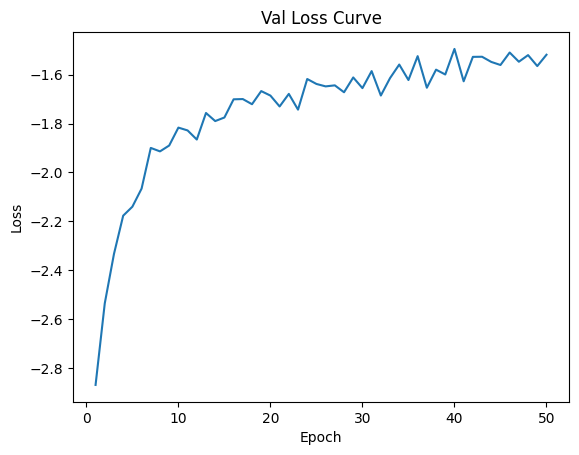

Student weights and architecture saved and exported for lambda: 10


100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:22<00:00,  1.65it/s]


*******Epoch 0: loss - 0.54717828201897


100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:22<00:00,  1.64it/s]


*******Epoch 1: loss - 0.31669974349000873


100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:22<00:00,  1.65it/s]


*******Epoch 2: loss - 0.20951652318677483


100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:42<00:00,  1.33it/s]


Average Pretrain Adversary epoch loss:  0.38094914814128594


100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:42<00:00,  1.33it/s]


Average Pretrain Adversary epoch loss:  0.38096414725570116


100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:42<00:00,  1.33it/s]


Average Pretrain Adversary epoch loss:  0.38094350191600185


100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:57<00:00,  2.36it/s]


Average Adversary epoch loss: 0.36267486192724285


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:18<00:00,  2.47it/s]


*****Epoch 1/100*****
*****Train Loss: -0.029097 Val Loss:  0.107033*****
*****Validation Accuracy: 64.04%*****
*****Total Avg Disparity: 0.1534000161176541*****

Class Team_Sports: Recall Difference = 0.04653471127459574
Class Celebration: Recall Difference = -0.05569031736405905
Class Parade: Recall Difference = 0.06399252642027209
Class Waiter_Or_Waitress: Recall Difference = -0.3445839874411303
Class Individual_Sports: Recall Difference = -0.0662716699583058
Class Surgeons: Recall Difference = -0.08869179600886923
Class Spa: Recall Difference = -0.3687943262411348
Class Law_Enforcement: Recall Difference = 0.1899779095454016
Class Business: Recall Difference = 0.09484228473998291
Class Dresses: Recall Difference = -0.6607361963190184
Class Water Activities: Recall Difference = 0.011080958842152988
Class Picnic: Recall Difference = -0.0326797385620915
Class Rescue: Recall Difference = 0.04911392405063286
Class Cheering: Recall Difference = -0.06014729950900166
Class Performance_And_

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:57<00:00,  2.37it/s]


Average Adversary epoch loss: 0.27962496153572025


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.37it/s]


*****Epoch 2/100*****
*****Train Loss: -0.015297 Val Loss:  0.137112*****
*****Validation Accuracy: 65.02%*****
*****Total Avg Disparity: 0.1377193838105742*****

Class Team_Sports: Recall Difference = 0.05579494365621551
Class Celebration: Recall Difference = -0.05417424701839507
Class Parade: Recall Difference = 0.029252058153792282
Class Waiter_Or_Waitress: Recall Difference = -0.24960753532182112
Class Individual_Sports: Recall Difference = -0.07369614512471645
Class Surgeons: Recall Difference = -0.008869179600887067
Class Spa: Recall Difference = -0.4326241134751773
Class Law_Enforcement: Recall Difference = 0.14742471805603996
Class Business: Recall Difference = -0.023870417732310245
Class Dresses: Recall Difference = -0.6975460122699386
Class Water Activities: Recall Difference = -0.004070556309362261
Class Picnic: Recall Difference = -0.12418300653594766
Class Rescue: Recall Difference = -0.00025316455696200446
Class Cheering: Recall Difference = -0.04746317512274956
Class Per

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:57<00:00,  2.38it/s]


Average Adversary epoch loss: 0.2393434575813658


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:18<00:00,  2.44it/s]


*****Epoch 3/100*****
*****Train Loss: -0.036786 Val Loss:  0.142360*****
*****Validation Accuracy: 65.89%*****
*****Total Avg Disparity: 0.1629365527672964*****

Class Team_Sports: Recall Difference = 0.07273895019559773
Class Celebration: Recall Difference = -0.03658783100869212
Class Parade: Recall Difference = 0.053891516319262034
Class Waiter_Or_Waitress: Recall Difference = -0.3571428571428572
Class Individual_Sports: Recall Difference = -0.11645088142783999
Class Surgeons: Recall Difference = -0.08203991130820393
Class Spa: Recall Difference = -0.41134751773049666
Class Law_Enforcement: Recall Difference = 0.2041623067085223
Class Business: Recall Difference = -0.002131287297527651
Class Dresses: Recall Difference = -0.6484662576687117
Class Water Activities: Recall Difference = -0.01831750339213023
Class Picnic: Recall Difference = -0.2026143790849672
Class Rescue: Recall Difference = 0.06708860759493668
Class Cheering: Recall Difference = -0.06976268412438624
Class Performance

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:57<00:00,  2.37it/s]


Average Adversary epoch loss: 0.22552752576987534


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.36it/s]


*****Epoch 4/100*****
*****Train Loss: -0.044413 Val Loss:  0.135092*****
*****Validation Accuracy: 66.00%*****
*****Total Avg Disparity: 0.16544390898331035*****

Class Team_Sports: Recall Difference = 0.020774216149938796
Class Celebration: Recall Difference = -0.06397816858702249
Class Parade: Recall Difference = 0.04373211887662731
Class Waiter_Or_Waitress: Recall Difference = -0.346938775510204
Class Individual_Sports: Recall Difference = -0.09907834101382484
Class Surgeons: Recall Difference = -0.014781966001478075
Class Spa: Recall Difference = -0.3687943262411348
Class Law_Enforcement: Recall Difference = 0.12835716777118933
Class Business: Recall Difference = 0.031756180733162775
Class Dresses: Recall Difference = -0.7423312883435583
Class Water Activities: Recall Difference = -0.048846675712347354
Class Picnic: Recall Difference = -0.20261437908496727
Class Rescue: Recall Difference = 0.07569620253164566
Class Cheering: Recall Difference = -0.17614566284779037
Class Performan

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:57<00:00,  2.36it/s]


Average Adversary epoch loss: 0.22488023264004903


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.35it/s]


*****Epoch 5/100*****
*****Train Loss: -0.045999 Val Loss:  0.138628*****
*****Validation Accuracy: 65.34%*****
*****Total Avg Disparity: 0.13583552986368863*****

Class Team_Sports: Recall Difference = 0.02605243183277861
Class Celebration: Recall Difference = -0.07580351728320195
Class Parade: Recall Difference = 0.040871139137034995
Class Waiter_Or_Waitress: Recall Difference = -0.3139717425431712
Class Individual_Sports: Recall Difference = -0.12884938921805278
Class Surgeons: Recall Difference = -0.07612712490761275
Class Spa: Recall Difference = -0.3687943262411348
Class Law_Enforcement: Recall Difference = 0.11242878735030826
Class Business: Recall Difference = -0.021739130434782705
Class Dresses: Recall Difference = -0.636196319018405
Class Water Activities: Recall Difference = 0.04093170511080968
Class Picnic: Recall Difference = -0.09150326797385622
Class Rescue: Recall Difference = 0.02506329113924055
Class Cheering: Recall Difference = -0.02577741407528633
Class Performance

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:57<00:00,  2.37it/s]


Average Adversary epoch loss: 0.21182787884026766


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.37it/s]


*****Epoch 6/100*****
*****Train Loss: -0.049468 Val Loss:  0.136331*****
*****Validation Accuracy: 65.57%*****
*****Total Avg Disparity: 0.14913607786456867*****

Class Team_Sports: Recall Difference = 0.03177439131196369
Class Celebration: Recall Difference = -0.11299777643015968
Class Parade: Recall Difference = 0.046651485957844296
Class Waiter_Or_Waitress: Recall Difference = -0.32417582417582413
Class Individual_Sports: Recall Difference = -0.05273937532002049
Class Surgeons: Recall Difference = -0.1123429416112342
Class Spa: Recall Difference = -0.347517730496454
Class Law_Enforcement: Recall Difference = 0.13103127543308912
Class Business: Recall Difference = -0.015132139812446876
Class Dresses: Recall Difference = -0.6423312883435583
Class Water Activities: Recall Difference = -0.003165988240615203
Class Picnic: Recall Difference = -0.1437908496732026
Class Rescue: Recall Difference = 0.09772151898734177
Class Cheering: Recall Difference = -0.056055646481178445
Class Performan

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:57<00:00,  2.37it/s]


Average Adversary epoch loss: 0.20506572422078428


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.35it/s]


*****Epoch 7/100*****
*****Train Loss: -0.049785 Val Loss:  0.143871*****
*****Validation Accuracy: 65.37%*****
*****Total Avg Disparity: 0.1611689364714191*****

Class Team_Sports: Recall Difference = 0.06437788287499291
Class Celebration: Recall Difference = -0.10809581564584597
Class Parade: Recall Difference = 0.07695451626087457
Class Waiter_Or_Waitress: Recall Difference = -0.3626373626373627
Class Individual_Sports: Recall Difference = -0.11092824226464781
Class Surgeons: Recall Difference = -0.07021433850702147
Class Spa: Recall Difference = -0.30496453900709225
Class Law_Enforcement: Recall Difference = 0.13370538309498903
Class Business: Recall Difference = 0.0601023017902812
Class Dresses: Recall Difference = -0.6546012269938651
Class Water Activities: Recall Difference = -0.026119402985074536
Class Picnic: Recall Difference = -0.1633986928104575
Class Rescue: Recall Difference = 0.08177215189873416
Class Cheering: Recall Difference = -0.05400981996726678
Class Performance_A

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:57<00:00,  2.36it/s]


Average Adversary epoch loss: 0.19564731397172985


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.37it/s]


*****Epoch 8/100*****
*****Train Loss: -0.049964 Val Loss:  0.145304*****
*****Validation Accuracy: 65.92%*****
*****Total Avg Disparity: 0.1634635584253901*****

Class Team_Sports: Recall Difference = 0.0398551993927716
Class Celebration: Recall Difference = -0.06751566606023851
Class Parade: Recall Difference = 0.026391078414199742
Class Waiter_Or_Waitress: Recall Difference = -0.32417582417582413
Class Individual_Sports: Recall Difference = -0.0833516202179796
Class Surgeons: Recall Difference = -0.13082039911308202
Class Spa: Recall Difference = -0.3687943262411347
Class Law_Enforcement: Recall Difference = 0.19486106266713166
Class Business: Recall Difference = 0.004475703324808178
Class Dresses: Recall Difference = -0.7343558282208589
Class Water Activities: Recall Difference = -0.033695160560832105
Class Picnic: Recall Difference = -0.2222222222222222
Class Rescue: Recall Difference = 0.12303797468354433
Class Cheering: Recall Difference = -0.026186579378068675
Class Performance

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:58<00:00,  2.33it/s]


Average Adversary epoch loss: 0.19295115434729002


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:20<00:00,  2.26it/s]


*****Epoch 9/100*****
*****Train Loss: -0.051927 Val Loss:  0.146011*****
*****Validation Accuracy: 66.52%*****
*****Total Avg Disparity: 0.1449879099744475*****

Class Team_Sports: Recall Difference = 0.026554562970747986
Class Celebration: Recall Difference = -0.05417424701839507
Class Parade: Recall Difference = 0.03789338471419401
Class Waiter_Or_Waitress: Recall Difference = -0.25745682888540034
Class Individual_Sports: Recall Difference = -0.09355570185063267
Class Surgeons: Recall Difference = -0.05764966740576499
Class Spa: Recall Difference = -0.39007092198581567
Class Law_Enforcement: Recall Difference = 0.12661318451342873
Class Business: Recall Difference = 0.0012787723785165905
Class Dresses: Recall Difference = -0.6668711656441718
Class Water Activities: Recall Difference = -0.026345545002261384
Class Picnic: Recall Difference = -0.09150326797385622
Class Rescue: Recall Difference = 0.057721518987341736
Class Cheering: Recall Difference = -0.11333878887070375
Class Perfor

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:59<00:00,  2.27it/s]


Average Adversary epoch loss: 0.1853719352032332


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:20<00:00,  2.28it/s]


*****Epoch 10/100*****
*****Train Loss: -0.050132 Val Loss:  0.144514*****
*****Validation Accuracy: 66.46%*****
*****Total Avg Disparity: 0.15844613445215117*****

Class Team_Sports: Recall Difference = 0.07223681905762847
Class Celebration: Recall Difference = -0.028299979785728735
Class Parade: Recall Difference = 0.08419454662229242
Class Waiter_Or_Waitress: Recall Difference = -0.249607535321821
Class Individual_Sports: Recall Difference = -0.05851803086826113
Class Surgeons: Recall Difference = -0.03325942350332589
Class Spa: Recall Difference = -0.326241134751773
Class Law_Enforcement: Recall Difference = 0.1549819788396698
Class Business: Recall Difference = -0.03346121057118501
Class Dresses: Recall Difference = -0.6484662576687116
Class Water Activities: Recall Difference = -0.018995929443690773
Class Picnic: Recall Difference = -0.31372549019607837
Class Rescue: Recall Difference = 0.12506329113924053
Class Cheering: Recall Difference = -0.10372340425531912
Class Performance

100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:00<00:00,  2.26it/s]


Average Adversary epoch loss: 0.1828839004806736


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:20<00:00,  2.29it/s]


*****Epoch 11/100*****
*****Train Loss: -0.049146 Val Loss:  0.151908*****
*****Validation Accuracy: 65.86%*****
*****Total Avg Disparity: 0.16556999955407792*****

Class Team_Sports: Recall Difference = 0.045413674315408326
Class Celebration: Recall Difference = -0.036436223974125714
Class Parade: Recall Difference = -0.0009925848076136612
Class Waiter_Or_Waitress: Recall Difference = -0.37284144427001575
Class Individual_Sports: Recall Difference = -0.038109867602955205
Class Surgeons: Recall Difference = -0.04582409460458242
Class Spa: Recall Difference = -0.39007092198581567
Class Law_Enforcement: Recall Difference = 0.09336123706545763
Class Business: Recall Difference = -0.04560954816709284
Class Dresses: Recall Difference = -0.6975460122699387
Class Water Activities: Recall Difference = 0.033808231569425695
Class Picnic: Recall Difference = -0.3856209150326797
Class Rescue: Recall Difference = 0.12632911392405055
Class Cheering: Recall Difference = -0.09819967266775775
Class Per

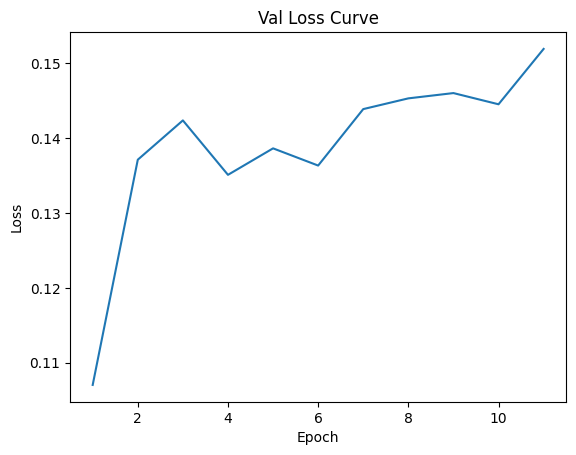

Student weights and architecture saved and exported for lambda: 0.5


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:20<00:00,  2.29it/s]


*****Epoch 1/100*****
*****Train Loss:  0.543151 Val Loss:  0.243381*****
*****Validation Accuracy: 60.89%*****
*****Total Avg Disparity: 0.16289019552712286*****

Class Team_Sports: Recall Difference = 0.09653763064167686
Class Celebration: Recall Difference = -0.05872245805538712
Class Parade: Recall Difference = 0.07987388334209133
Class Waiter_Or_Waitress: Recall Difference = -0.30141287284144425
Class Individual_Sports: Recall Difference = -0.06985589934898706
Class Surgeons: Recall Difference = -0.08795269770879527
Class Spa: Recall Difference = -0.41134751773049644
Class Law_Enforcement: Recall Difference = 0.21253342634577377
Class Business: Recall Difference = 0.03601875532821819
Class Dresses: Recall Difference = -0.7791411042944786
Class Water Activities: Recall Difference = 0.034486657620986017
Class Picnic: Recall Difference = -0.30718954248366015
Class Rescue: Recall Difference = 0.025822784810126592
Class Cheering: Recall Difference = -0.0585106382978724
Class Performanc

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.33it/s]


*****Epoch 2/100*****
*****Train Loss:  0.317382 Val Loss:  0.244526*****
*****Validation Accuracy: 62.80%*****
*****Total Avg Disparity: 0.1858867097811659*****

Class Team_Sports: Recall Difference = 0.10837858352309226
Class Celebration: Recall Difference = -0.07580351728320195
Class Parade: Recall Difference = 0.07269224032229804
Class Waiter_Or_Waitress: Recall Difference = -0.3343799058084772
Class Individual_Sports: Recall Difference = -0.03646404798478531
Class Surgeons: Recall Difference = -0.16703621581670347
Class Spa: Recall Difference = -0.43262411347517743
Class Law_Enforcement: Recall Difference = 0.23381002209045454
Class Business: Recall Difference = 0.004475703324808178
Class Dresses: Recall Difference = -0.7730061349693252
Class Water Activities: Recall Difference = 0.048733604703753985
Class Picnic: Recall Difference = -0.2549019607843137
Class Rescue: Recall Difference = 0.009113924050632882
Class Cheering: Recall Difference = -0.03621112929623568
Class Performance

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.32it/s]


*****Epoch 3/100*****
*****Train Loss:  0.211067 Val Loss:  0.266337*****
*****Validation Accuracy: 63.90%*****
*****Total Avg Disparity: 0.15985177651301674*****

Class Team_Sports: Recall Difference = 0.09821918608045799
Class Celebration: Recall Difference = -0.028299979785728735
Class Parade: Recall Difference = 0.05686927074210313
Class Waiter_Or_Waitress: Recall Difference = -0.3037676609105181
Class Individual_Sports: Recall Difference = -0.13243361860873393
Class Surgeons: Recall Difference = -0.1855136733185515
Class Spa: Recall Difference = -0.4539007092198581
Class Law_Enforcement: Recall Difference = 0.13417044529705868
Class Business: Recall Difference = 0.025149190110826947
Class Dresses: Recall Difference = -0.7036809815950921
Class Water Activities: Recall Difference = 0.03403437358661232
Class Picnic: Recall Difference = -0.215686274509804
Class Rescue: Recall Difference = 0.018987341772152
Class Cheering: Recall Difference = -0.08285597381342058
Class Performance_And_

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.31it/s]


*****Epoch 4/100*****
*****Train Loss:  0.140294 Val Loss:  0.260381*****
*****Validation Accuracy: 64.65%*****
*****Total Avg Disparity: 0.1290749744896349*****

Class Team_Sports: Recall Difference = 0.028855024230746595
Class Celebration: Recall Difference = -0.006670709520921747
Class Parade: Recall Difference = 0.07695451626087457
Class Waiter_Or_Waitress: Recall Difference = -0.2778649921507066
Class Individual_Sports: Recall Difference = -0.10624679979518681
Class Surgeons: Recall Difference = -0.12490761271249085
Class Spa: Recall Difference = -0.07801418439716334
Class Law_Enforcement: Recall Difference = 0.03220555749331466
Class Business: Recall Difference = 0.01747655583972718
Class Dresses: Recall Difference = -0.6300613496932514
Class Water Activities: Recall Difference = 0.07078245137946637
Class Picnic: Recall Difference = -0.27450980392156854
Class Rescue: Recall Difference = 0.10227848101265818
Class Cheering: Recall Difference = -0.0419394435351883
Class Performance_

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.30it/s]


*****Epoch 5/100*****
*****Train Loss:  0.101052 Val Loss:  0.268444*****
*****Validation Accuracy: 64.59%*****
*****Total Avg Disparity: 0.1300123986373602*****

Class Team_Sports: Recall Difference = 0.07363811525661235
Class Celebration: Recall Difference = -0.02713765918738642
Class Parade: Recall Difference = 0.09429555672330237
Class Waiter_Or_Waitress: Recall Difference = -0.36263736263736257
Class Individual_Sports: Recall Difference = -0.05412917855314159
Class Surgeons: Recall Difference = -0.002956393200295504
Class Spa: Recall Difference = -0.3687943262411347
Class Law_Enforcement: Recall Difference = 0.10975467968840835
Class Business: Recall Difference = 0.01747655583972718
Class Dresses: Recall Difference = -0.5809815950920246
Class Water Activities: Recall Difference = 0.04183627317955674
Class Picnic: Recall Difference = -0.14379084967320271
Class Rescue: Recall Difference = -0.01088607594936708
Class Cheering: Recall Difference = -0.06669394435351877
Class Performance

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:20<00:00,  2.27it/s]


*****Epoch 6/100*****
*****Train Loss:  0.080978 Val Loss:  0.259583*****
*****Validation Accuracy: 64.85%*****
*****Total Avg Disparity: 0.1595756846188322*****

Class Team_Sports: Recall Difference = 0.06965609855783284
Class Celebration: Recall Difference = -0.041489791793005826
Class Parade: Recall Difference = 0.09429555672330237
Class Waiter_Or_Waitress: Recall Difference = -0.23704866562009408
Class Individual_Sports: Recall Difference = -0.08086460390607864
Class Surgeons: Recall Difference = -0.12490761271249073
Class Spa: Recall Difference = -0.4751773049645391
Class Law_Enforcement: Recall Difference = 0.08847808394372747
Class Business: Recall Difference = 0.01662404092071601
Class Dresses: Recall Difference = -0.6423312883435583
Class Water Activities: Recall Difference = 0.0028267752148348757
Class Picnic: Recall Difference = -0.2941176470588235
Class Rescue: Recall Difference = 0.10835443037974685
Class Cheering: Recall Difference = -0.09308510638297868
Class Performance

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.31it/s]


*****Epoch 7/100*****
*****Train Loss:  0.069017 Val Loss:  0.256748*****
*****Validation Accuracy: 65.95%*****
*****Total Avg Disparity: 0.17502329959447438*****

Class Team_Sports: Recall Difference = 0.08783791673965091
Class Celebration: Recall Difference = -0.07428744693753786
Class Parade: Recall Difference = 0.06247445553803932
Class Waiter_Or_Waitress: Recall Difference = -0.33673469387755106
Class Individual_Sports: Recall Difference = -0.10928242264647803
Class Surgeons: Recall Difference = -0.008869179600886845
Class Spa: Recall Difference = -0.49645390070921996
Class Law_Enforcement: Recall Difference = 0.1780025578421114
Class Business: Recall Difference = 0.07203751065643649
Class Dresses: Recall Difference = -0.6484662576687117
Class Water Activities: Recall Difference = 0.04093170511080957
Class Picnic: Recall Difference = -0.2745098039215686
Class Rescue: Recall Difference = 0.05898734177215187
Class Cheering: Recall Difference = -0.09206219312602293
Class Performance_

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.32it/s]


*****Epoch 8/100*****
*****Train Loss:  0.062268 Val Loss:  0.261861*****
*****Validation Accuracy: 65.22%*****
*****Total Avg Disparity: 0.16450371136465347*****

Class Team_Sports: Recall Difference = 0.03637531383196135
Class Celebration: Recall Difference = -0.09930260764099463
Class Parade: Recall Difference = 0.08997489344310161
Class Waiter_Or_Waitress: Recall Difference = -0.27786499215070626
Class Individual_Sports: Recall Difference = -0.0541291785531417
Class Surgeons: Recall Difference = -0.1426459719142646
Class Spa: Recall Difference = -0.4539007092198583
Class Law_Enforcement: Recall Difference = 0.1102197418904779
Class Business: Recall Difference = 0.07075873827791984
Class Dresses: Recall Difference = -0.6748466257668712
Class Water Activities: Recall Difference = 0.01910900045228403
Class Picnic: Recall Difference = -0.2549019607843137
Class Rescue: Recall Difference = 0.012405063291139218
Class Cheering: Recall Difference = -0.06014729950900155
Class Performance_And

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:20<00:00,  2.28it/s]


*****Epoch 9/100*****
*****Train Loss:  0.057162 Val Loss:  0.261326*****
*****Validation Accuracy: 65.17%*****
*****Total Avg Disparity: 0.1524208395116216*****

Class Team_Sports: Recall Difference = 0.0872773982600572
Class Celebration: Recall Difference = -0.008035172832019266
Class Parade: Recall Difference = 0.07555322006189058
Class Waiter_Or_Waitress: Recall Difference = -0.2755102040816326
Class Individual_Sports: Recall Difference = -0.028198376124643487
Class Surgeons: Recall Difference = -0.02734663710273466
Class Spa: Recall Difference = -0.4751773049645391
Class Law_Enforcement: Recall Difference = 0.15184280897570035
Class Business: Recall Difference = 0.04475703324808189
Class Dresses: Recall Difference = -0.7466257668711657
Class Water Activities: Recall Difference = 0.01085481682496603
Class Picnic: Recall Difference = -0.23529411764705876
Class Rescue: Recall Difference = -0.0075949367088607445
Class Cheering: Recall Difference = -0.05360065466448449
Class Performanc

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:20<00:00,  2.23it/s]


*****Epoch 10/100*****
*****Train Loss:  0.055647 Val Loss:  0.246583*****
*****Validation Accuracy: 66.52%*****
*****Total Avg Disparity: 0.15632070849434648*****

Class Team_Sports: Recall Difference = 0.034915630291352806
Class Celebration: Recall Difference = -0.09591671720234479
Class Parade: Recall Difference = 0.08991650610147717
Class Waiter_Or_Waitress: Recall Difference = -0.22684458398744112
Class Individual_Sports: Recall Difference = -0.02406554019457252
Class Surgeons: Recall Difference = -0.014781966001478075
Class Spa: Recall Difference = -0.43262411347517743
Class Law_Enforcement: Recall Difference = 0.12393907685152883
Class Business: Recall Difference = 0.013213981244671658
Class Dresses: Recall Difference = -0.7484662576687117
Class Water Activities: Recall Difference = 0.011080958842152877
Class Picnic: Recall Difference = -0.2026143790849672
Class Rescue: Recall Difference = 0.11772151898734168
Class Cheering: Recall Difference = -0.07078559738134199
Class Perform

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:20<00:00,  2.29it/s]


*****Epoch 11/100*****
*****Train Loss:  0.051238 Val Loss:  0.247800*****
*****Validation Accuracy: 65.80%*****
*****Total Avg Disparity: 0.14613500759143053*****

Class Team_Sports: Recall Difference = 0.05601681555438798
Class Celebration: Recall Difference = -0.02764301596927432
Class Parade: Recall Difference = 0.027850761954808068
Class Waiter_Or_Waitress: Recall Difference = -0.35478806907378324
Class Individual_Sports: Recall Difference = -0.027649769585253448
Class Surgeons: Recall Difference = -0.11825572801182566
Class Spa: Recall Difference = -0.39007092198581567
Class Law_Enforcement: Recall Difference = 0.08405999302406686
Class Business: Recall Difference = -0.005115089514066584
Class Dresses: Recall Difference = -0.6239263803680982
Class Water Activities: Recall Difference = 0.003505201266395308
Class Picnic: Recall Difference = -0.16339869281045744
Class Rescue: Recall Difference = 0.07569620253164555
Class Cheering: Recall Difference = -0.09963175122749585
Class Perfo

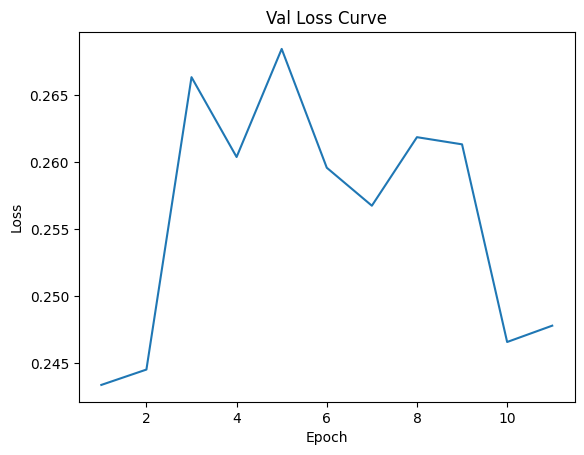

Student weights and architecture saved and exported for lambda: 0


In [23]:
lambda_results = {}
# Loop for training the student model with different lambda values
for i in lmda_list_student:
    # load teacher model with lambda 0
    teacher_model = torch.load('teacher_model_ckd_wider_lambda02.pth')
    teacher_model.load_state_dict(torch.load('teacher_model_weights_ckd_wider_lambda02.pth'))
    
    # Reset the student model for each lambda
    student_model = torchvision.models.efficientnet_b0(weights='DEFAULT')
    student_model.classifier = nn.Linear(1280, num_classes)
    student_optimizer = optim.Adam(student_model.parameters(), lr=learning_rate)

    adv = Adversary()
    student_optimizer_adv = optim.Adam(adv.parameters(), lr=learning_rate)
    
    if i != 0:
        pretrain_student(student_model, teacher_model, trainloader, criterion_clf, student_optimizer, device, alpha, temperature, epochs_pretrain)
        pretrain_adversary(adv, teacher_model, optimizer_adv, trainloader, adv_criterion, device, epochs_pretrain)
    
    student_mean_abs_val_disparity = train_student_with_distillation_disparity(student_model, teacher_model, adv, trainloader, testloader, criterion_clf, adv_criterion, student_optimizer, device, alpha, temperature, epochs, lmda=i, patience=patience_student, optimizer_adv=student_optimizer_adv)

    torch.save(student_model.state_dict(), f'student_model_weights_ckd_wider_lambda{i}.pth')
    torch.save(student_model, f'student_model_ckd_wider_lambda{i}.pth')
    print('Student weights and architecture saved and exported for lambda:', i)

    # Update the dictionary with the student results
    if i in lambda_results:
        # If the key 'i' is already present in the dictionary
        lambda_results[i].update({
            'student_mean_abs_val_disparity': student_mean_abs_val_disparity
        })
    else:
        # If the key 'i' is not present in the dictionary
        lambda_results[i] = {
            'student_mean_abs_val_disparity': student_mean_abs_val_disparity
        }

In [24]:
def compare_performance_metrics(teacher, student, dataloader):
    teacher.eval()
    student.eval()
    
    all_labels = []
    all_teacher_preds = []
    all_student_preds = []

    for batch in dataloader:
        inputs = batch['img'].to(device)
        labels = batch['label'].to(device)
        
        with torch.no_grad():
            teacher_outputs = teacher(inputs)
            student_outputs = student(inputs)
            
        teacher_preds = torch.argmax(teacher_outputs, dim=1).cpu().numpy()
        student_preds = torch.argmax(student_outputs, dim=1).cpu().numpy()
        
        all_labels.append(labels.cpu().numpy())
        all_teacher_preds.append(teacher_preds)
        all_student_preds.append(student_preds)

    all_labels = np.concatenate(all_labels)
    all_teacher_preds = np.concatenate(all_teacher_preds)
    all_student_preds = np.concatenate(all_student_preds)
    
    metrics = {
        'accuracy': (accuracy_score(all_labels, all_teacher_preds), accuracy_score(all_labels, all_student_preds)),
        'precision': (precision_score(all_labels, all_teacher_preds, average='weighted', zero_division=0), precision_score(all_labels, all_student_preds, average='weighted', zero_division=0)),
        'recall': (recall_score(all_labels, all_teacher_preds, average='weighted'), recall_score(all_labels, all_student_preds, average='weighted')),
        'f1': (f1_score(all_labels, all_teacher_preds, average='weighted'), f1_score(all_labels, all_student_preds, average='weighted'))
    }

    return {
        'metrics': metrics,
        'all_labels': all_labels,
        'all_teacher_preds': all_teacher_preds,
        'all_student_preds': all_student_preds
    }

def compare_model_size(teacher, student):
    teacher_params = sum(p.numel() for p in teacher.parameters())
    student_params = sum(p.numel() for p in student.parameters())
    return teacher_params, student_params

def compare_inference_time(teacher, student, dataloader):
    dataiter = iter(dataloader)
    data = next(dataiter)
    inputs = data['img']
    
    teacher = teacher.to(device)
    student = student.to(device)
    inputs = inputs.to(device)
    
    start_time = time.time()
    with torch.no_grad():
        teacher_outputs = teacher(inputs)
    teacher_time = time.time() - start_time

    start_time = time.time()
    with torch.no_grad():
        student_outputs = student(inputs)
    student_time = time.time() - start_time
    
    return teacher_time, student_time

In [25]:
# Loop through each lambda value
for lmda in lmda_list_student:
    # Load teacher and student models for the current lambda
    teacher_model = torch.load(f'teacher_model_ckd_wider_lambda02.pth')
    student_model = torch.load(f'student_model_ckd_wider_lambda{lmda}.pth')

    # Compute performance metrics
    performance_metrics = compare_performance_metrics(teacher_model, student_model, testloader)

    # Compute model sizes and inference times
    teacher_params, student_params = compare_model_size(teacher_model, student_model)
    teacher_time, student_time = compare_inference_time(teacher_model, student_model, testloader)

    # Update results for the current lambda value
    if lmda in lambda_results:
        lambda_results[lmda].update({
            'performance_metrics': performance_metrics,
            'teacher_params': teacher_params,
            'student_params': student_params,
            'teacher_time': teacher_time,
            'student_time': student_time
        })
    else:
        lambda_results[lmda] = {
            'performance_metrics': performance_metrics,
            'teacher_params': teacher_params,
            'student_params': student_params,
            'teacher_time': teacher_time,
            'student_time': student_time
        }


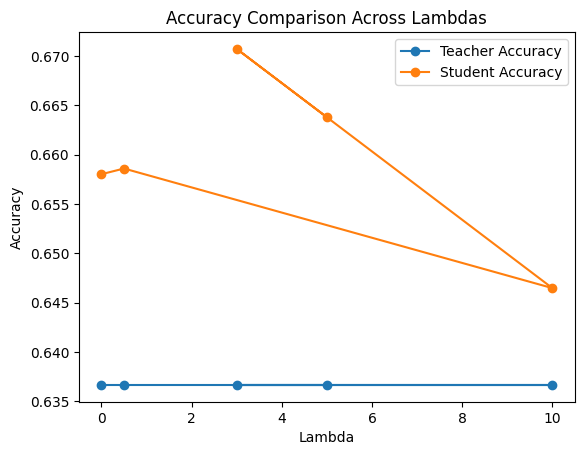

In [26]:
lambdas = list(lambda_results.keys())
teacher_accuracies = [lambda_results[lmda]['performance_metrics']['metrics']['accuracy'][0] for lmda in lambdas]
student_accuracies = [lambda_results[lmda]['performance_metrics']['metrics']['accuracy'][1] for lmda in lambdas]

plt.plot(lambdas, teacher_accuracies, label='Teacher Accuracy', marker='o')
plt.plot(lambdas, student_accuracies, label='Student Accuracy', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison Across Lambdas')
plt.legend()
plt.show()


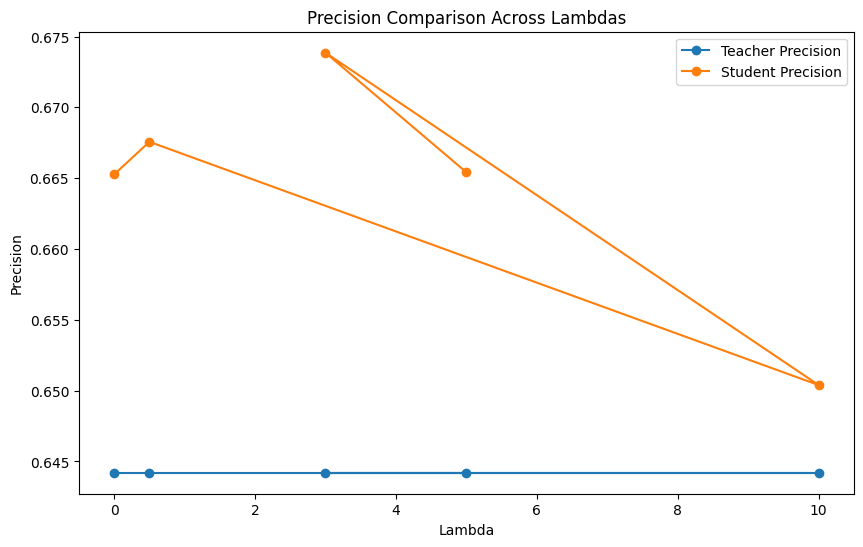

In [27]:
# Precision
teacher_precisions = [lambda_results[lmda]['performance_metrics']['metrics']['precision'][0] for lmda in lambdas]
student_precisions = [lambda_results[lmda]['performance_metrics']['metrics']['precision'][1] for lmda in lambdas]

plt.figure(figsize=(10, 6))
plt.plot(lambdas, teacher_precisions, label='Teacher Precision', marker='o')
plt.plot(lambdas, student_precisions, label='Student Precision', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Precision')
plt.title('Precision Comparison Across Lambdas')
plt.legend()
plt.show()


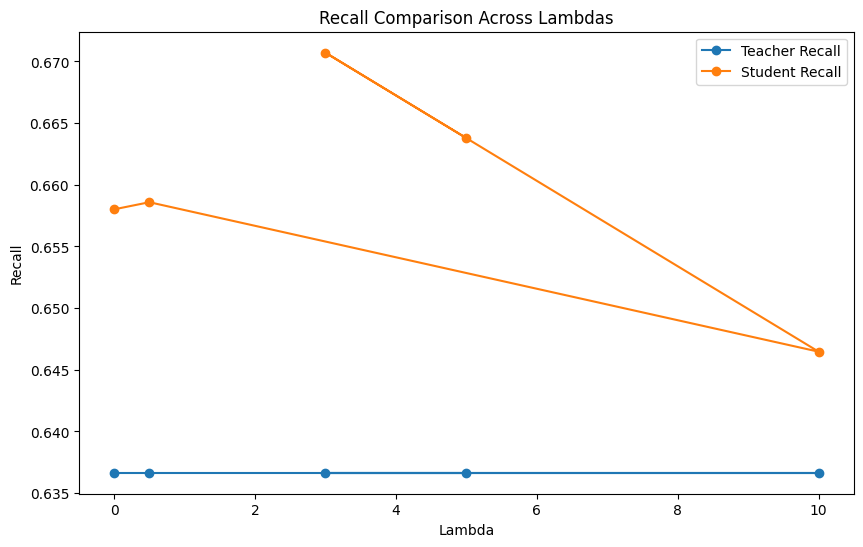

In [28]:
# Recall
teacher_recalls = [lambda_results[lmda]['performance_metrics']['metrics']['recall'][0] for lmda in lambdas]
student_recalls = [lambda_results[lmda]['performance_metrics']['metrics']['recall'][1] for lmda in lambdas]

plt.figure(figsize=(10, 6))
plt.plot(lambdas, teacher_recalls, label='Teacher Recall', marker='o')
plt.plot(lambdas, student_recalls, label='Student Recall', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Recall')
plt.title('Recall Comparison Across Lambdas')
plt.legend()
plt.show()


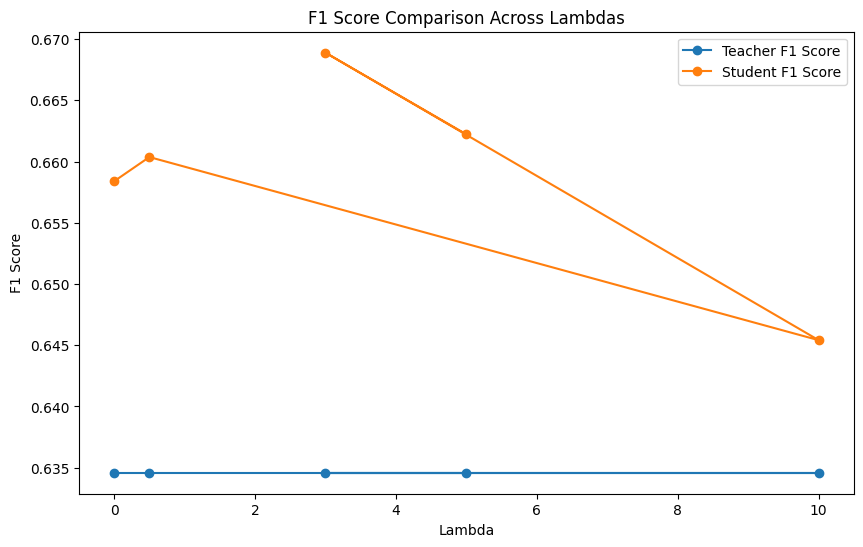

In [29]:
# F1 Score
teacher_f1s = [lambda_results[lmda]['performance_metrics']['metrics']['f1'][0] for lmda in lambdas]
student_f1s = [lambda_results[lmda]['performance_metrics']['metrics']['f1'][1] for lmda in lambdas]

plt.figure(figsize=(10, 6))
plt.plot(lambdas, teacher_f1s, label='Teacher F1 Score', marker='o')
plt.plot(lambdas, student_f1s, label='Student F1 Score', marker='o')
plt.xlabel('Lambda')
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison Across Lambdas')
plt.legend()
plt.show()


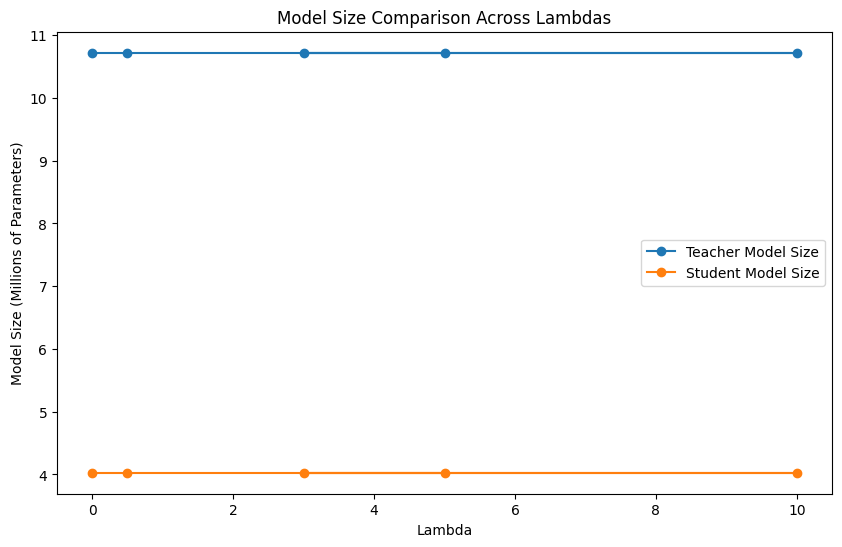

In [30]:
# Model Size
teacher_sizes = [lambda_results[lmda]['teacher_params'] / 1e6 for lmda in lambdas]  # Convert to millions
student_sizes = [lambda_results[lmda]['student_params'] / 1e6 for lmda in lambdas]

plt.figure(figsize=(10, 6))
plt.plot(lambdas, teacher_sizes, label='Teacher Model Size', marker='o')
plt.plot(lambdas, student_sizes, label='Student Model Size', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Model Size (Millions of Parameters)')
plt.title('Model Size Comparison Across Lambdas')
plt.legend()
plt.show()


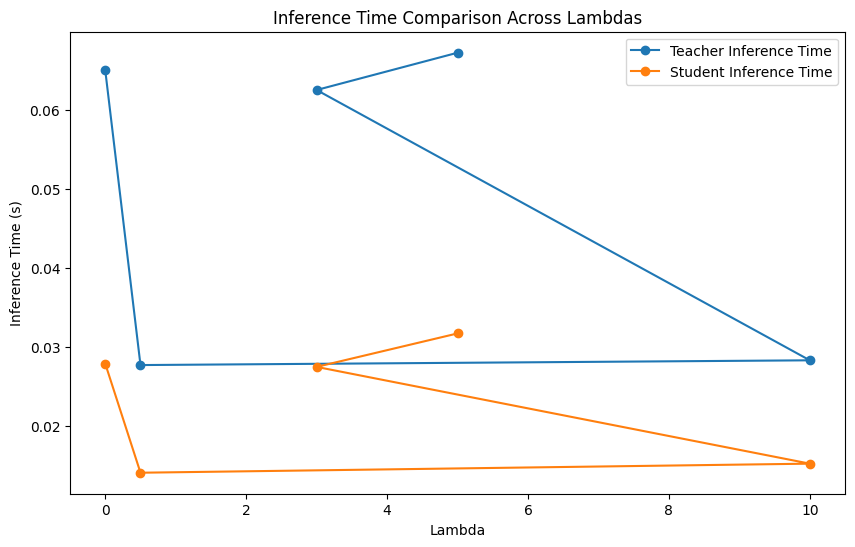

In [31]:
# Inference Time
teacher_times = [lambda_results[lmda]['teacher_time'] for lmda in lambdas]
student_times = [lambda_results[lmda]['student_time'] for lmda in lambdas]

plt.figure(figsize=(10, 6))
plt.plot(lambdas, teacher_times, label='Teacher Inference Time', marker='o')
plt.plot(lambdas, student_times, label='Student Inference Time', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Inference Time (s)')
plt.title('Inference Time Comparison Across Lambdas')
plt.legend()
plt.show()


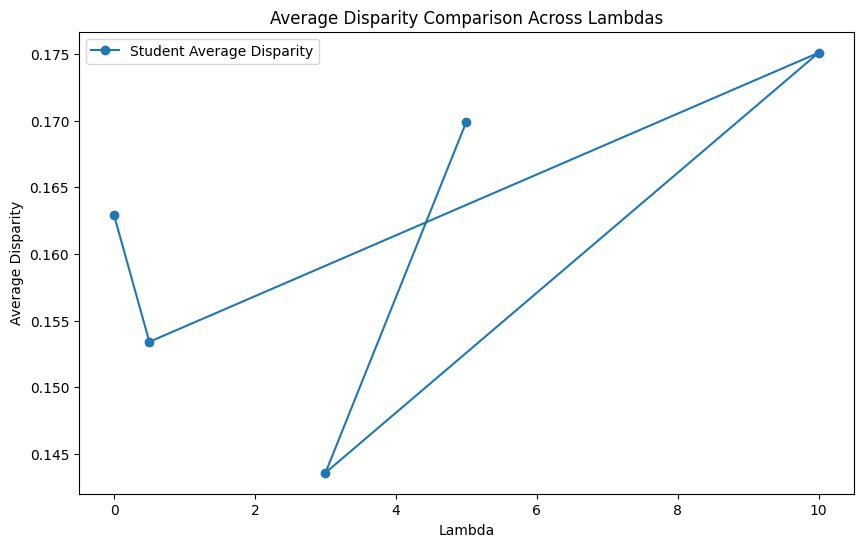

In [32]:
# Extracting disparity values for both teacher and student models
student_disparities = [lambda_results[lmda]['student_mean_abs_val_disparity'] for lmda in lambdas]

plt.figure(figsize=(10, 6))
plt.plot(lambdas, student_disparities, label='Student Average Disparity', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Average Disparity')
plt.title('Average Disparity Comparison Across Lambdas')
plt.legend()
plt.show()


In [33]:
lambda_results

{5: {'student_mean_abs_val_disparity': 0.16993443807802908,
  'performance_metrics': {'metrics': {'accuracy': (0.6366522366522367,
     0.6637806637806638),
    'precision': (0.6442057230259768, 0.665414550693579),
    'recall': (0.6366522366522367, 0.6637806637806638),
    'f1': (0.6345895375795748, 0.6622179107524006)},
   'all_labels': array([ 2,  2,  2, ..., 13, 13, 13]),
   'all_teacher_preds': array([ 2,  2,  2, ..., 13,  2,  0]),
   'all_student_preds': array([7, 2, 2, ..., 8, 2, 0])},
  'teacher_params': 10720824,
  'student_params': 4028044,
  'teacher_time': 0.0672922134399414,
  'student_time': 0.031752586364746094},
 3: {'student_mean_abs_val_disparity': 0.14357080178514248,
  'performance_metrics': {'metrics': {'accuracy': (0.6366522366522367,
     0.6707070707070707),
    'precision': (0.6442057230259768, 0.6738568929615694),
    'recall': (0.6366522366522367, 0.6707070707070707),
    'f1': (0.6345895375795748, 0.6688830607626708)},
   'all_labels': array([ 2,  2,  2, ...

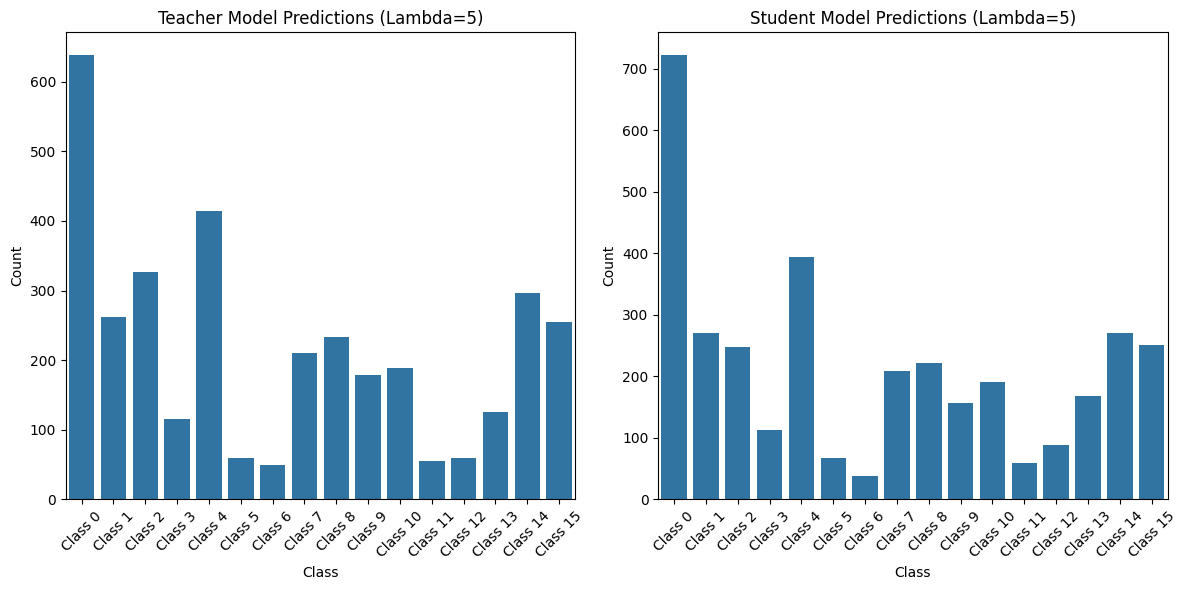

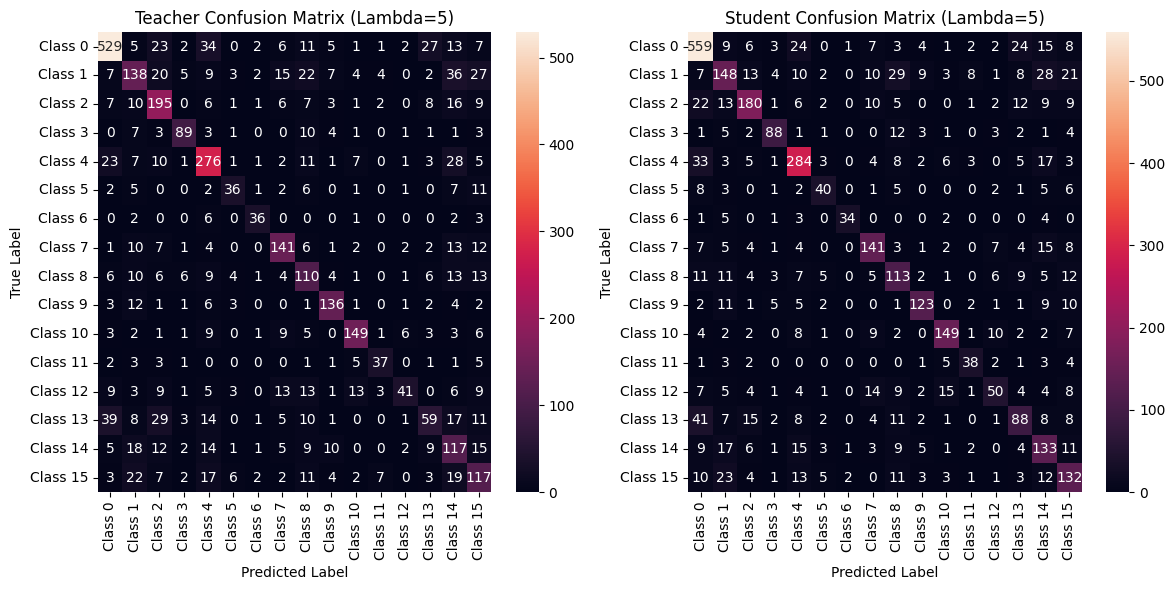

Classification Report - Teacher Model (Lambda=5)
              precision    recall  f1-score   support

     Class 0       0.83      0.79      0.81       668
     Class 1       0.53      0.46      0.49       301
     Class 2       0.60      0.72      0.65       272
     Class 3       0.77      0.72      0.74       124
     Class 4       0.67      0.73      0.70       377
     Class 5       0.61      0.49      0.54        74
     Class 6       0.73      0.72      0.73        50
     Class 7       0.67      0.70      0.68       202
     Class 8       0.47      0.57      0.52       194
     Class 9       0.76      0.79      0.77       173
    Class 10       0.79      0.75      0.77       199
    Class 11       0.67      0.62      0.64        60
    Class 12       0.69      0.32      0.44       129
    Class 13       0.47      0.30      0.36       198
    Class 14       0.40      0.53      0.45       220
    Class 15       0.46      0.52      0.49       224

    accuracy                   

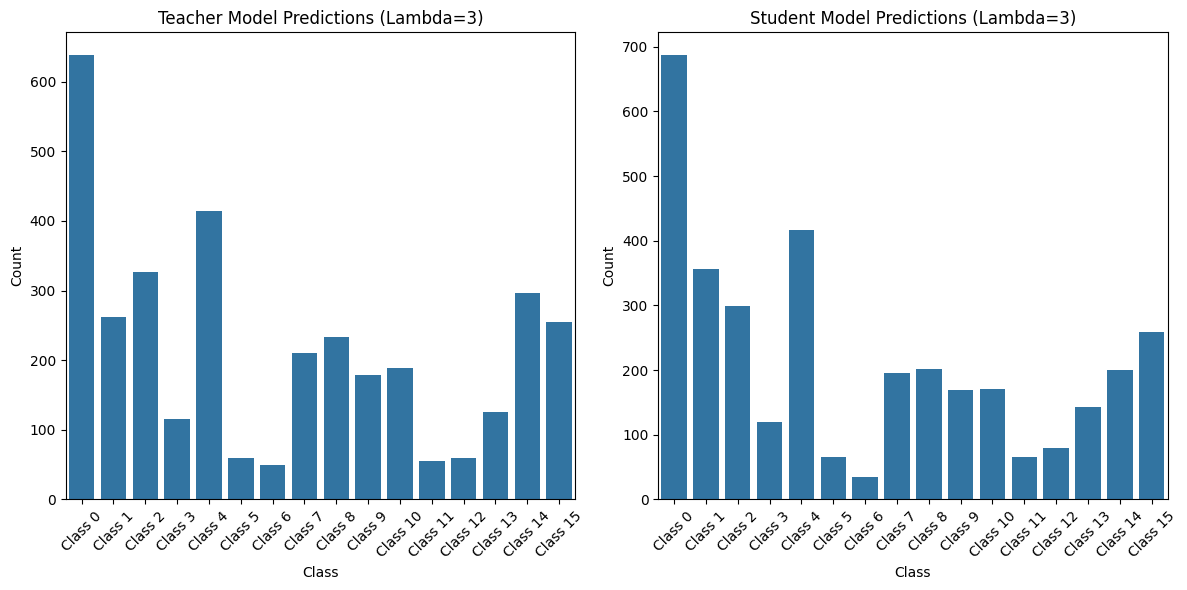

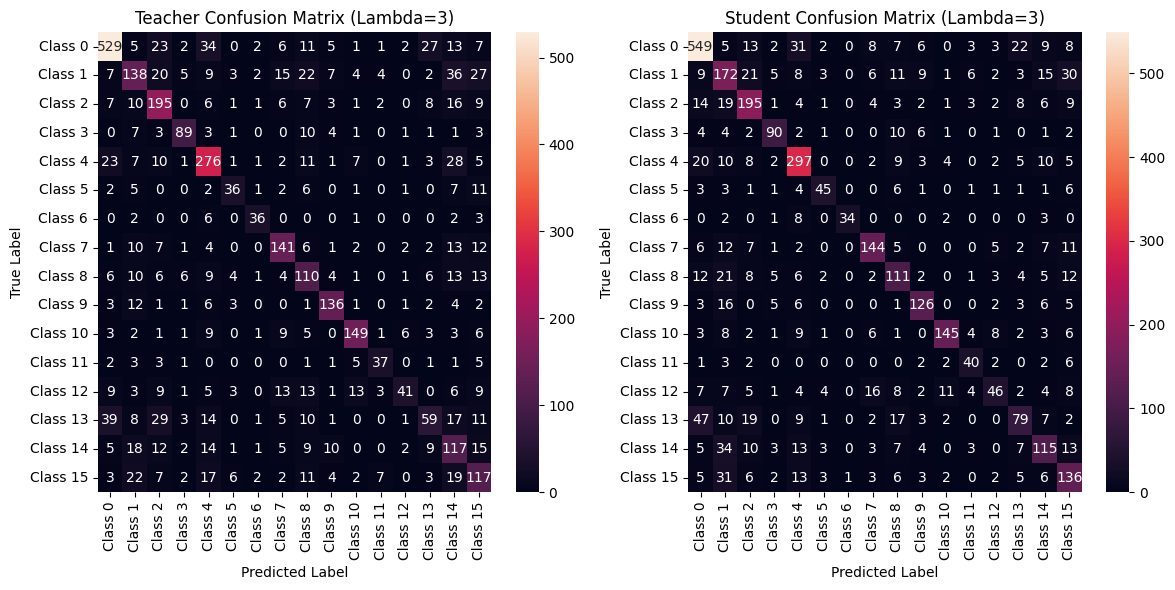

Classification Report - Teacher Model (Lambda=3)
              precision    recall  f1-score   support

     Class 0       0.83      0.79      0.81       668
     Class 1       0.53      0.46      0.49       301
     Class 2       0.60      0.72      0.65       272
     Class 3       0.77      0.72      0.74       124
     Class 4       0.67      0.73      0.70       377
     Class 5       0.61      0.49      0.54        74
     Class 6       0.73      0.72      0.73        50
     Class 7       0.67      0.70      0.68       202
     Class 8       0.47      0.57      0.52       194
     Class 9       0.76      0.79      0.77       173
    Class 10       0.79      0.75      0.77       199
    Class 11       0.67      0.62      0.64        60
    Class 12       0.69      0.32      0.44       129
    Class 13       0.47      0.30      0.36       198
    Class 14       0.40      0.53      0.45       220
    Class 15       0.46      0.52      0.49       224

    accuracy                   

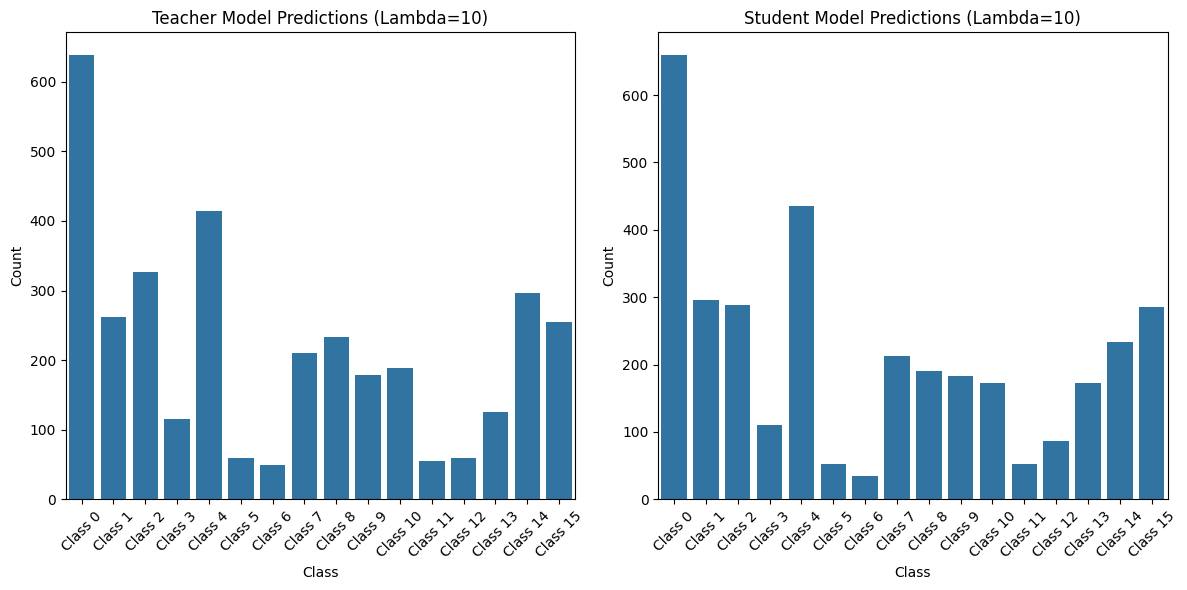

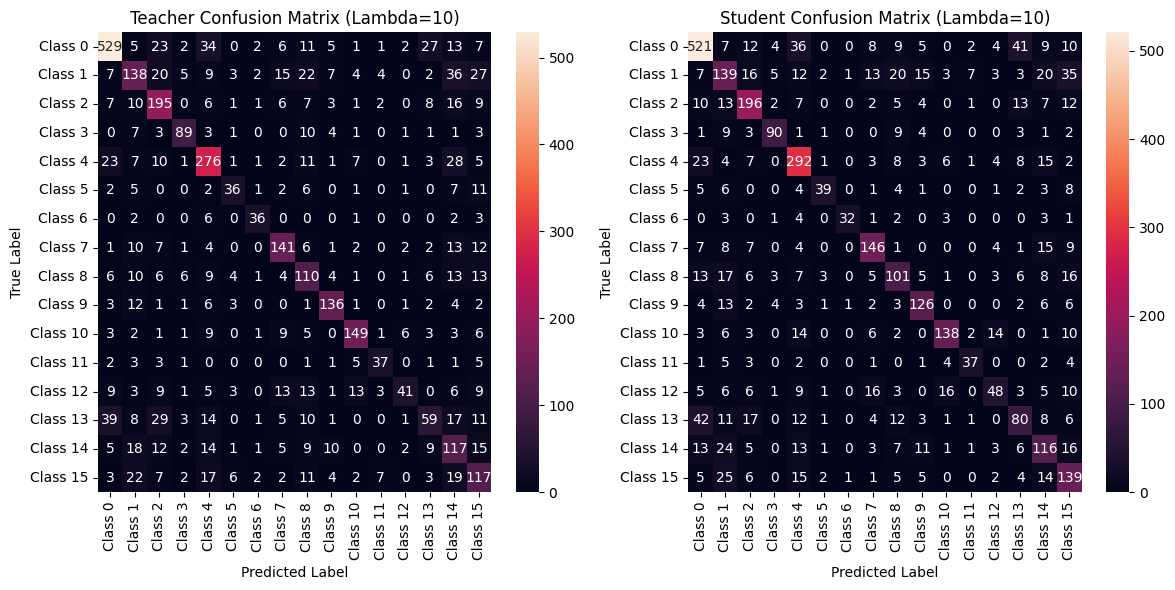

Classification Report - Teacher Model (Lambda=10)
              precision    recall  f1-score   support

     Class 0       0.83      0.79      0.81       668
     Class 1       0.53      0.46      0.49       301
     Class 2       0.60      0.72      0.65       272
     Class 3       0.77      0.72      0.74       124
     Class 4       0.67      0.73      0.70       377
     Class 5       0.61      0.49      0.54        74
     Class 6       0.73      0.72      0.73        50
     Class 7       0.67      0.70      0.68       202
     Class 8       0.47      0.57      0.52       194
     Class 9       0.76      0.79      0.77       173
    Class 10       0.79      0.75      0.77       199
    Class 11       0.67      0.62      0.64        60
    Class 12       0.69      0.32      0.44       129
    Class 13       0.47      0.30      0.36       198
    Class 14       0.40      0.53      0.45       220
    Class 15       0.46      0.52      0.49       224

    accuracy                  

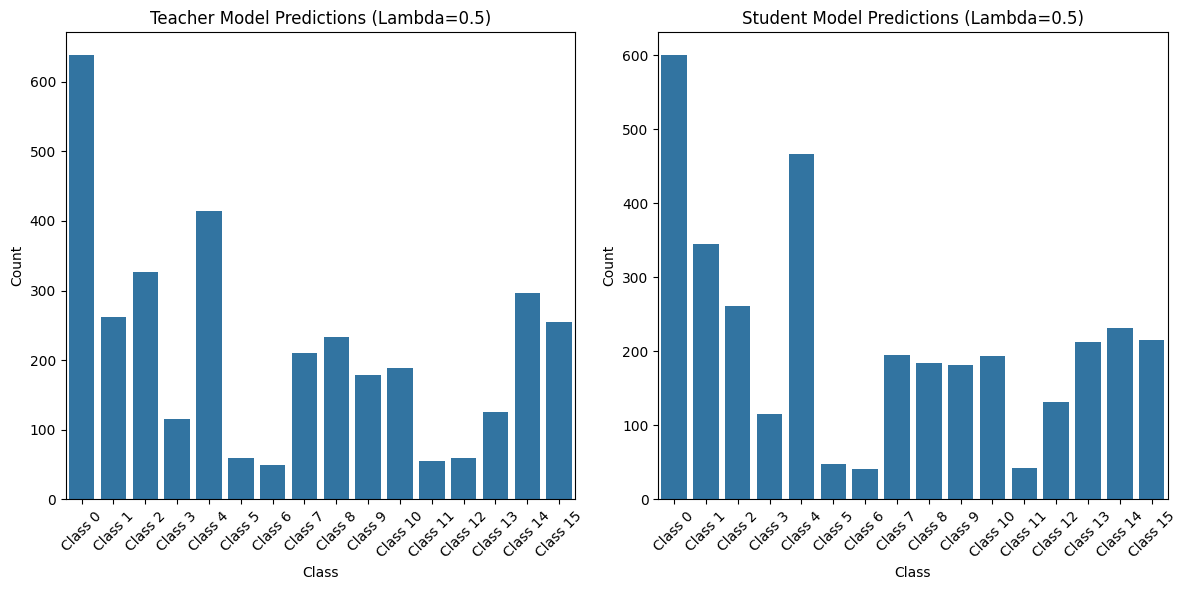

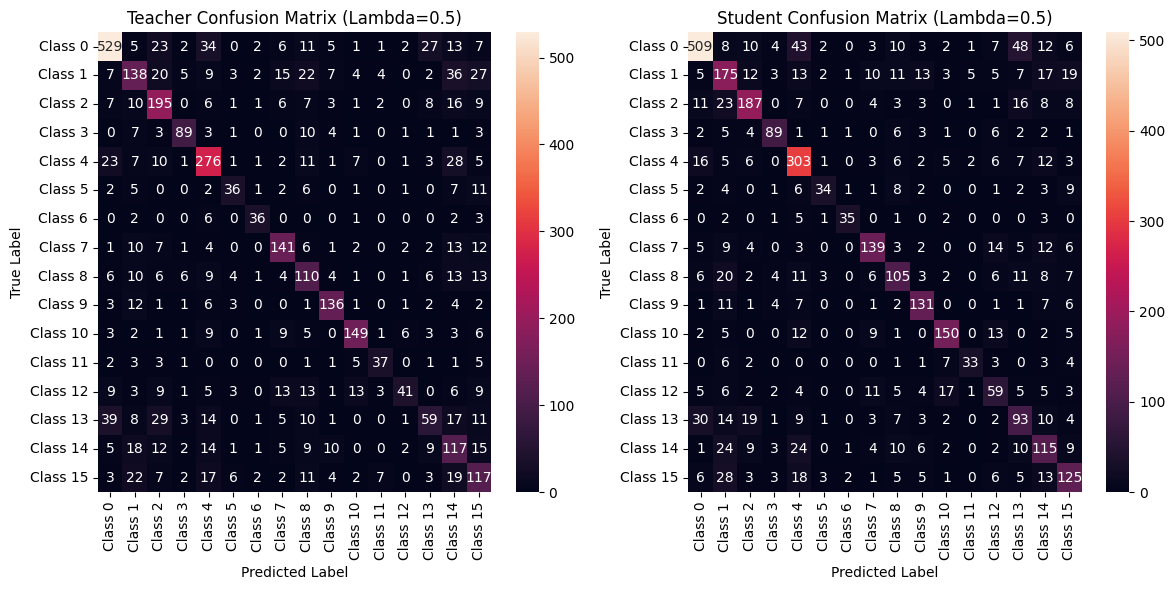

Classification Report - Teacher Model (Lambda=0.5)
              precision    recall  f1-score   support

     Class 0       0.83      0.79      0.81       668
     Class 1       0.53      0.46      0.49       301
     Class 2       0.60      0.72      0.65       272
     Class 3       0.77      0.72      0.74       124
     Class 4       0.67      0.73      0.70       377
     Class 5       0.61      0.49      0.54        74
     Class 6       0.73      0.72      0.73        50
     Class 7       0.67      0.70      0.68       202
     Class 8       0.47      0.57      0.52       194
     Class 9       0.76      0.79      0.77       173
    Class 10       0.79      0.75      0.77       199
    Class 11       0.67      0.62      0.64        60
    Class 12       0.69      0.32      0.44       129
    Class 13       0.47      0.30      0.36       198
    Class 14       0.40      0.53      0.45       220
    Class 15       0.46      0.52      0.49       224

    accuracy                 

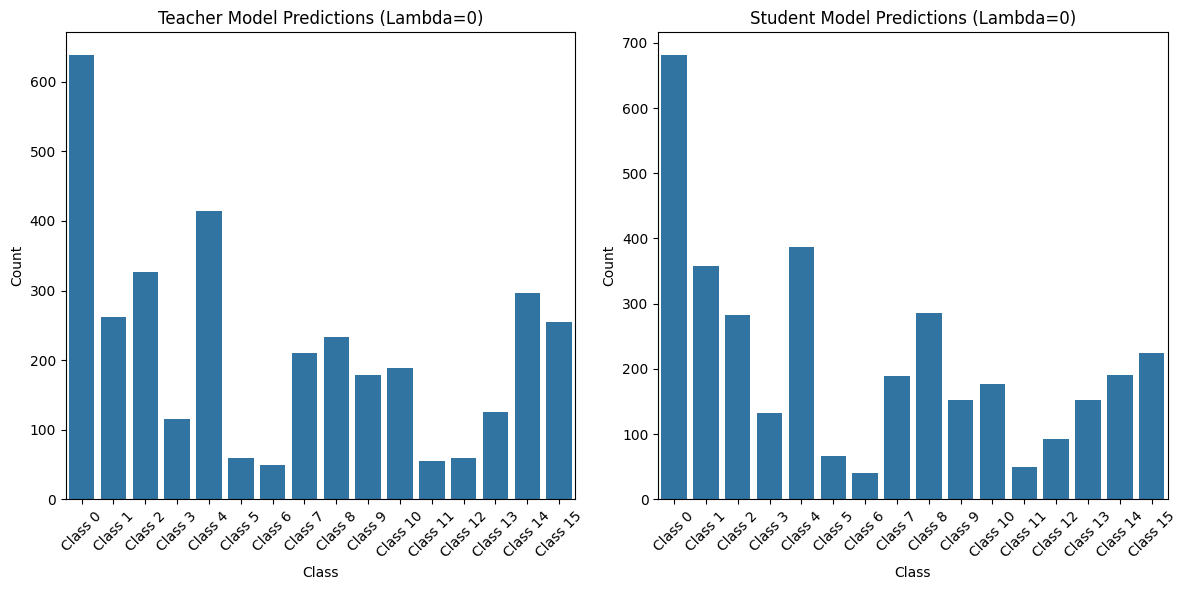

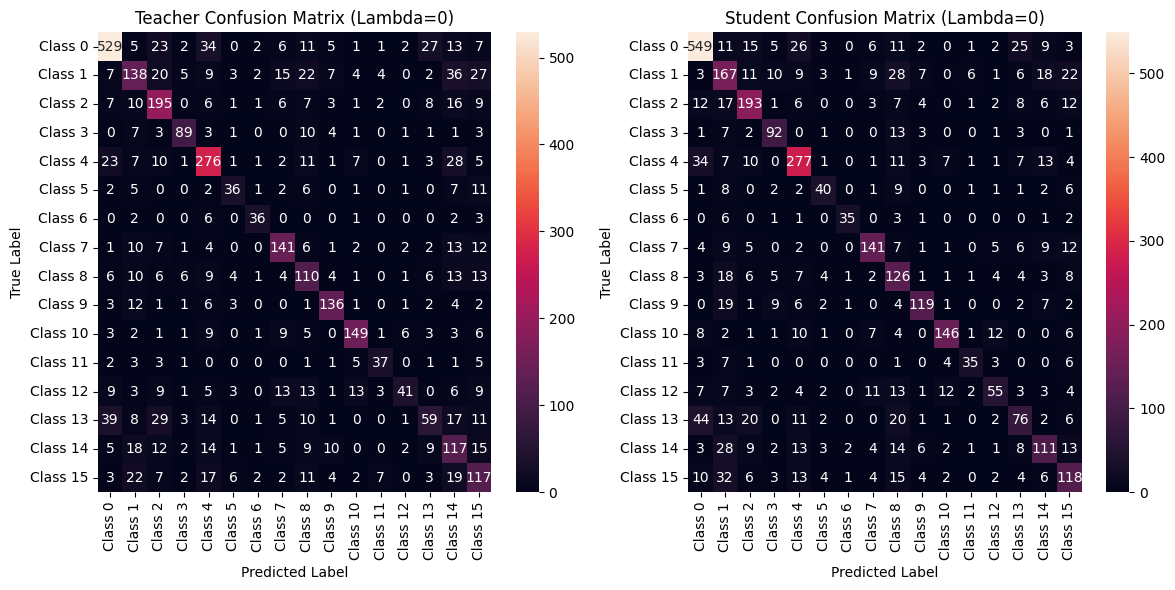

Classification Report - Teacher Model (Lambda=0)
              precision    recall  f1-score   support

     Class 0       0.83      0.79      0.81       668
     Class 1       0.53      0.46      0.49       301
     Class 2       0.60      0.72      0.65       272
     Class 3       0.77      0.72      0.74       124
     Class 4       0.67      0.73      0.70       377
     Class 5       0.61      0.49      0.54        74
     Class 6       0.73      0.72      0.73        50
     Class 7       0.67      0.70      0.68       202
     Class 8       0.47      0.57      0.52       194
     Class 9       0.76      0.79      0.77       173
    Class 10       0.79      0.75      0.77       199
    Class 11       0.67      0.62      0.64        60
    Class 12       0.69      0.32      0.44       129
    Class 13       0.47      0.30      0.36       198
    Class 14       0.40      0.53      0.45       220
    Class 15       0.46      0.52      0.49       224

    accuracy                   

In [34]:
def plot_combined_distribution(teacher_preds, student_preds, class_names, lmda):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.countplot(x=teacher_preds)
    plt.title(f'Teacher Model Predictions (Lambda={lmda})')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(range(len(class_names)), class_names, rotation=45)

    plt.subplot(1, 2, 2)
    sns.countplot(x=student_preds)
    plt.title(f'Student Model Predictions (Lambda={lmda})')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(range(len(class_names)), class_names, rotation=45)
    plt.tight_layout()
    plt.show()

def plot_combined_confusion_matrix(all_labels, teacher_preds, student_preds, class_names, lmda):
    cm_teacher = confusion_matrix(all_labels, teacher_preds)
    cm_student = confusion_matrix(all_labels, student_preds)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.heatmap(pd.DataFrame(cm_teacher, index=class_names, columns=class_names), annot=True, fmt='g')
    plt.title(f'Teacher Confusion Matrix (Lambda={lmda})')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    plt.subplot(1, 2, 2)
    sns.heatmap(pd.DataFrame(cm_student, index=class_names, columns=class_names), annot=True, fmt='g')
    plt.title(f'Student Confusion Matrix (Lambda={lmda})')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# Loop over each lambda value
for lmda in lmda_list_student:
    # Load teacher and student models
    teacher_model = torch.load(f'teacher_model_ckd_wider_lambda02.pth')
    student_model = torch.load(f'student_model_ckd_wider_lambda{lmda}.pth')

    # Generate predictions and compute metrics
    performance_metrics = compare_performance_metrics(teacher_model, student_model, testloader)
    all_labels = performance_metrics['all_labels']
    all_teacher_preds = performance_metrics['all_teacher_preds']
    all_student_preds = performance_metrics['all_student_preds']

    # Plot distribution and confusion matrices
    plot_combined_distribution(all_teacher_preds, all_student_preds, class_names_new, lmda)
    plot_combined_confusion_matrix(all_labels, all_teacher_preds, all_student_preds, class_names_new, lmda)

    # Print classification reports
    teacher_report = classification_report(all_labels, all_teacher_preds, target_names=class_names_new, zero_division=0)
    student_report = classification_report(all_labels, all_student_preds, target_names=class_names_new, zero_division=0)
    print(f'Classification Report - Teacher Model (Lambda={lmda})')
    print(teacher_report)
    print(f'Classification Report - Student Model (Lambda={lmda})')
    print(student_report)


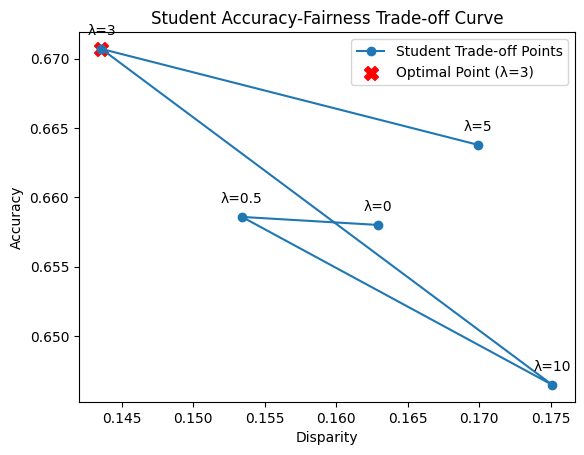

Optimal Lambda for Student: 3
Optimal Bias/Disparity for Student: 0.14357080178514248
Optimal Accuracy for Student: 0.6707070707070707
Optimal Weighted Ratio for Student: 0.59


In [35]:
def plot_bias_variance_tradeoff(model_results, model_type, lambdas):
    # Extract bias (disparity) and accuracy values
    if model_type == 'teacher':
        bias_values = [result['teacher_mean_abs_val_disparity'][0] for result in model_results.values()]
        accuracy_values = [result['performance_metrics']['metrics']['accuracy'][0] for result in model_results.values()]
        model_name = "Teacher"
    elif model_type == 'student':
        bias_values = [result['student_mean_abs_val_disparity'] for result in model_results.values()]
        accuracy_values = [result['performance_metrics']['metrics']['accuracy'][1] for result in model_results.values()]
        model_name = "Student"
    else:
        raise ValueError("Invalid model type. Choose 'teacher' or 'student'.")

    # Weight for the trade-off (can be adjusted based on preference)
    bias_weight = 1

    # Calculate the weighted ratio
    weighted_ratios = np.array(accuracy_values) / (1 + bias_weight * np.array(bias_values))
    closest_to_one_index = np.argmin(np.abs(weighted_ratios - 1))
    optimal_bias = bias_values[closest_to_one_index]
    optimal_accuracy = accuracy_values[closest_to_one_index]
    optimal_ratio = weighted_ratios[closest_to_one_index]

    # Plotting the bias-variance trade-off curve
    plt.plot(bias_values, accuracy_values, marker='o', linestyle='-', label=f'{model_name} Trade-off Points')

    # Mark all points with their lambda values
    for i, (bias, acc, lmbda) in enumerate(zip(bias_values, accuracy_values, lambdas)):
        plt.annotate(f'λ={lmbda}', (bias, acc), textcoords="offset points", xytext=(0,10), ha='center')

    # Highlight the optimal point
    plt.scatter(optimal_bias, optimal_accuracy, color='r', s=100, marker='X', label=f'Optimal Point (λ={lambdas[closest_to_one_index]})')
    plt.xlabel('Disparity')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} Accuracy-Fairness Trade-off Curve')
    plt.legend()
    plt.show()

    # Print optimal values
    print(f"Optimal Lambda for {model_name}: {lambdas[closest_to_one_index]}")
    print(f"Optimal Bias/Disparity for {model_name}: {optimal_bias}")
    print(f"Optimal Accuracy for {model_name}: {optimal_accuracy}")
    print(f"Optimal Weighted Ratio for {model_name}: {optimal_ratio:.2f}")

# Plot for Teacher
# plot_bias_variance_tradeoff(lambda_results, 'teacher', lmda_list)

# Plot for Student
plot_bias_variance_tradeoff(lambda_results, 'student', lmda_list_student)
